Final Project
================
Collaborators: 
* Brian Demyan
* Alan Fuentes

Frame the Problem and Look at the Big Picture
=====================================

1. **Define the objective in business terms:** Hired by the United States Department of Transportation in order to evaluate the factors which contribute to severe accidents, and in turn, longer traffic jams/delays. The US DoT is embarking on a project to address the most impactful factors, sparked by a new presidential administration's initiative to reduce automotive accident-related fatalities. The new administration has also championed initiatives to reduce traffic congestion across the United States by revamping automotive infrastructure (roads, highways, traffic control systems, etc.). The US DoT's project would effectively tie two loose ends at once. The US DoT requires an effective solution in order to correctly allocate resources to this issue. Their success in this endeavor will determine whether the DoT will see increases to their current budget or budget cuts.

2. **How will your solution be used?** It will be used in a pipeline to determine the factors that cause severe accidents/longer traffic delays so the DoT can allocate resources to their automotive safety/traffic decongestion project. It will periodically process new data at an annual rate after new yearly analytical summary data is released.

3. **How is a solution being used?** Currently no solution for this is used, the next step simply does not utilize this information and mostly relies on longer-term information. 

4. **How should you frame this problem?** This will be a supervised, binary classification problem where we are predicting which factors contribute to severe accidents/traffic delays. As the client only requires the information to be updated infrequently after new yearly data has been obtained, offline batch learning will be used. 

5. **How should performance be measured? Is the performance measure aligned with the business objective?** Performance will be measured using the F1 score, as we want to minimize false positives (predicting a severe accident/delay when there is none) and false negatives (missing actual severe accidents/delays). 

6. **What would be the minimum performance needed to reach the business objective?** The minimum should be an F1 score of 0.70, as anything below that might result in a system that fails to effectively predict severe accidents/delays or causes too many false alerts.

7. **What are comparable problems? Can you reuse (personal or readily available) experience or tools?** A similar classification problem would be the early spring and diseased squirrel analyses, as they were both binary classification problems.

8. **Is human expertise available?** The client is providing information they have compiled, but no previous work on this specific matter has been conducted.

9. **How would you solve the problem manually?** I would create a function to parse through the automotive accident data and return the counts of unique contributing factors in descending order in order to begin investigating them.

10. **List the assumptions you (or others) have made so far. Verify assumptions if possible.** 

* The period of data used (2016-2023) contains typical data (relative to historical records) and is not affected by some sort of short-term influence. 
* Recorded data and its units are accurate
* The data pertains to only the listed 49 states in the United States

In [1]:
import numpy as np
import matplotlib.pylab as plt
from sklearn.linear_model import LinearRegression, SGDRegressor, Ridge, Lasso, ElasticNet
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error

from sklearn.model_selection import cross_val_score, train_test_split

import scipy
import pandas as pd
from pandas import read_csv
import matplotlib.pylab as plot
import seaborn as sns
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer, StandardScaler, MinMaxScaler, LabelEncoder, MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_curve, roc_curve, roc_auc_score
from sklearn.cluster import DBSCAN

from sklearn import set_config
set_config(transform_output = "pandas")

Get the Data
================

1. **List the data you need and how much you need:**
- US Accident Data, 500k sampled version
2. **Find and document where you can get that data:**
- The US Accident data is available on Kaggle (links below). The first link will bring you to the Kaggle page for the accidents containing resources and links to all the information. The second link, found in the description of the Kaggle page, redirects to a Google Drive page where you can hit the download button in the upper right corner to get the sampled dataset used in this analysis.
3. **Get access authorizations**: None needed, publicly available.
4. **Create a workspace**: This notebook.
5. **Get the data**: 
- [Kaggle Page for US accident data](https://www.kaggle.com/datasets/sobhanmoosavi/us-accidents)
- [Google Drive Page to download 500k sampled dataset we used](https://drive.google.com/file/d/1U3u8QYzLjnEaSurtZfSAS_oh9AT2Mn8X/edit)
6. **Convert the data to a format you can easily manipulate**: 
- Provided data is in csv format so it's easy to use
7. **Ensure sensitive information is deleted or protected**: Public data already has been anonymized.
8. **Check the size and type of data (time series, geographical, …)**: Done below.
9. **Sample a test set, put it aside, and never look at it (no data snooping!)**

## Observations

- There are 500,000 samples with 46 features

- Historical data ranges from 01-14-2016 to 03-31-2023

- Our target label is `Severity`, as we want to predict the severity of an accident and its subsequent impact on traffic

- We transformed `Severity` into `Severity_Binary`, as it contained 4 categories and we want to evaluate using binary classification

- 402,416 accidents were not severe, while 97,584 were severe

- 3.61% of the data (829,873 values) are missing (NaNs)

- Features that don't seem useful to task:
    - `ID` is just the unqiue accident identifier values
    - `Source` identifies the source of the accident data
    - `Weather_Timestamp` may not be helpful if we know what the weather conditions were for the reported accident (based on the ID field)
    - `Wind_Direction` seems like it would not have a great effect on the accidents themselves
    - `Civil_Twilight`, `Nautical_Twilight`, and `Astronomical_Twilight` are all closely related to `Sunrise_Sunset`, so we would drop them in favor of `Sunrise_Sunset` since knowing the actual sunrises and sunsets would be the best indicators of time of day and visibility based on night and day
    - `Country` is not useful since the data is for 49 states in the US


- Ambiguous Features
    - `Lat/Lng` - unsure of how useful coordinate data would be for accidents, especially the end lat/longitudes as an accident's location shouldn't really change
    - `Description` - compilation of strings describing the accident and its impact/severity, may not be usable
    - `Airport_Code` - unclear whether the airport code would tell us about accident information
    - `Wind_Speed(mph)` - wind speed seems more useful than wind direction, but the impact it would have doesn't seem that more useful compared to other available weather data

We predict the most important predictors of `Severity_Binary` will be:
- Boolean traffic flow-related features
   - `Bump`, `Crossing`, `Give_Way`, `Junction`, `No_Exit`, `Railway`, `Roundabout`, `Station`, `Stop`, `Traffic_Calming`, `Traffic_Signal`, `Turning_Loop`
   
- `Start/End_Time`
- `Distance(mi)`
- `Street/City/County/State/Zipcode`
- `Timezone`
- `Temperature(F)/Humidity(%)/Pressure(in)/Visibility(mi)/Precipitation(in)`
- `Sunrise_Sunset` 

In [2]:
# Load accident data 
accidents = read_csv('US_Accidents_March23_sampled_500k.csv')

In [3]:
accidents.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500000 entries, 0 to 499999
Data columns (total 46 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   ID                     500000 non-null  object 
 1   Source                 500000 non-null  object 
 2   Severity               500000 non-null  int64  
 3   Start_Time             500000 non-null  object 
 4   End_Time               500000 non-null  object 
 5   Start_Lat              500000 non-null  float64
 6   Start_Lng              500000 non-null  float64
 7   End_Lat                279623 non-null  float64
 8   End_Lng                279623 non-null  float64
 9   Distance(mi)           500000 non-null  float64
 10  Description            499999 non-null  object 
 11  Street                 499309 non-null  object 
 12  City                   499981 non-null  object 
 13  County                 500000 non-null  object 
 14  State                  500000 non-nu

array([[<Axes: title={'center': 'Severity'}>,
        <Axes: title={'center': 'Start_Lat'}>,
        <Axes: title={'center': 'Start_Lng'}>,
        <Axes: title={'center': 'End_Lat'}>],
       [<Axes: title={'center': 'End_Lng'}>,
        <Axes: title={'center': 'Distance(mi)'}>,
        <Axes: title={'center': 'Temperature(F)'}>,
        <Axes: title={'center': 'Wind_Chill(F)'}>],
       [<Axes: title={'center': 'Humidity(%)'}>,
        <Axes: title={'center': 'Pressure(in)'}>,
        <Axes: title={'center': 'Visibility(mi)'}>,
        <Axes: title={'center': 'Wind_Speed(mph)'}>],
       [<Axes: title={'center': 'Precipitation(in)'}>, <Axes: >,
        <Axes: >, <Axes: >]], dtype=object)

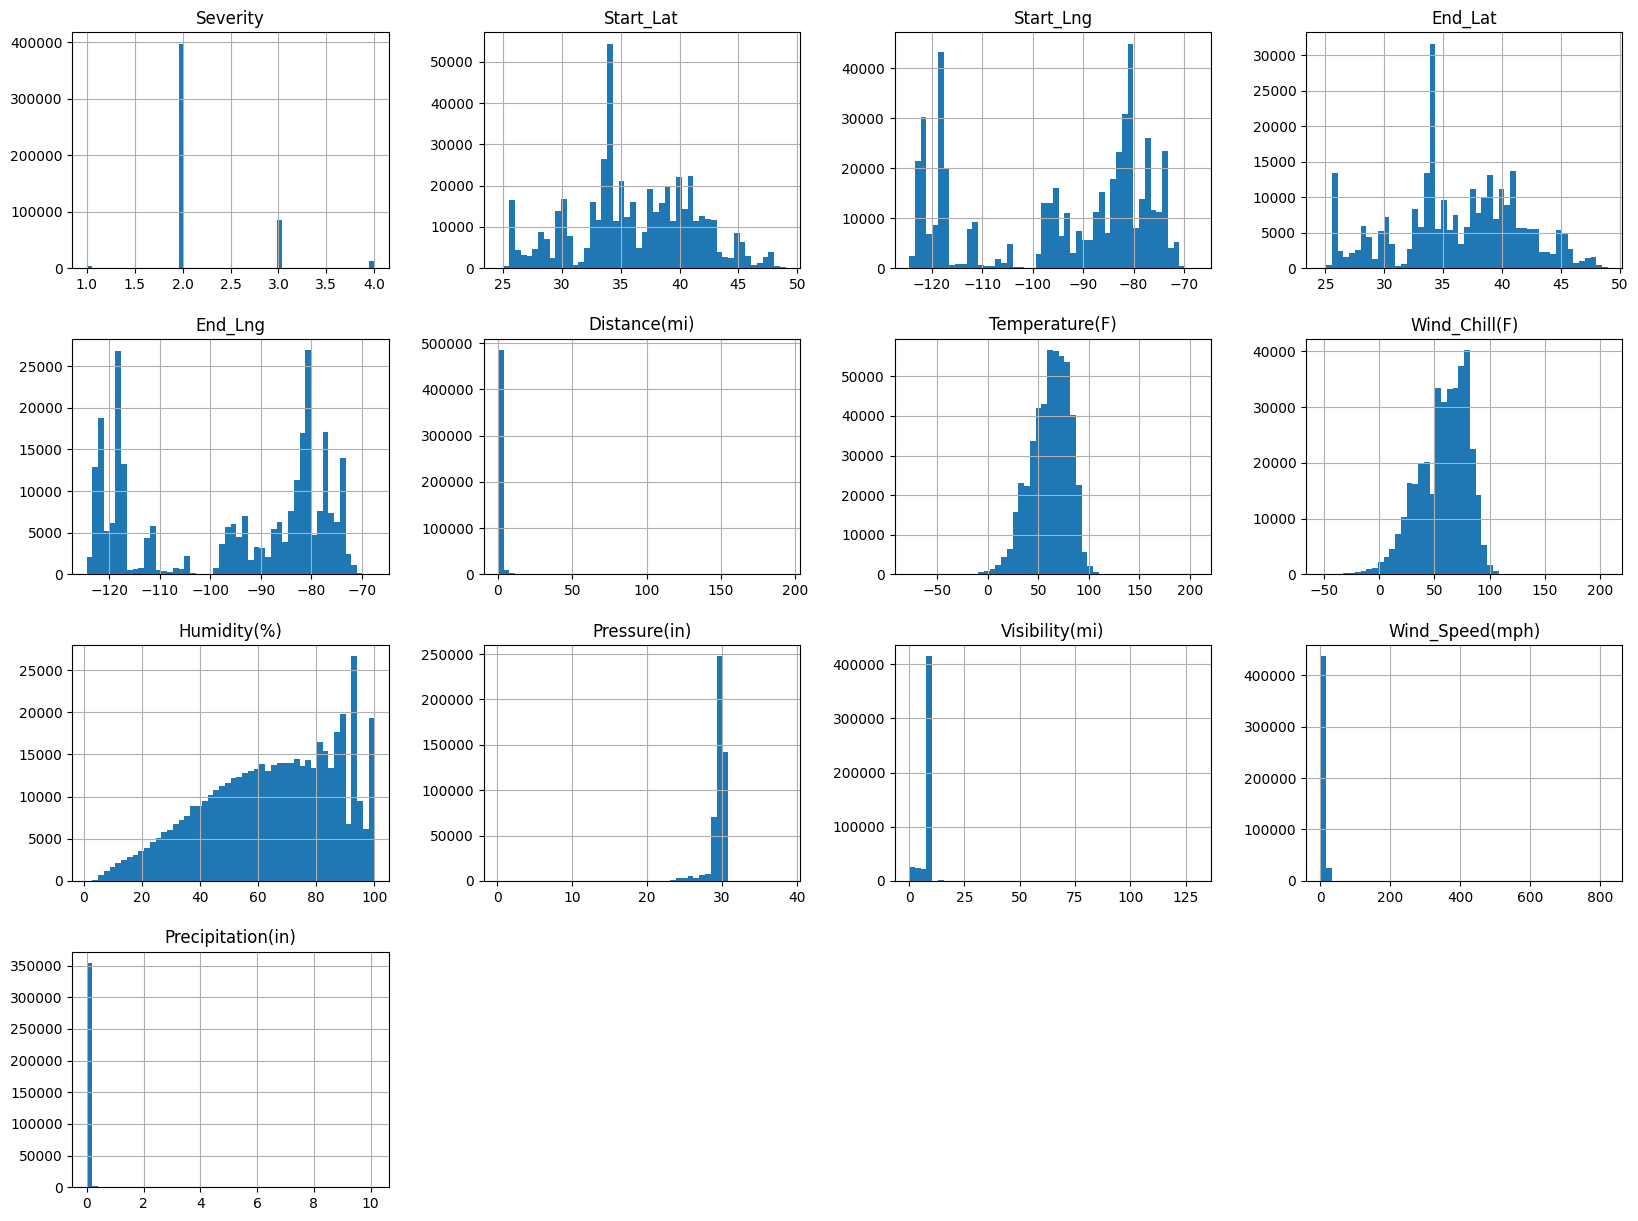

In [4]:
accidents.hist(bins=50, figsize=(20,15))

<Axes: >

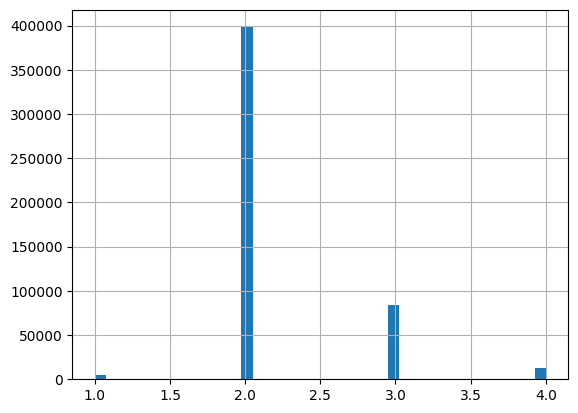

In [8]:
accidents["Severity"].hist(bins=40) 

In [5]:
accidents["Severity"].value_counts()

Severity
2    398142
3     84520
4     13064
1      4274
Name: count, dtype: int64

In [6]:
# Transform severity to binary, mapping 1 and 2 to 0 and 3 and 4 to 1
accidents["Severity_Binary"] = np.where(accidents["Severity"] <= 2, 0, 1)

# Drop the original severity column
accidents = accidents.drop(columns=["Severity"])

In [7]:
accidents["Severity_Binary"].value_counts()

Severity_Binary
0    402416
1     97584
Name: count, dtype: int64

<Axes: >

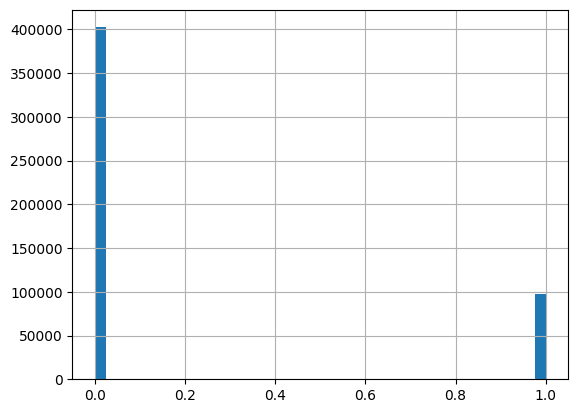

In [12]:
accidents["Severity_Binary"].hist(bins=40)

In [8]:
missing = accidents.isnull().sum().sum()
print(f"Missing values: {missing}")

percentage_missing = missing / (accidents.shape[0] * accidents.shape[1]) * 100
print(f"Percentage of missing values: {percentage_missing:.2f}%")

Missing values: 829873
Percentage of missing values: 3.61%


In [9]:
accidents.shape

(500000, 46)

In [11]:
accidents.describe()

Start_Lat      Start_Lng        End_Lat        End_Lng  \
count  500000.000000  500000.000000  279623.000000  279623.000000   
mean       36.206421     -94.736583      36.273192     -95.776553   
std         5.071411      17.405761       5.265333      18.120211   
min        24.562117    -124.497420      24.570110    -124.497419   
25%        33.416823    -117.233047      33.474773    -117.778324   
50%        35.832147     -87.794365      36.192669     -88.039013   
75%        40.082443     -80.359601      40.181341     -80.252449   
max        48.999569     -67.484130      48.998901     -67.484130   

        Distance(mi)  Temperature(F)  Wind_Chill(F)    Humidity(%)  \
count  500000.000000   489534.000000  370983.000000  488870.000000   
mean        0.564317       61.646254      58.229028      64.834921   
std         1.774872       19.000133      22.352246      22.826158   
min         0.000000      -77.800000     -53.200000       1.000000   
25%         0.000000       49.000000      43.000000      48.000000   
50%         0.029000       64.000000      62.000000      67.000000   
75%         0.465000       76.000000      75.000000      84.000000   
max       193.479996      207.000000     207.000000     100.000000   

        Pressure(in)  Visibility(mi)  Wind_Speed(mph)  Precipitation(in)  \
count  491072.000000   488709.000000    463013.000000      357384.000000   
mean       29.536621        9.091540         7.681347           0.008289   
std         1.008666        2.708083         5.431361           0.101865   
min         0.120000        0.000000         0.000000           0.000000   
25%        29.370000       10.000000         4.600000           0.000000   
50%        29.860000       10.000000         7.000000           0.000000   
75%        30.030000       10.000000        10.400000           0.000000   
max        38.440000      130.000000       822.800000          10.130000   

       Severity_Binary  
count    500000.000000  
mean          0.195168  
std           0.396330  
min           0.000000  
25%           0.000000  
50%           0.000000  
75%           0.000000  
max           1.000000

Stratification
===========

In [12]:
# Binary classifier stratification for binary severity feature

X = accidents.drop(columns=['Severity_Binary'])
y = accidents['Severity_Binary']

# Split the dataset with stratification for classification
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Verify the distribution
print("Original distribution:", dict(zip(*np.unique(y, return_counts=True))))
print("Training distribution:", dict(zip(*np.unique(y_train, return_counts=True))))
print("Testing distribution:", dict(zip(*np.unique(y_test, return_counts=True))))

Original distribution: {np.int64(0): np.int64(402416), np.int64(1): np.int64(97584)}
Training distribution: {np.int64(0): np.int64(321933), np.int64(1): np.int64(78067)}
Testing distribution: {np.int64(0): np.int64(80483), np.int64(1): np.int64(19517)}


Explore the Data
=============

Notes:
* I want lots of written information, the only code to keep when submitting is the code to output numbers, tables, or plots that you refer to in your writing
* During exploration, it is reasonable to remove unreasonable outliers (and document that you are doing so and how you are classifying what an outlier is) before doing further analysis
  * There are differences in outliers: ones that are real and ones that are errors. For example, if a height was entered as 7'1" for Shaq O'Neal, that is a real outlier, it has meaning. If a height was entered as 7'1" for a random person, that is an error. You should (try to) remove (only) the error/non-useful ones.
* You will need to explore how to work with date-times, Pandas has a very wide range of utilities for working with them, one particular thing to possibly use is extracting components of the date-time (like hours in the day or day-of-week)
* Document all important things, make sure to put headers for the separate steps, and keep everything organized

Reminder about the 9 steps (points in parentheses):
1. (1) Copy the data for exploration, downsampling to a manageable size if necessary.
2. (6) Study each attribute and its characteristics: Name; Type (categorical, numerical, bounded, text, structured, …); % of missing values; Noisiness and type of noise (stochastic, outliers, rounding errors, …); Usefulness for the task; Type of distribution (Gaussian, uniform, logarithmic, …) (format as a nice markdown table!)
3. (2) For supervised learning tasks, identify the target attribute(s)
4. (4) Visualize the data
5. (5) Study the correlations between attributes
6. (2) Study how you would solve the problem manually (using the data you have)
7. (3) Identify the promising transformations you may want to apply
8. (2) Identify extra data that would be useful (discuss it, but don't actually go through with it)
9. (0) Document what you have learned (included in the other steps - it is actually worth most of the points!)

In [13]:
X_combined = X_train.copy()

y_combined = y_train.copy()

- Variance Threshold was used to evaluate which features had very little variance and wouldn't be able to provide any effective analysis

In [14]:
from sklearn.feature_selection import VarianceThreshold

# Filter out non-numerical and non-boolean features
numerical_boolean_features = X_combined.select_dtypes(include=['number', 'bool'])

# Remove features with low variance
selector = VarianceThreshold(threshold=0.02) # Used 0.02 to identify features with low variance (2%)
selector.fit(numerical_boolean_features)

# Features that passed the threshold
low_variance_features = numerical_boolean_features.columns[~selector.get_support()]
print("Low variance features to drop:", low_variance_features)

Low variance features to drop: Index(['Precipitation(in)', 'Amenity', 'Bump', 'Give_Way', 'No_Exit',
       'Railway', 'Roundabout', 'Traffic_Calming', 'Turning_Loop'],
      dtype='object')


## Feature Importance

- Set up a copied dataset to use in evaluating the importances
- Label encoded categorical features, dropping features that would pose issues to running the Random Forest Classifier
- Most important feature was Street, while 2 completely unimportant features were `Country` and `Turning_Loop`

In [15]:
X_rf = X_combined.copy()
y_rf = y_combined.copy()

# drop several troublesome features 
X_rf = X_rf.drop(columns=['Start_Time', 'End_Time', 'ID', 'Source', 'Description', 'Weather_Timestamp'])

# Identify categorical features
categorical_features = X_rf.select_dtypes(include=['object'])


# Encode categorical features using LabelEncoder
for column in categorical_features.columns:
    le = LabelEncoder()
    X_rf[column] = le.fit_transform(X_rf[column])

# Display the encoded features
X_rf.head()

Start_Lat   Start_Lng    End_Lat    End_Lng  Distance(mi)  Street  \
99896   25.913402  -80.325052  25.913222 -80.325043         0.012   58875   
391011  40.766694  -73.896471  40.760235 -73.857217         2.102   47194   
66857   39.981968  -83.008698        NaN        NaN         0.000   73560   
113382  44.968445  -93.251770        NaN        NaN         0.000   32383   
409914  40.682755 -111.462715        NaN        NaN         6.390   69957   

        City  County  State  Zipcode  ...  Roundabout  Station   Stop  \
99896   3560     910      8    43113  ...       False    False  False   
391011  2271    1140     32     4852  ...       False    False  False   
66857   1633     498     33    55089  ...       False    False   True   
113382  5204     627     21    61993  ...       False    False  False   
409914  6196    1362     42    82407  ...       False    False  False   

        Traffic_Calming  Traffic_Signal  Turning_Loop  Sunrise_Sunset  \
99896             False           False         False               0   
391011            False           False         False               1   
66857             False           False         False               0   
113382            False           False         False               0   
409914            False           False         False               1   

        Civil_Twilight  Nautical_Twilight  Astronomical_Twilight  
99896                0                  0                      0  
391011               0                  0                      0  
66857                0                  0                      0  
113382               0                  0                      0  
409914               1                  1                      1  

[5 rows x 39 columns]

                  Feature    Importance
5                  Street  1.570909e-01
3                 End_Lng  6.888476e-02
1               Start_Lng  6.602668e-02
0               Start_Lat  6.525246e-02
9                 Zipcode  6.280125e-02
2                 End_Lat  6.000419e-02
4            Distance(mi)  4.847175e-02
16           Pressure(in)  4.424194e-02
14          Wind_Chill(F)  3.856758e-02
15            Humidity(%)  3.823112e-02
13         Temperature(F)  3.695939e-02
6                    City  3.475657e-02
7                  County  3.306560e-02
12           Airport_Code  3.103178e-02
19        Wind_Speed(mph)  2.987624e-02
18         Wind_Direction  2.748924e-02
33         Traffic_Signal  2.443676e-02
21      Weather_Condition  2.288262e-02
8                   State  2.243550e-02
20      Precipitation(in)  2.075928e-02
24               Crossing  1.536591e-02
17         Visibility(mi)  1.151631e-02
26               Junction  6.609846e-03
11               Timezone  5.736274e-03


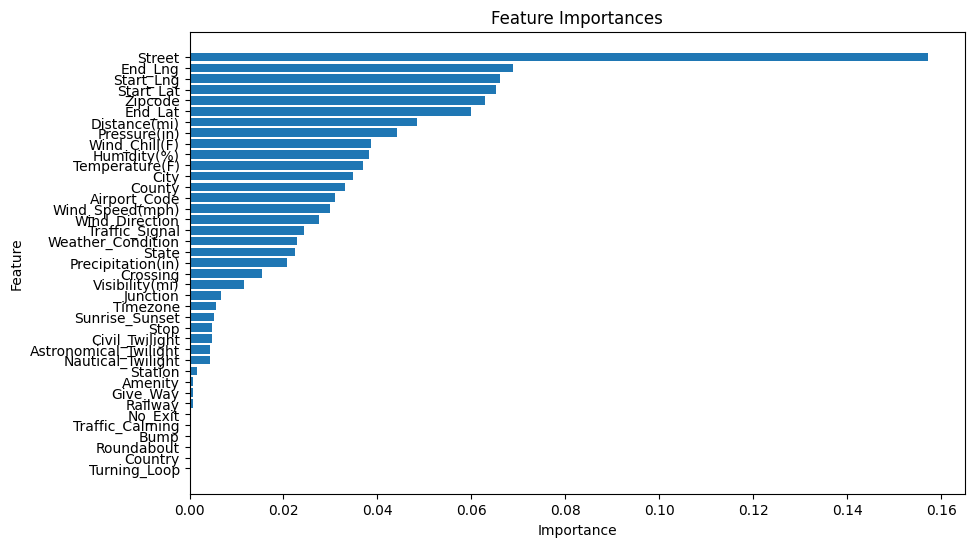

In [16]:
# Initialize and train the RandomForest model
model = RandomForestClassifier(random_state=42)
model.fit(X_rf, y_rf)

# Extract feature importances
feature_importances = model.feature_importances_

# Create a DataFrame with the feature names and their importance
feature_importances_df = pd.DataFrame(
    {"Feature": X_rf.columns, "Importance": feature_importances}
)

# Sort the Dataframe by importance
feature_importances_df = feature_importances_df.sort_values("Importance", ascending=False)

# Display the feature importances
print(feature_importances_df)

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.barh(feature_importances_df["Feature"], feature_importances_df["Importance"])
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("Feature Importances")
plt.gca().invert_yaxis()
plt.show()

- Copied train and test sets were combined to form a data frame for exploration

In [17]:
data = pd.concat([X_combined, y_combined], axis=1)

In [18]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 400000 entries, 99896 to 476005
Data columns (total 46 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   ID                     400000 non-null  object 
 1   Source                 400000 non-null  object 
 2   Start_Time             400000 non-null  object 
 3   End_Time               400000 non-null  object 
 4   Start_Lat              400000 non-null  float64
 5   Start_Lng              400000 non-null  float64
 6   End_Lat                223509 non-null  float64
 7   End_Lng                223509 non-null  float64
 8   Distance(mi)           400000 non-null  float64
 9   Description            399999 non-null  object 
 10  Street                 399437 non-null  object 
 11  City                   399987 non-null  object 
 12  County                 400000 non-null  object 
 13  State                  400000 non-null  object 
 14  Zipcode                399913 non-nul

array([[<Axes: title={'center': 'Start_Lat'}>,
        <Axes: title={'center': 'Start_Lng'}>,
        <Axes: title={'center': 'End_Lat'}>,
        <Axes: title={'center': 'End_Lng'}>],
       [<Axes: title={'center': 'Distance(mi)'}>,
        <Axes: title={'center': 'Temperature(F)'}>,
        <Axes: title={'center': 'Wind_Chill(F)'}>,
        <Axes: title={'center': 'Humidity(%)'}>],
       [<Axes: title={'center': 'Pressure(in)'}>,
        <Axes: title={'center': 'Visibility(mi)'}>,
        <Axes: title={'center': 'Wind_Speed(mph)'}>,
        <Axes: title={'center': 'Precipitation(in)'}>],
       [<Axes: title={'center': 'Severity_Binary'}>, <Axes: >, <Axes: >,
        <Axes: >]], dtype=object)

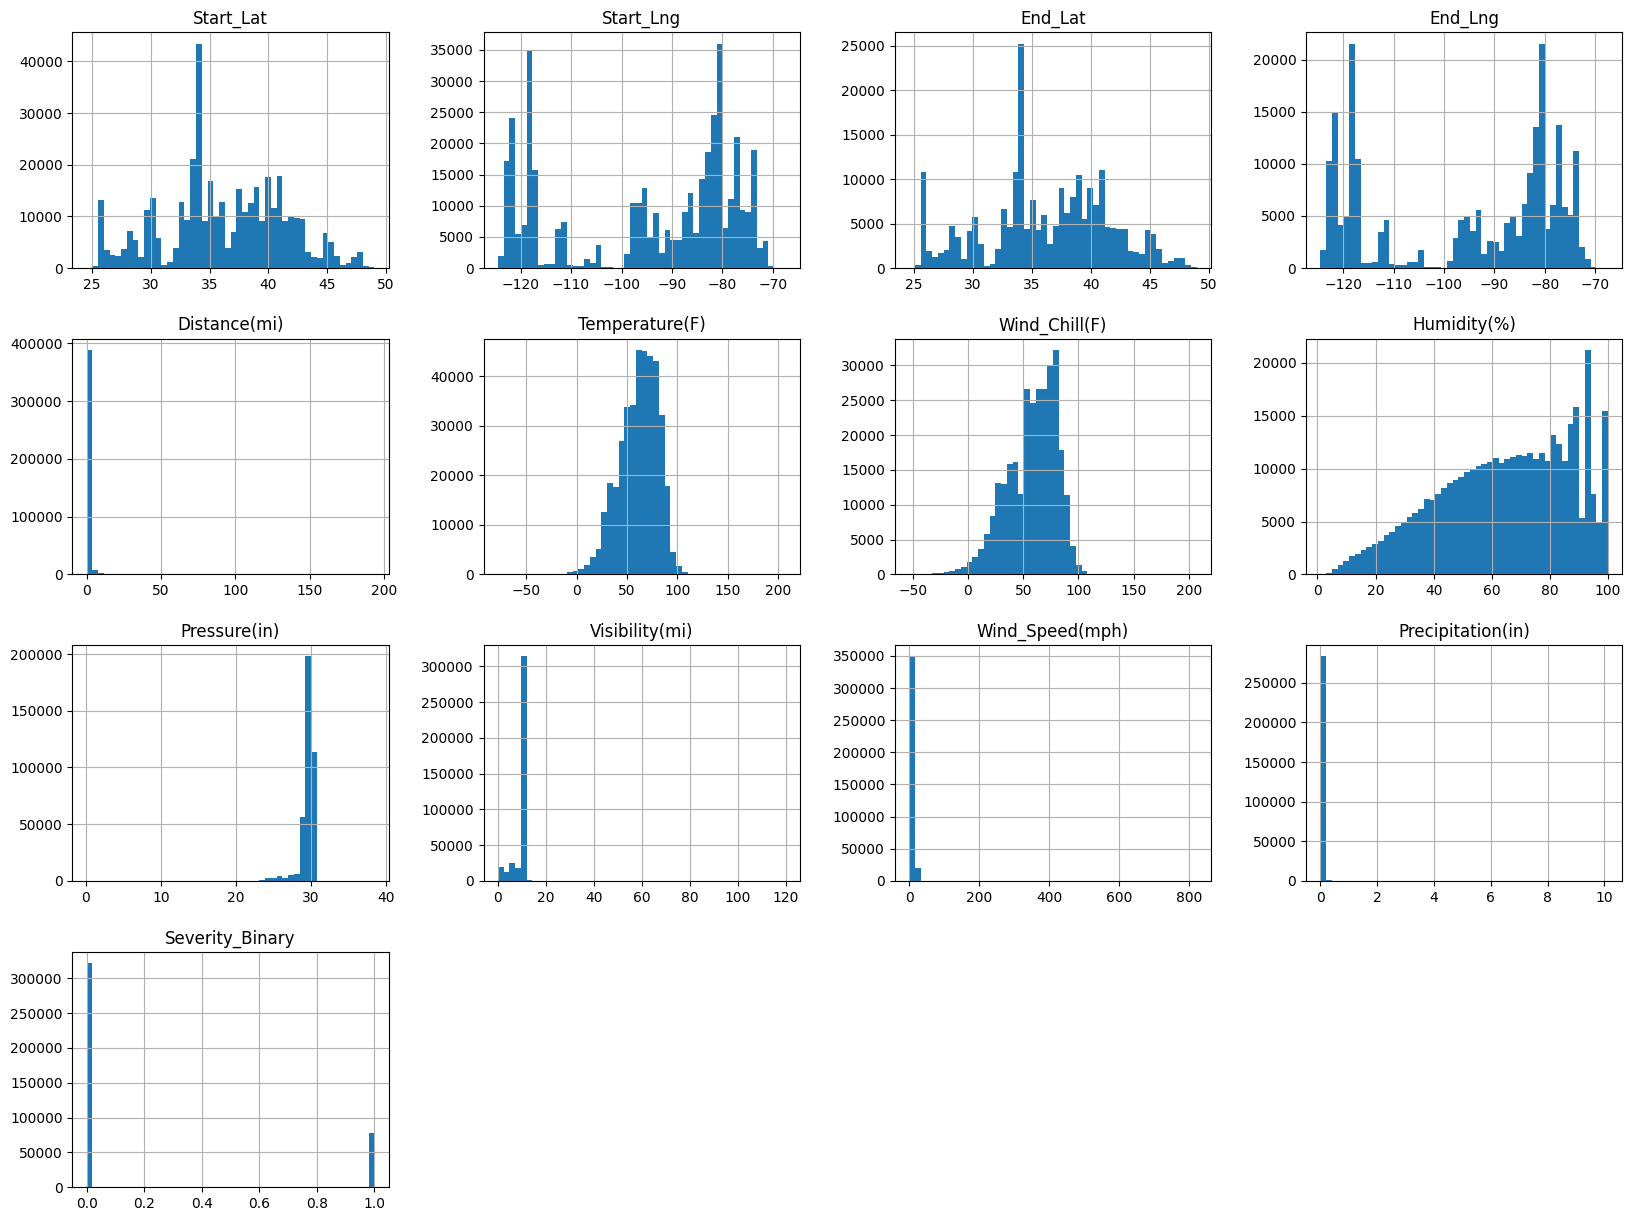

In [ ]:
data.hist(bins=50, figsize=(20,15))

In [19]:
data.describe()

Start_Lat      Start_Lng        End_Lat        End_Lng  \
count  400000.000000  400000.000000  223509.000000  223509.000000   
mean       36.208955     -94.718091      36.275184     -95.770477   
std         5.072640      17.405855       5.263768      18.121604   
min        24.566999    -124.495743      24.571240    -124.495392   
25%        33.419745    -117.229691      33.479919    -117.783358   
50%        35.834170     -87.767775      36.195085     -88.038052   
75%        40.089335     -80.354197      40.184102     -80.251700   
max        48.999569     -67.484130      48.998901     -67.484130   

        Distance(mi)  Temperature(F)  Wind_Chill(F)    Humidity(%)  \
count  400000.000000   391582.000000  296542.000000  391048.000000   
mean        0.564638       61.636018      58.211009      64.836480   
std         1.787272       18.995504      22.346382      22.836553   
min         0.000000      -77.800000     -53.200000       1.000000   
25%         0.000000       49.000000      43.000000      48.000000   
50%         0.029000       64.000000      62.000000      67.000000   
75%         0.464000       76.000000      75.000000      84.000000   
max       193.479996      207.000000     207.000000     100.000000   

        Pressure(in)  Visibility(mi)  Wind_Speed(mph)  Precipitation(in)  \
count  392834.000000   390946.000000    370246.000000      285731.000000   
mean       29.536419        9.091351         7.680980           0.008249   
std         1.010266        2.710613         5.462777           0.101104   
min         0.120000        0.000000         0.000000           0.000000   
25%        29.370000       10.000000         4.600000           0.000000   
50%        29.860000       10.000000         7.000000           0.000000   
75%        30.030000       10.000000        10.400000           0.000000   
max        38.440000      120.000000       822.800000          10.130000   

       Severity_Binary  
count    400000.000000  
mean          0.195167  
std           0.396330  
min           0.000000  
25%           0.000000  
50%           0.000000  
75%           0.000000  
max           1.000000

- Table that summarizes the features in a more manageable format for interpretation

| Name                                       | Type                                                 | Noise                          | Distribution        |
|--------------------------------------------|------------------------------------------------------|--------------------------------|---------------------|
| `ID`                                       | Categorical, indicates accident record               |                                |                     |
| `Source`                                   | Categorical, source of accident                      |                                |                     |
| `Start/End_Time`                           | Datetime                                             |                                |                     |
| `Start/End_Lat/Lng`                        | Categorical, coordinate points (latitude, longitude) | Missing values for End_Lat/Lng |                     |
| `Distance(mi)`                             | Numerical                                            |                                | Somewhat log normal |
| `Temperature(F)`                           | Numerical                                            | Temps range from -77 to 207    | Normal/Gaussian     |
| `Wind_Chill(F)`                            | Numerical                                            | Temps range from -53 to 207    | Normal/Gaussian     |
| `Humidity(%)`                              | Numerical                                            | Capping at 100                 | Capped Normal       |
| `Pressure(in)`                             | Numerical                                            | Outliers                       | Somewhat log normal |
| `Visibility(mi)`                           | Numerical                                            | Outliers                       | Left-skewed         |
| `Wind_Speed(mph)`                          | Numerical                                            | Max value is 822 mph           | Somewhat log normal |
| `Precipitation(in)`                        | Numerical                                            | Outliers                       | Somewhat log normal |
| `Description`                              | Categorical                                          | Extremely varied text strings  |                     |
| `Street/City/County/State/Country/Zipcode` | Categorical, location features                       | Missing values present         |                     |
| `Timezone/Airport Code`                    | Categorical, location features                       | Missing values present         |                     |
| `Weather_Timestamp`                        | Datetime                                             | Missing values                 |                     |
| `Weather_Condition`                        | Categorical, type of weather reported                |  Many different string text types                              |                     |
| `Amenity/Bump/Crossing/Give_Way/Junction`  | Categorical, boolean                                 | Imbalanced                     |                     |
| `No_Exit/Railway/Roundabout/Station/Stop`  | Categorical, boolean                                 | Imbalanced                     |                     |
| `Traffic_Calming/Traffic_Signal`       | Categorical, boolean      | Imbalanced                  |   |
| `Turning_Loop`                         | Categorical, boolean      | All values are same (False) |   |
| `Sunrise_Sunset`                       | Categorical, Day/Night    | Missing values                            |   |
| `Civil/Nautical/Astronomical_Twilight` | Categorical, Day/Night    | Missing values                            |   |
| `Severity_Binary`                      | Categorical, target label | Imbalanced                  |   |


- The range of the most frequent visibility observations lies between 0.5 and 10 miles

(np.int64(40), np.int64(32))

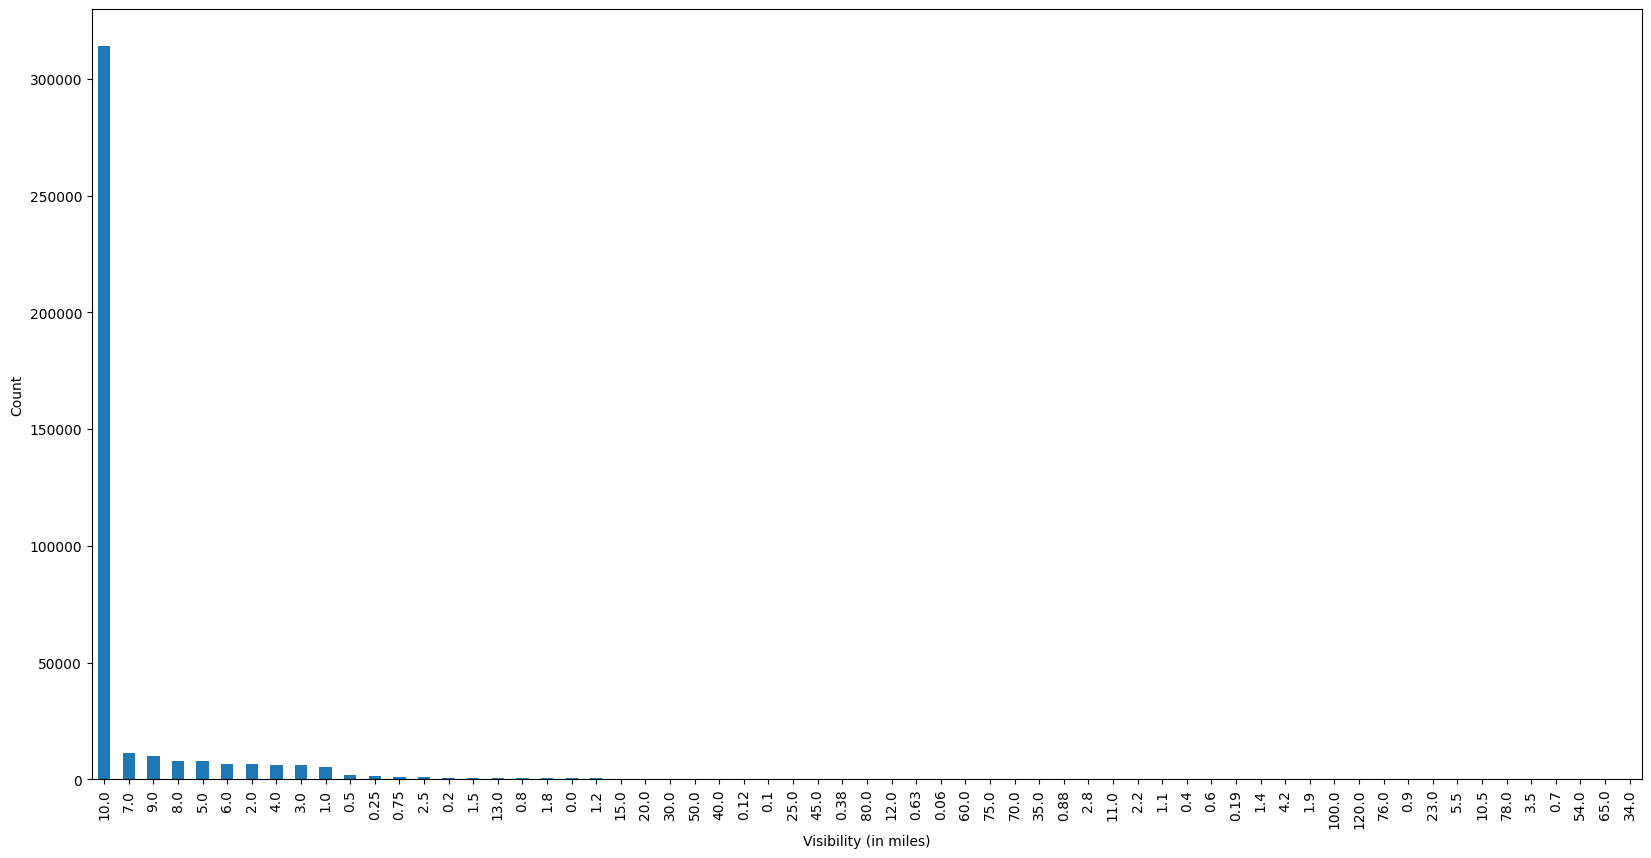

In [20]:
# Look at the distribution of Visibility
counts = data["Visibility(mi)"].value_counts()
counts.plot.bar(figsize=(20, 10))
plt.xlabel("Visibility (in miles)")
plt.ylabel("Count")
((counts / len(data) * 100) < 0.05).sum(), ((counts / len(data) * 100) < 0.005).sum()

- Many counts of wind speeds of 0

(np.int64(54), np.int64(36))

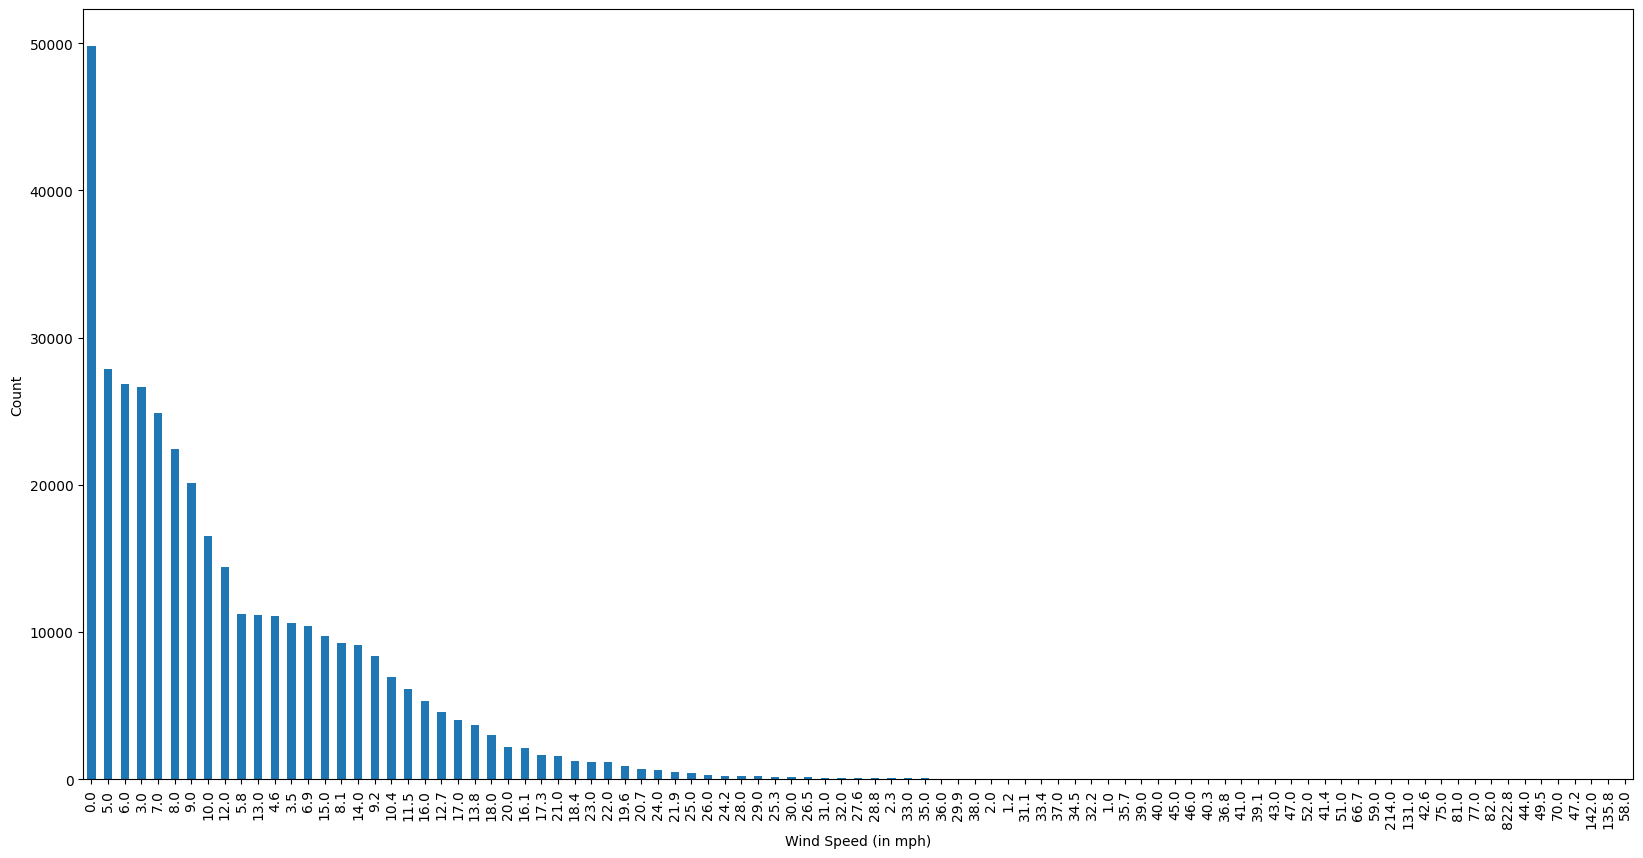

In [21]:
# Look at the distribution of Wind_Speed
counts = data["Wind_Speed(mph)"].value_counts()
counts.plot.bar(figsize=(20, 10))
plt.xlabel("Wind Speed (in mph)")
plt.ylabel("Count")
((counts / len(data) * 100) < 0.05).sum(), ((counts / len(data) * 100) < 0.005).sum()

(np.int64(538), np.int64(360))

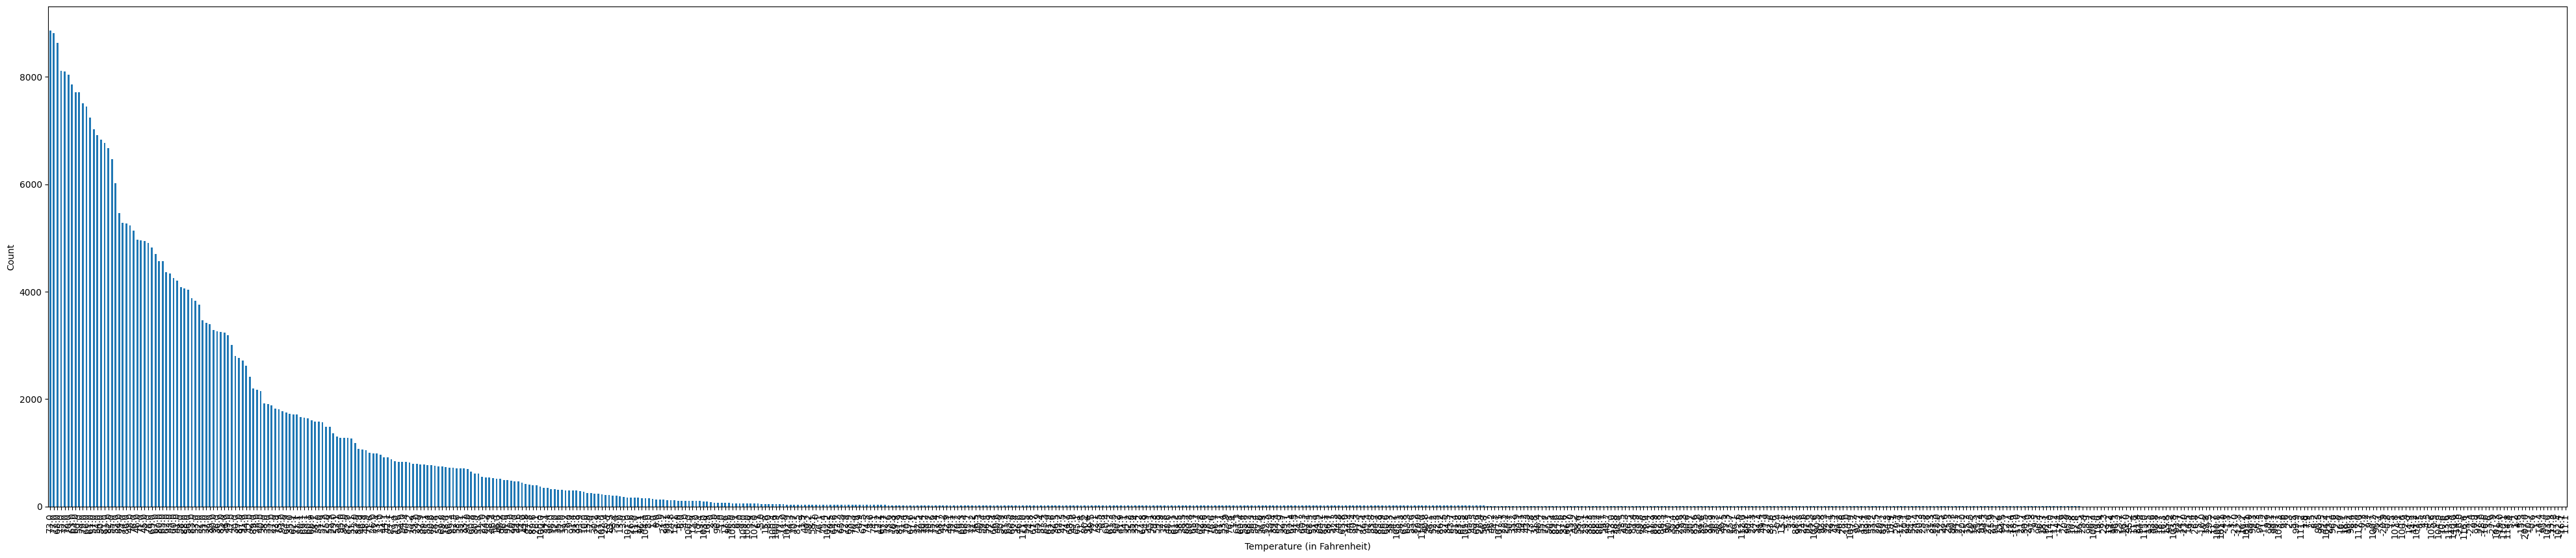

In [ ]:
# Look at the distribution of Temperature
counts = data["Temperature(F)"].value_counts()
counts.plot.bar(figsize=(50, 10))
plt.xlabel("Temperature (in Fahrenheit)")
plt.ylabel("Count")
((counts / len(data) * 100) < 0.05).sum(), ((counts / len(data) * 100) < 0.005).sum()

* Lots of humidity values at 93%

(np.int64(4), np.int64(2))

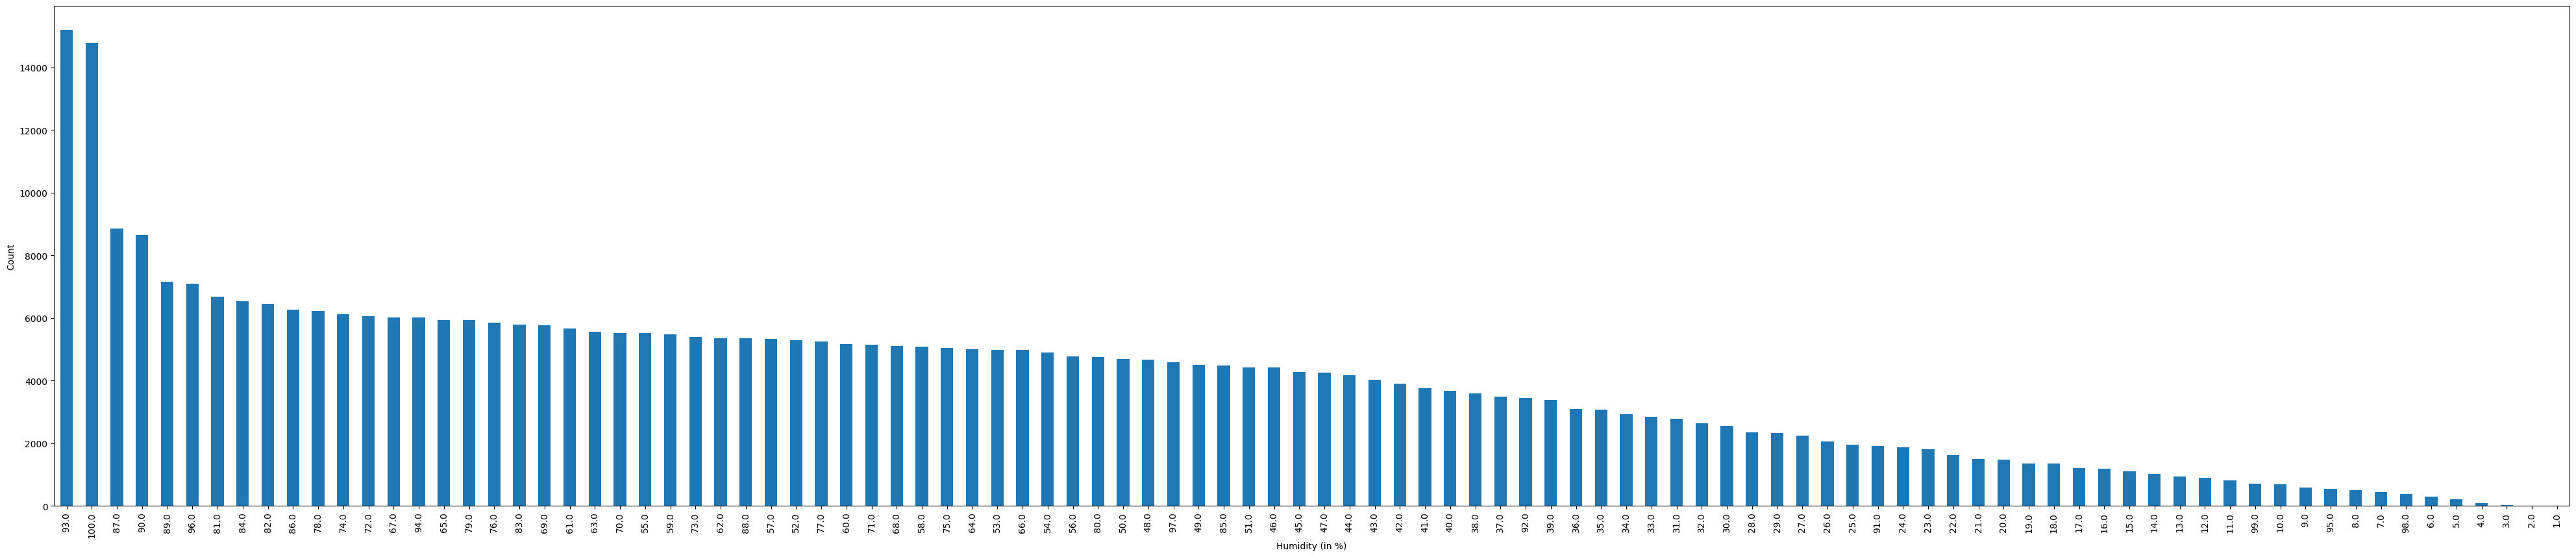

In [ ]:
# Look at the distribution of Humidity
counts = data["Humidity(%)"].value_counts()
counts.plot.bar(figsize=(50, 10))
plt.xlabel("Humidity (in %)")
plt.ylabel("Count")
((counts / len(data) * 100) < 0.05).sum(), ((counts / len(data) * 100) < 0.005).sum()

* The boxplots show that temperature and humidity are the same for severe and less-severe accidents

<Axes: title={'center': 'Temperature(F)'}, xlabel='Severity_Binary'>

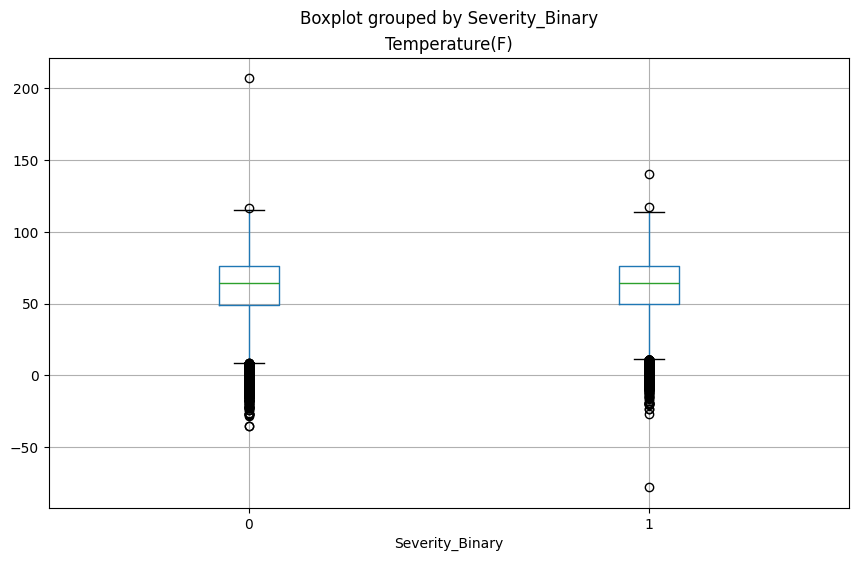

In [ ]:
# compare severity with state using a boxplot
data.boxplot(column="Temperature(F)", by="Severity_Binary", figsize=(10, 6))

<Axes: title={'center': 'Humidity(%)'}, xlabel='Severity_Binary'>

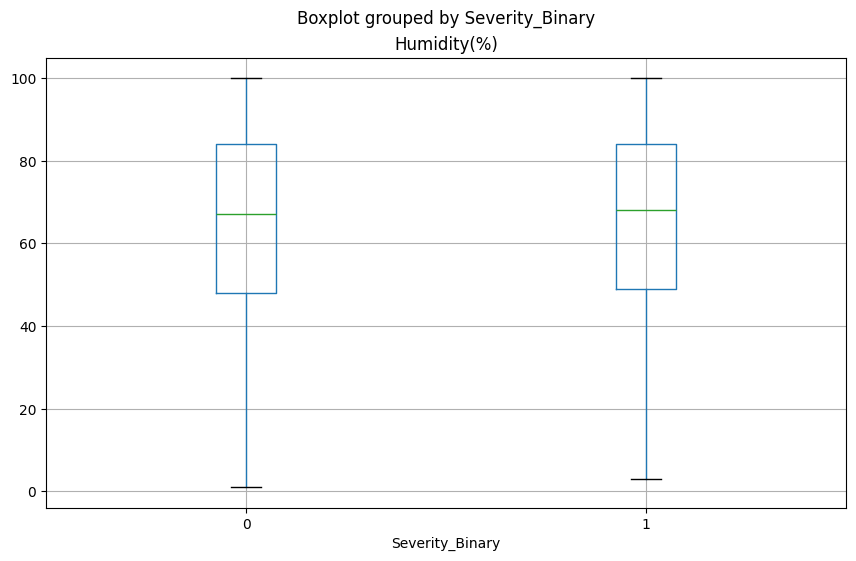

In [22]:
# Compare severity with humidity using a boxplot
data.boxplot(column="Humidity(%)", by="Severity_Binary", figsize=(10, 6))


- Barplot for severity counts by state show that more populated states contained a larger count of accidents (CA, FL, TX, NC)

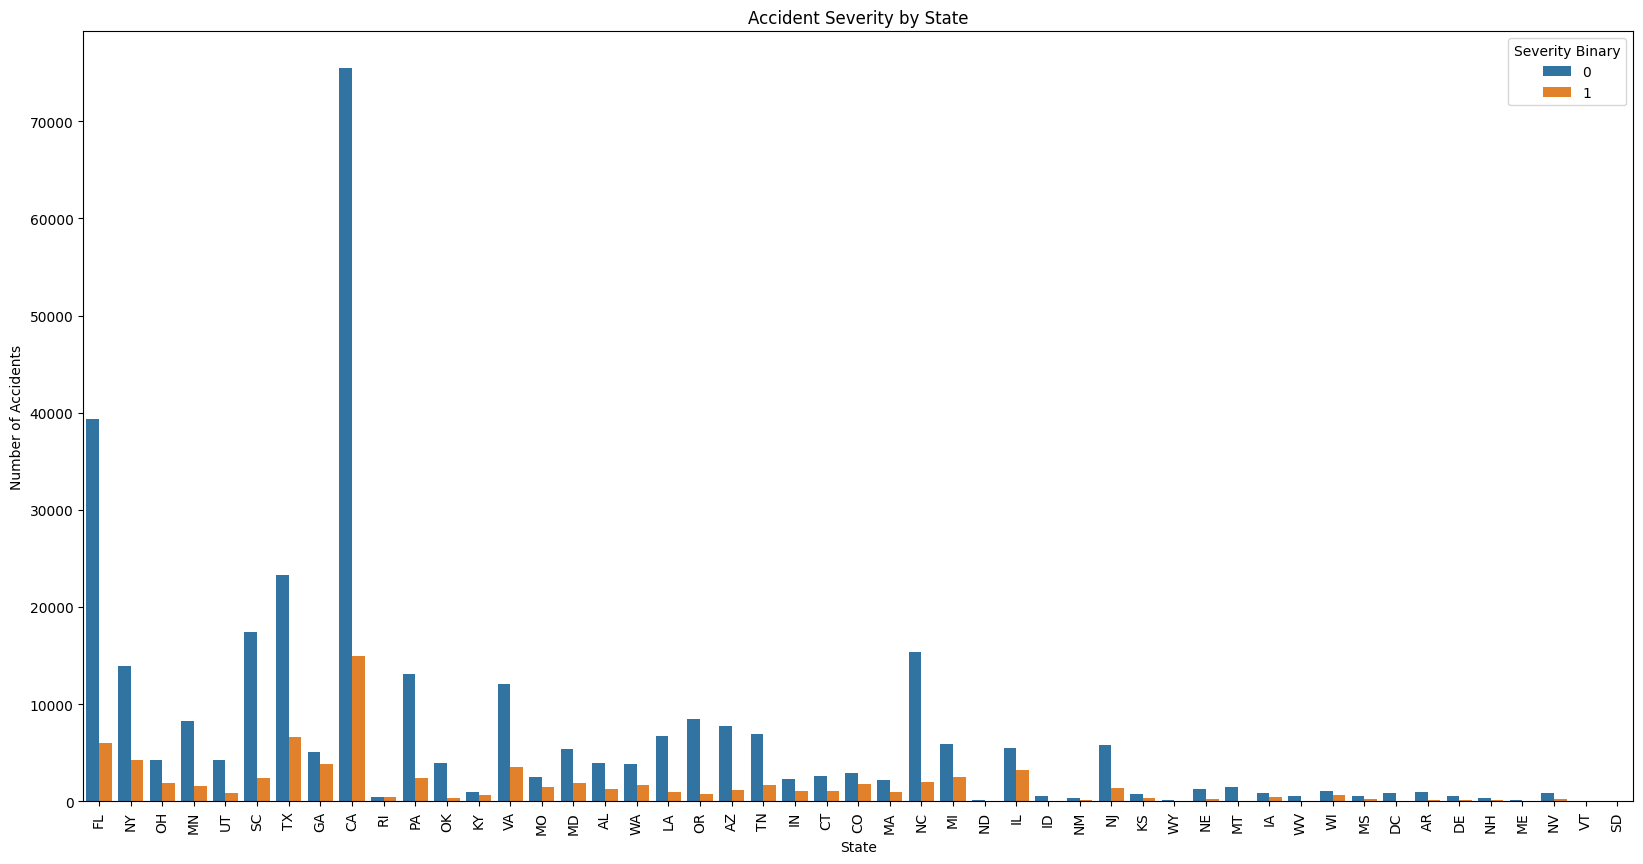

In [ ]:
plt.figure(figsize=(20, 10))
sns.countplot(data=data, x='State', hue='Severity_Binary')
plt.title('Accident Severity by State')
plt.xlabel('State')
plt.ylabel('Number of Accidents')
plt.legend(title='Severity Binary')
plt.xticks(rotation=90)
plt.show()

## Value counts Observations

Mode occurrences (most frequentlly appearing observations)
- Wind Direction had many categories that were just the same categories spelled differently (S, South, N, North, etc.)
    - Calm winds seem to be the most frequently occurring wind direction
- Start time was January 26th, 2021 at 4:16:13pm, with 18 accidents occurring at that time
- End time was November 22nd, 2021 at 8am, with 7 accidents ending at that time
- 461 counts for description of an accident that caused minimal delays/impact on traffic
- The top streets for accidents are actually highways (I-95, I-40, etc.)
- More severe accidents were associated with highly populated areas 
    - Big cities (Miami, Los Angeles)
    - More populated counties (Miami-Dade, Los Angeles)
    - Eastern timezone had most accidents, with mountain timezone having the least
    - Airport codes in populated areas (KCQT = Los Angeles)
    - Most common weather conditions seem to indicate conditions that wouldn't be hazardous for travel (clear/fair skies, partly/mostly cloudy)
    - The most observed zipcode (91761) was for Ontario, CA

In [23]:
data["Wind_Direction"].value_counts()

Wind_Direction
CALM        49835
S           21658
W           20048
SSW         19787
WNW         19350
Calm        19333
NW          19215
SW          18928
WSW         18256
SSE         18036
NNW         17255
N           15934
SE          15185
E           14451
ESE         13665
ENE         13458
NE          13403
NNE         13331
VAR         12995
South        9084
West         8644
North        7902
Variable     5957
East         5289
Name: count, dtype: int64

In [24]:
data["Start_Time"].value_counts()

Start_Time
2021-01-26 16:16:13    18
2021-02-16 06:42:43     8
2020-12-16 13:53:25     7
2021-01-26 16:17:33     7
2021-11-21 18:37:51     6
                       ..
2017-09-21 08:13:24     1
2020-01-02 11:19:31     1
2017-10-16 13:02:38     1
2019-11-23 09:23:22     1
2021-05-13 05:19:00     1
Name: count, Length: 391549, dtype: int64

In [25]:
data["End_Time"].value_counts()

End_Time
2021-11-22 08:00:00    7
2017-05-15 15:22:55    6
2020-02-08 00:00:00    5
2019-10-26 09:14:51    5
2023-03-19 16:27:27    4
                      ..
2017-09-21 08:58:04    1
2020-01-02 12:35:30    1
2017-10-16 19:02:38    1
2019-11-23 11:20:00    1
2020-05-23 22:55:21    1
Name: count, Length: 396000, dtype: int64

In [26]:
data["Description"].value_counts() 

Description
A crash has occurred causing no to minimum delays. Use caution.                                        461
Accident                                                                                               328
An unconfirmed report of a crash has been received. Use caution.                                       199
A crash has occurred use caution.                                                                      148
A crash has occurred with minimal delay to traffic. Prepare to slow or move over for worker safety.    143
                                                                                                      ... 
Right hand shoulder blocked due to accident on US-101 Northbound before Exit 389B 1st St.                1
Accident on Walnut Ave Northbound at Auburn Blvd.                                                        1
Right hand shoulder blocked due to accident on I-105 Eastbound at Exit 3 Prairie Ave.                    1
Accident on Shirley St at

In [27]:
data["Street"].value_counts()

Street
I-95 N              3984
I-95 S              3899
I-5 N               3595
I-10 E              2922
I-10 W              2812
                    ... 
SE Evergreen St        1
 W Catlett Rd          1
Robin St               1
Mallard Green Cv       1
Raleigh Pl             1
Name: count, Length: 77390, dtype: int64

In [28]:
data["City"].value_counts()

City
Miami           9716
Houston         8819
Los Angeles     8206
Charlotte       7201
Dallas          6597
                ... 
Sweet Valley       1
Barton             1
Aragon             1
Viola              1
Carrabelle         1
Name: count, Length: 9104, dtype: int64

In [29]:
data["County"].value_counts()

County
Los Angeles    27537
Miami-Dade     13014
Orange         12234
Harris          9404
Dallas          7876
               ...  
Kossuth            1
Bates              1
Kingfisher         1
Luce               1
Niobrara           1
Name: count, Length: 1570, dtype: int64

In [30]:
data["Timezone"].value_counts()

Timezone
US/Eastern     185371
US/Pacific     107061
US/Central      84685
US/Mountain     22487
Name: count, dtype: int64

In [31]:
data["Airport_Code"].value_counts()

Airport_Code
KCQT    6194
KRDU    5489
KMCJ    5227
KBNA    5120
KCLT    5068
        ... 
KXBP       1
KCNB       1
KAWH       1
KONL       1
KSET       1
Name: count, Length: 1857, dtype: int64

In [32]:
data["Weather_Condition"].value_counts()

Weather_Condition
Fair                   132746
Mostly Cloudy           52208
Cloudy                  42383
Clear                   42024
Partly Cloudy           35993
                        ...  
Sand                        1
Partial Fog / Windy         1
Light Blowing Snow          1
Low Drifting Snow           1
Sleet / Windy               1
Name: count, Length: 103, dtype: int64

In [33]:
data["Weather_Timestamp"].value_counts()

Weather_Timestamp
2022-03-13 01:53:00    68
2021-01-26 15:53:00    41
2022-03-13 01:55:00    33
2022-04-07 07:53:00    32
2022-04-13 16:53:00    31
                       ..
2019-12-26 19:51:00     1
2019-10-11 12:56:00     1
2018-04-03 15:00:00     1
2023-02-08 07:52:00     1
2019-06-28 13:50:00     1
Name: count, Length: 220943, dtype: int64

In [34]:
data["Zipcode"].value_counts()

Zipcode
91761         574
91706         518
92407         476
92507         444
33186         419
             ... 
95841-2315      1
93210-9752      1
29827-9165      1
85339-1812      1
82225           1
Name: count, Length: 107292, dtype: int64

* Sunrise/Sunset plots showed that despite the difference in quantity of accidents between day and night, the percentage of accidents was essentially the same regardless of time of day

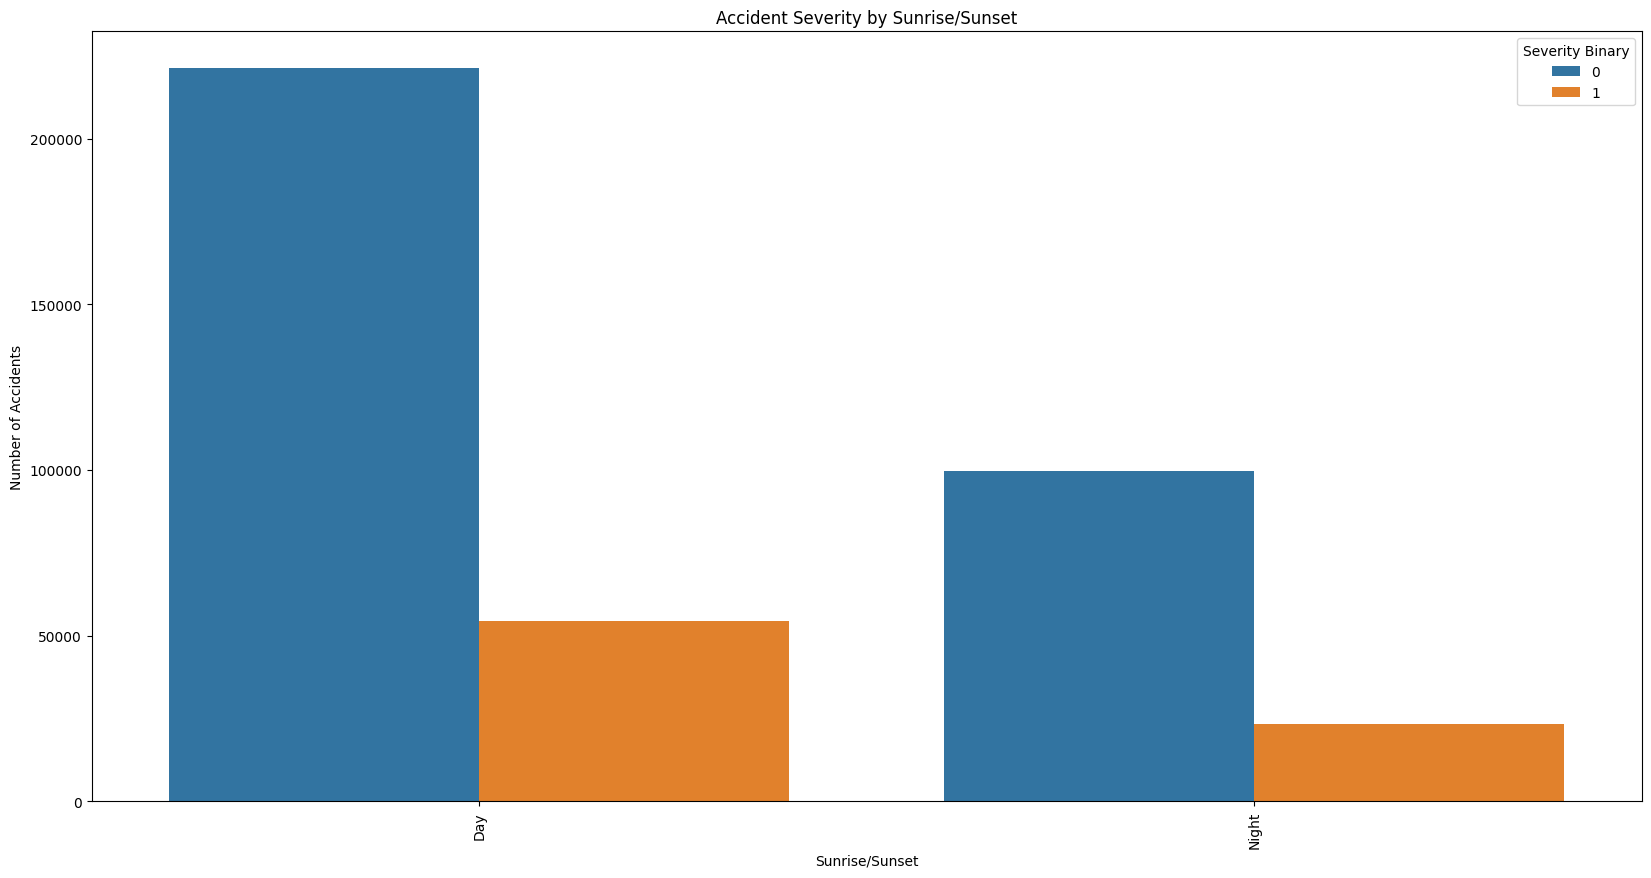

In [35]:
# view severity with sunrise_sunset
plt.figure(figsize=(20, 10))
sns.countplot(data=data, x='Sunrise_Sunset', hue='Severity_Binary')
plt.title('Accident Severity by Sunrise/Sunset')
plt.xlabel('Sunrise/Sunset')
plt.ylabel('Number of Accidents')
plt.legend(title='Severity Binary')
plt.xticks(rotation=90)
plt.show()

  Sunrise_Sunset  Severity_Binary   Count  Percentage
0            Day                0  221275   80.224422
1            Day                1   54545   19.775578
2          Night                0   99628   81.005618
3          Night                1   23361   18.994382


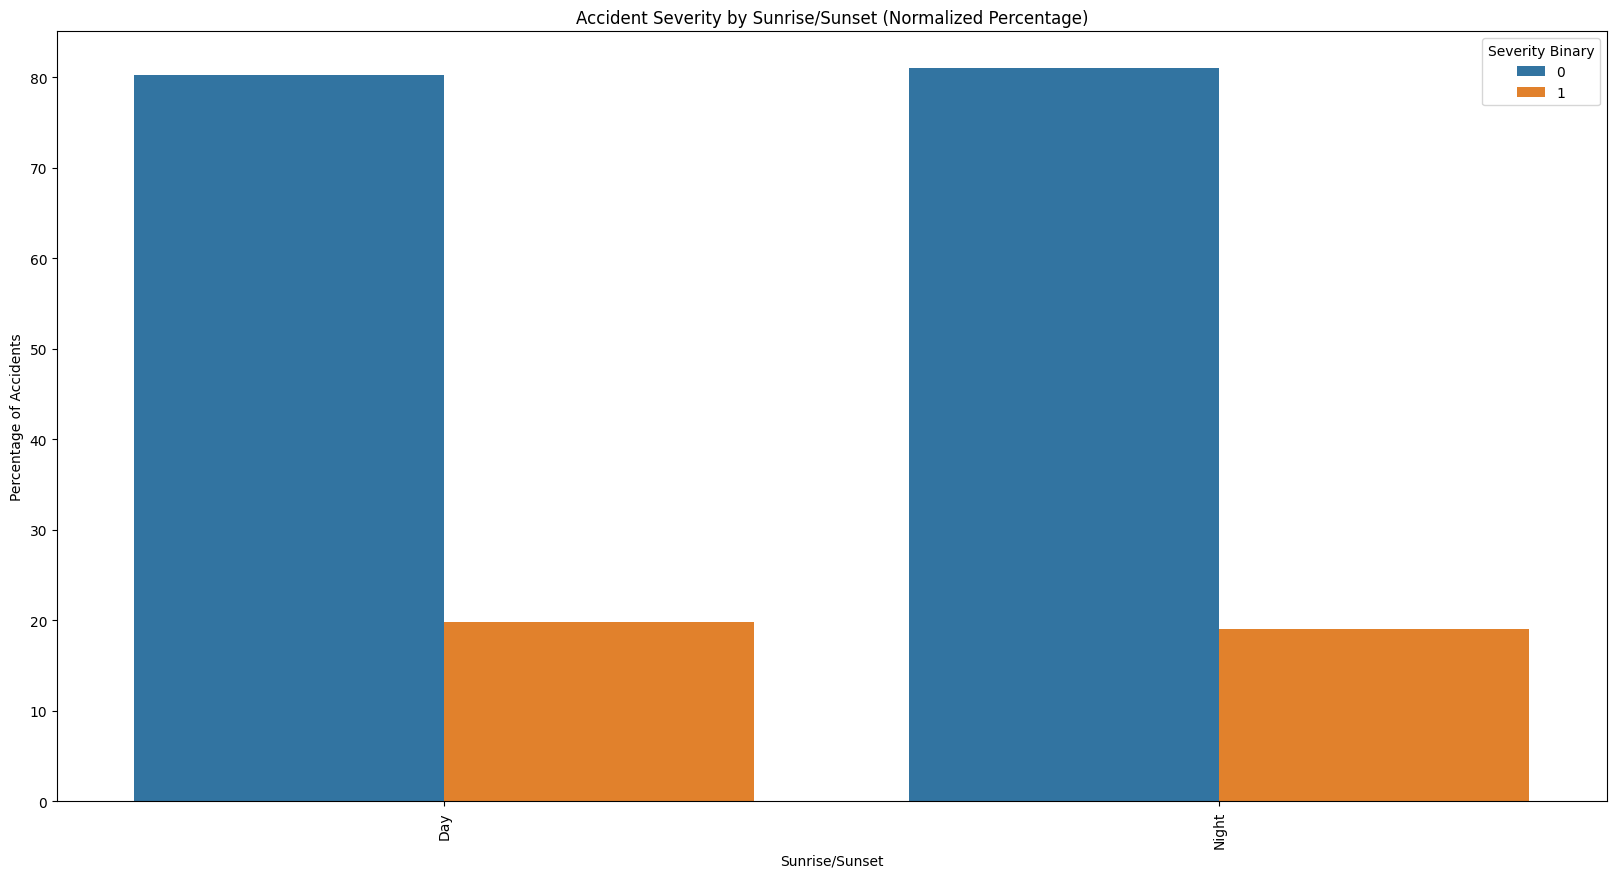

In [36]:
# Calculate the percentages
percentage_data = data.groupby(['Sunrise_Sunset', 'Severity_Binary']).size().reset_index(name='Count')
total_counts = percentage_data.groupby('Sunrise_Sunset')['Count'].transform('sum')
percentage_data['Percentage'] = percentage_data['Count'] / total_counts * 100
print(percentage_data)


# Plot the percentages
plt.figure(figsize=(20, 10))
sns.barplot(data=percentage_data, x='Sunrise_Sunset', y='Percentage', hue='Severity_Binary')
plt.title('Accident Severity by Sunrise/Sunset (Normalized Percentage)')
plt.xlabel('Sunrise/Sunset')
plt.ylabel('Percentage of Accidents')
plt.legend(title='Severity Binary')
plt.xticks(rotation=90)
plt.show()

* The traffic signal percentage plot showed that there were more severe accidents when a traffic signal wasn't present

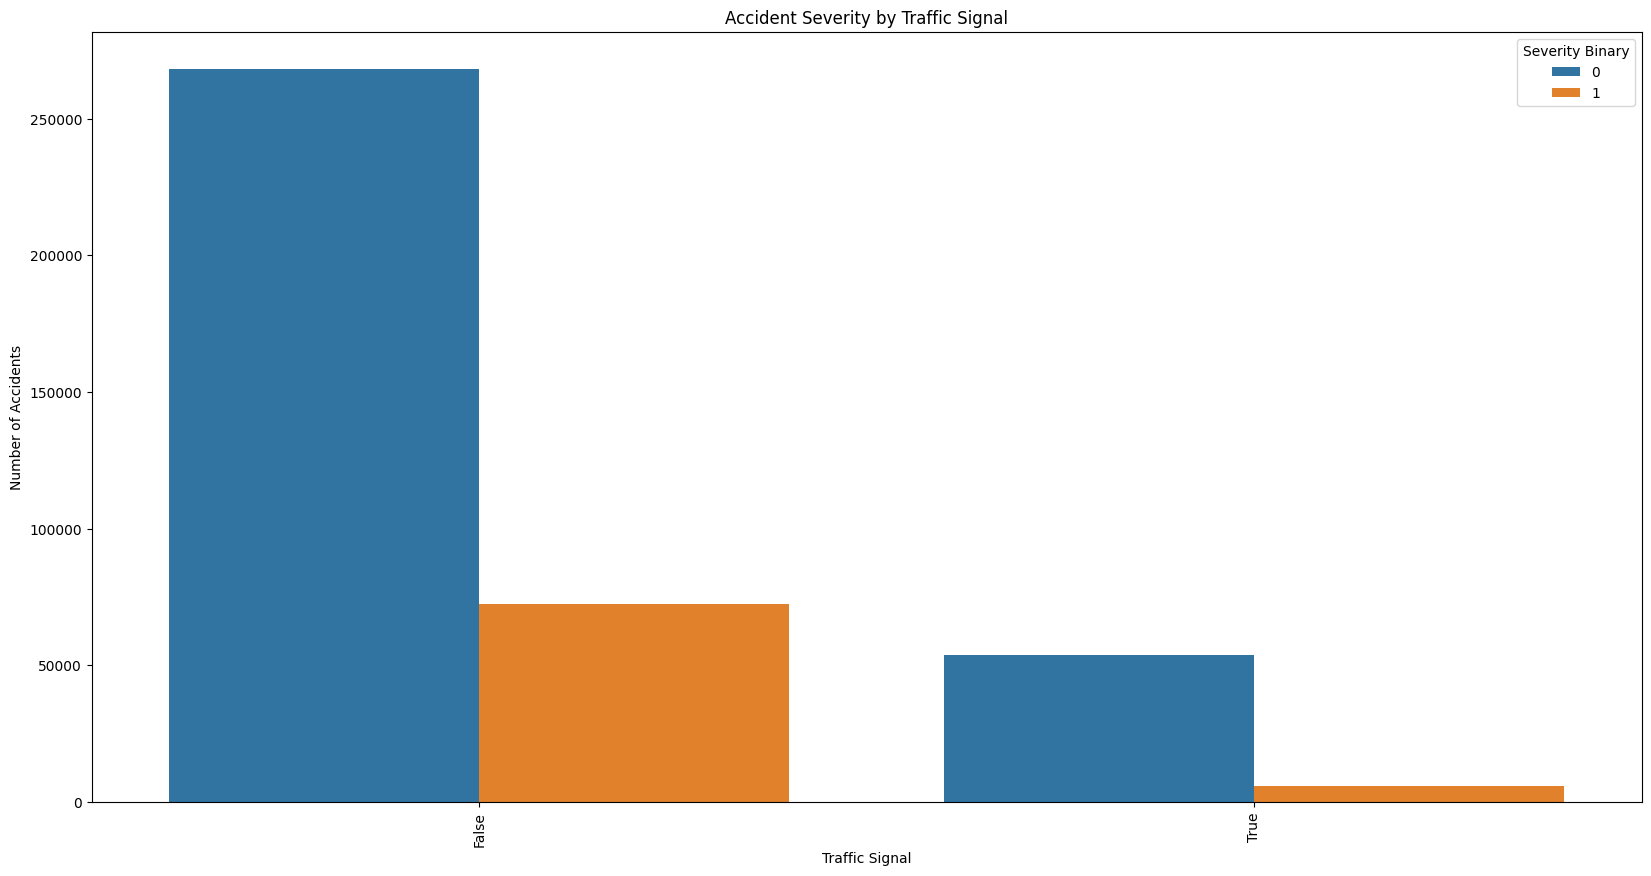

In [37]:
# Examine traffic signal with severity
plt.figure(figsize=(20, 10))
sns.countplot(data=data, x='Traffic_Signal', hue='Severity_Binary')
plt.title('Accident Severity by Traffic Signal')
plt.xlabel('Traffic Signal')
plt.ylabel('Number of Accidents')
plt.legend(title='Severity Binary')
plt.xticks(rotation=90)
plt.show()


   Traffic_Signal  Severity_Binary   Count  Percentage
0           False                0  268317   78.746302
1           False                1   72419   21.253698
2            True                0   53616   90.469762
3            True                1    5648    9.530238


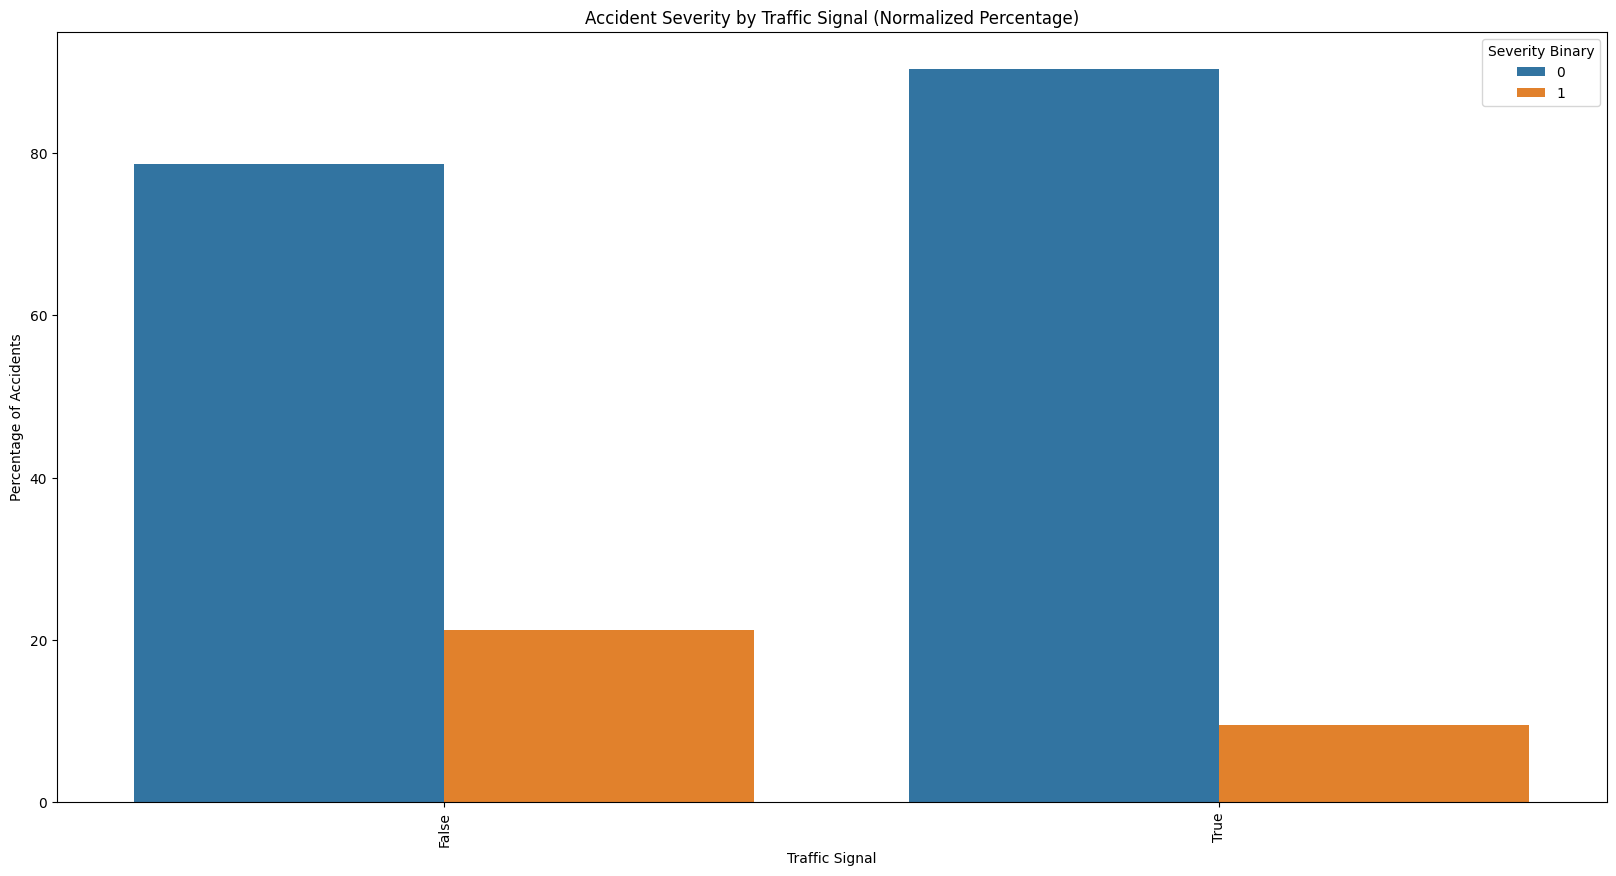

In [38]:
# Calculate the normalized percentages within each Severity_Binary category for each Traffic_Signal value
percentage_data = data.groupby(['Traffic_Signal', 'Severity_Binary']).size().reset_index(name='Count')
total_counts = percentage_data.groupby('Traffic_Signal')['Count'].transform('sum')
percentage_data['Percentage'] = percentage_data['Count'] / total_counts * 100

# Print out the percentage numbers
print(percentage_data)

# Plot the normalized percentages
plt.figure(figsize=(20, 10))
sns.barplot(data=percentage_data, x='Traffic_Signal', y='Percentage', hue='Severity_Binary')
plt.title('Accident Severity by Traffic Signal (Normalized Percentage)')
plt.xlabel('Traffic Signal')
plt.ylabel('Percentage of Accidents')
plt.legend(title='Severity Binary')
plt.xticks(rotation=90)
plt.show()

* The junction percentage plot showed that there were more severe accidents for junctions than not

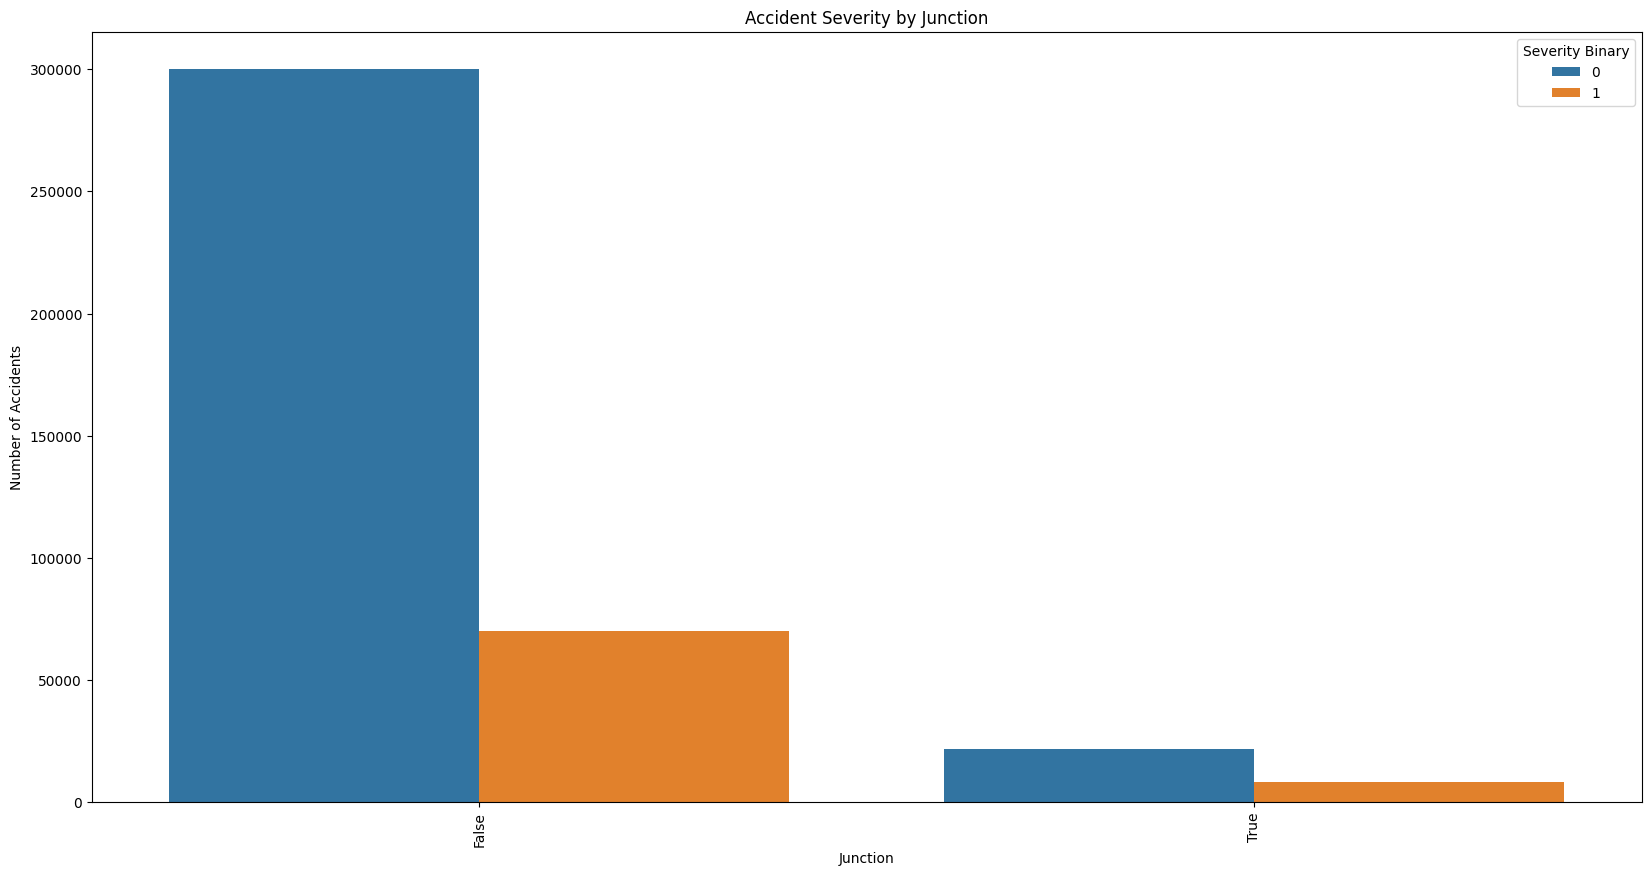

In [39]:
# Examine junction with severity
plt.figure(figsize=(20, 10))
sns.countplot(data=data, x='Junction', hue='Severity_Binary')
plt.title('Accident Severity by Junction')
plt.xlabel('Junction')
plt.ylabel('Number of Accidents')
plt.legend(title='Severity Binary')
plt.xticks(rotation=90)
plt.show()

   Junction  Severity_Binary   Count  Percentage
0     False                0  300346   81.092406
1     False                1   70029   18.907594
2      True                0   21587   72.867511
3      True                1    8038   27.132489


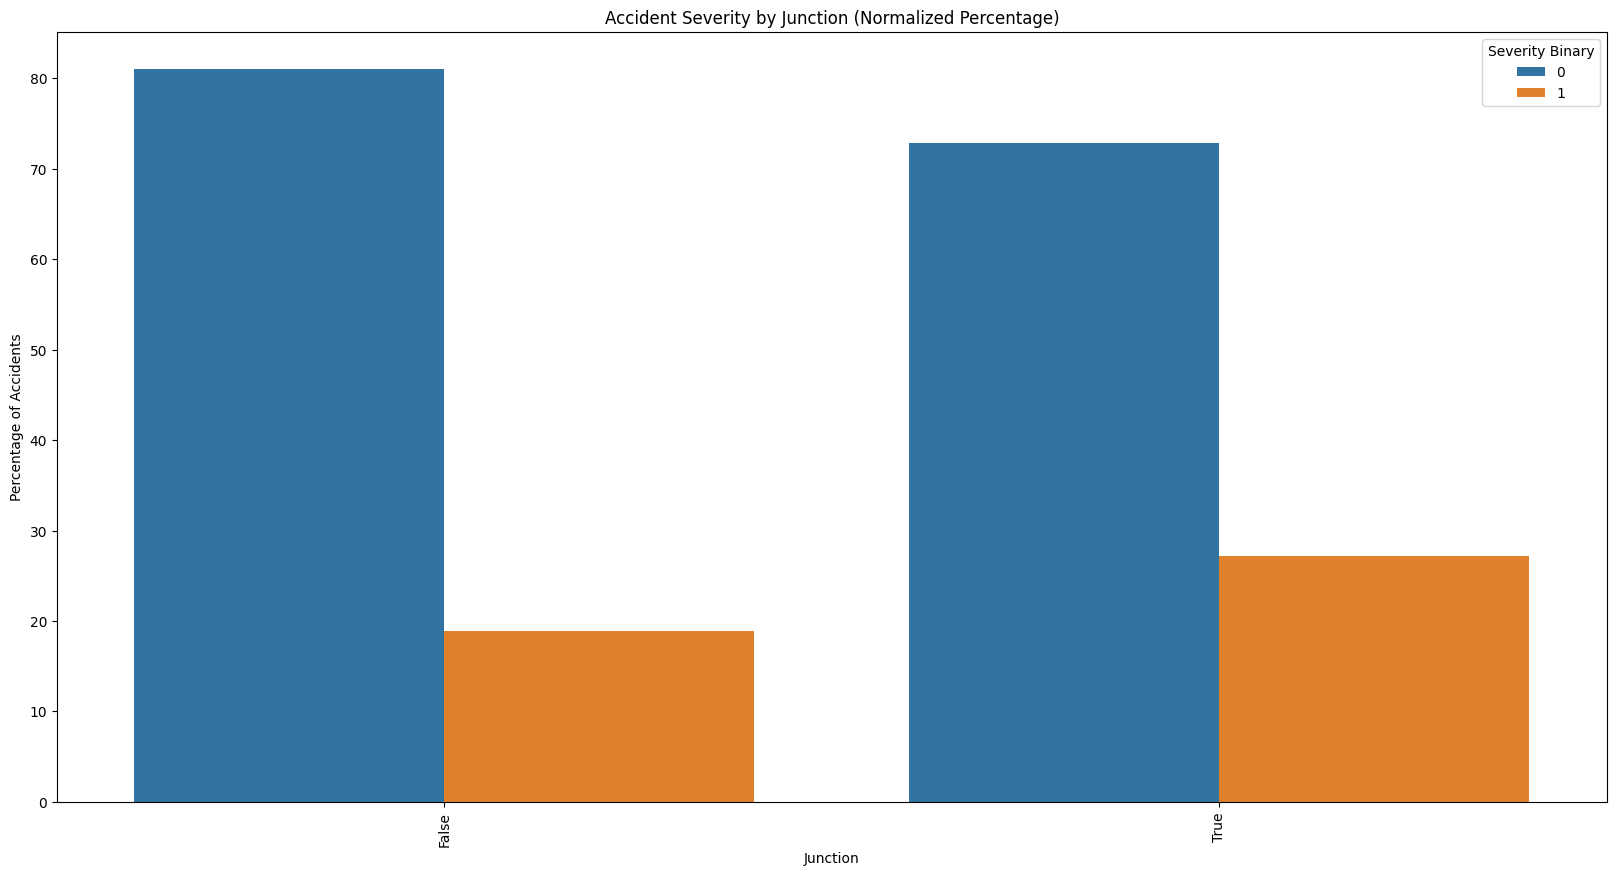

In [40]:
# Calculate the normalized percentages within each Severity_Binary category for each Junction value
percentage_data = data.groupby(['Junction', 'Severity_Binary']).size().reset_index(name='Count')
total_counts = percentage_data.groupby('Junction')['Count'].transform('sum')
percentage_data['Percentage'] = percentage_data['Count'] / total_counts * 100

# Print out the percentage numbers
print(percentage_data)

# Plot the normalized percentages
plt.figure(figsize=(20, 10))
sns.barplot(data=percentage_data, x='Junction', y='Percentage', hue='Severity_Binary')
plt.title('Accident Severity by Junction (Normalized Percentage)')
plt.xlabel('Junction')
plt.ylabel('Percentage of Accidents')
plt.legend(title='Severity Binary')
plt.xticks(rotation=90)
plt.show()

* The crossing percentage plot showed that there were more severe accidents when crossings weren't present

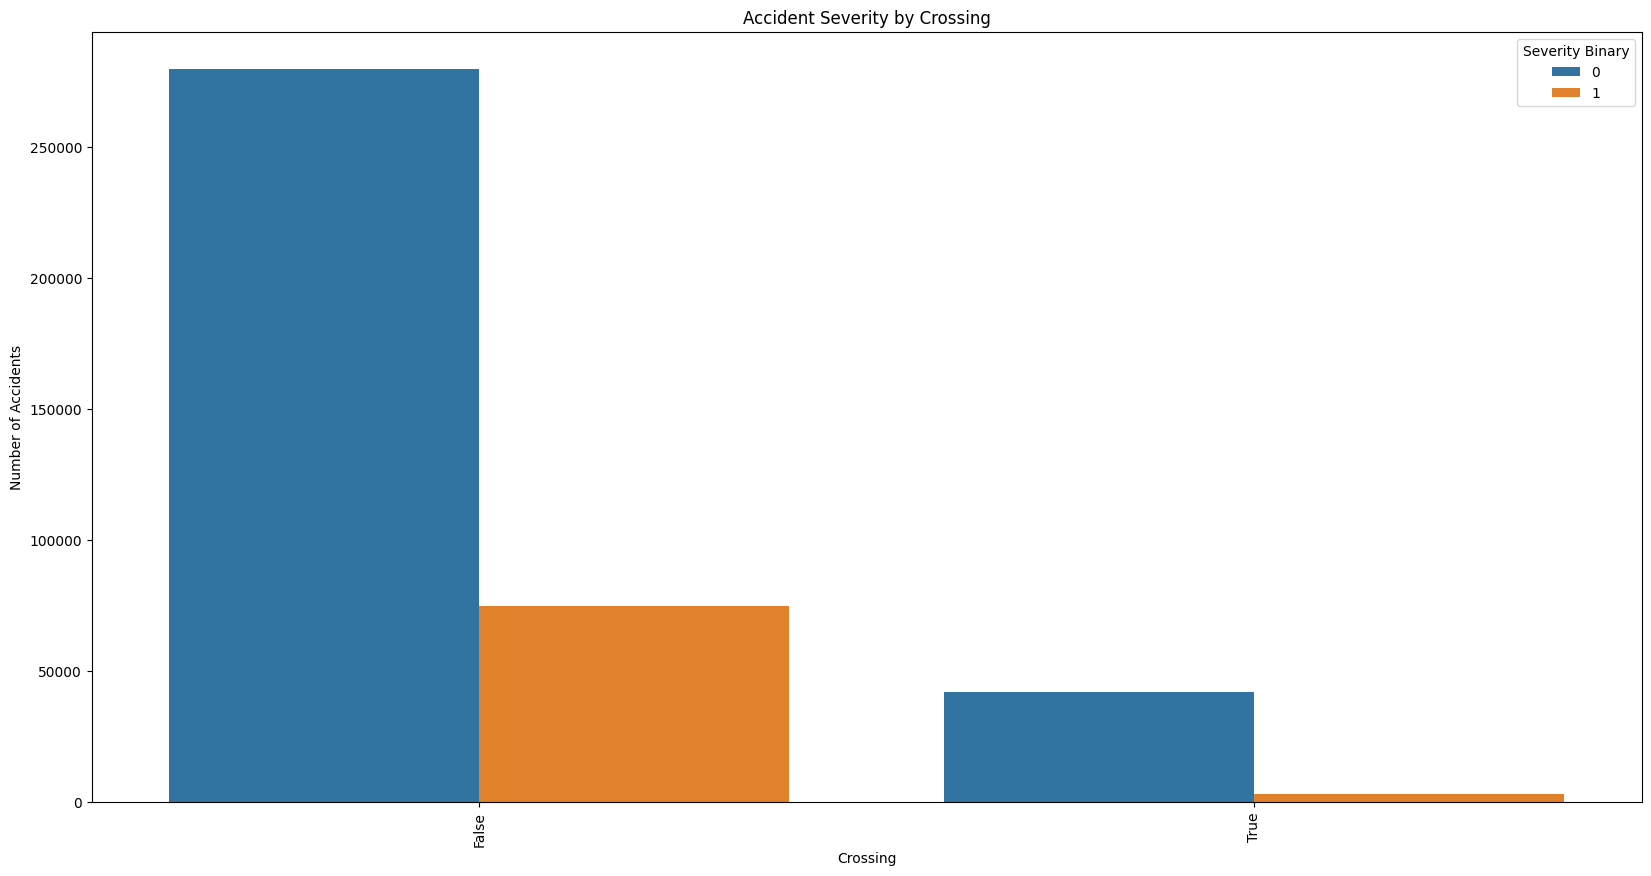

In [41]:
# Examine crossing with severity
plt.figure(figsize=(20, 10))
sns.countplot(data=data, x='Crossing', hue='Severity_Binary')
plt.title('Accident Severity by Crossing')
plt.xlabel('Crossing')
plt.ylabel('Number of Accidents')
plt.legend(title='Severity Binary')
plt.xticks(rotation=90)
plt.show()

   Crossing  Severity_Binary   Count  Percentage
0     False                0  279994   78.897552
1     False                1   74889   21.102448
2      True                0   41939   92.956092
3      True                1    3178    7.043908


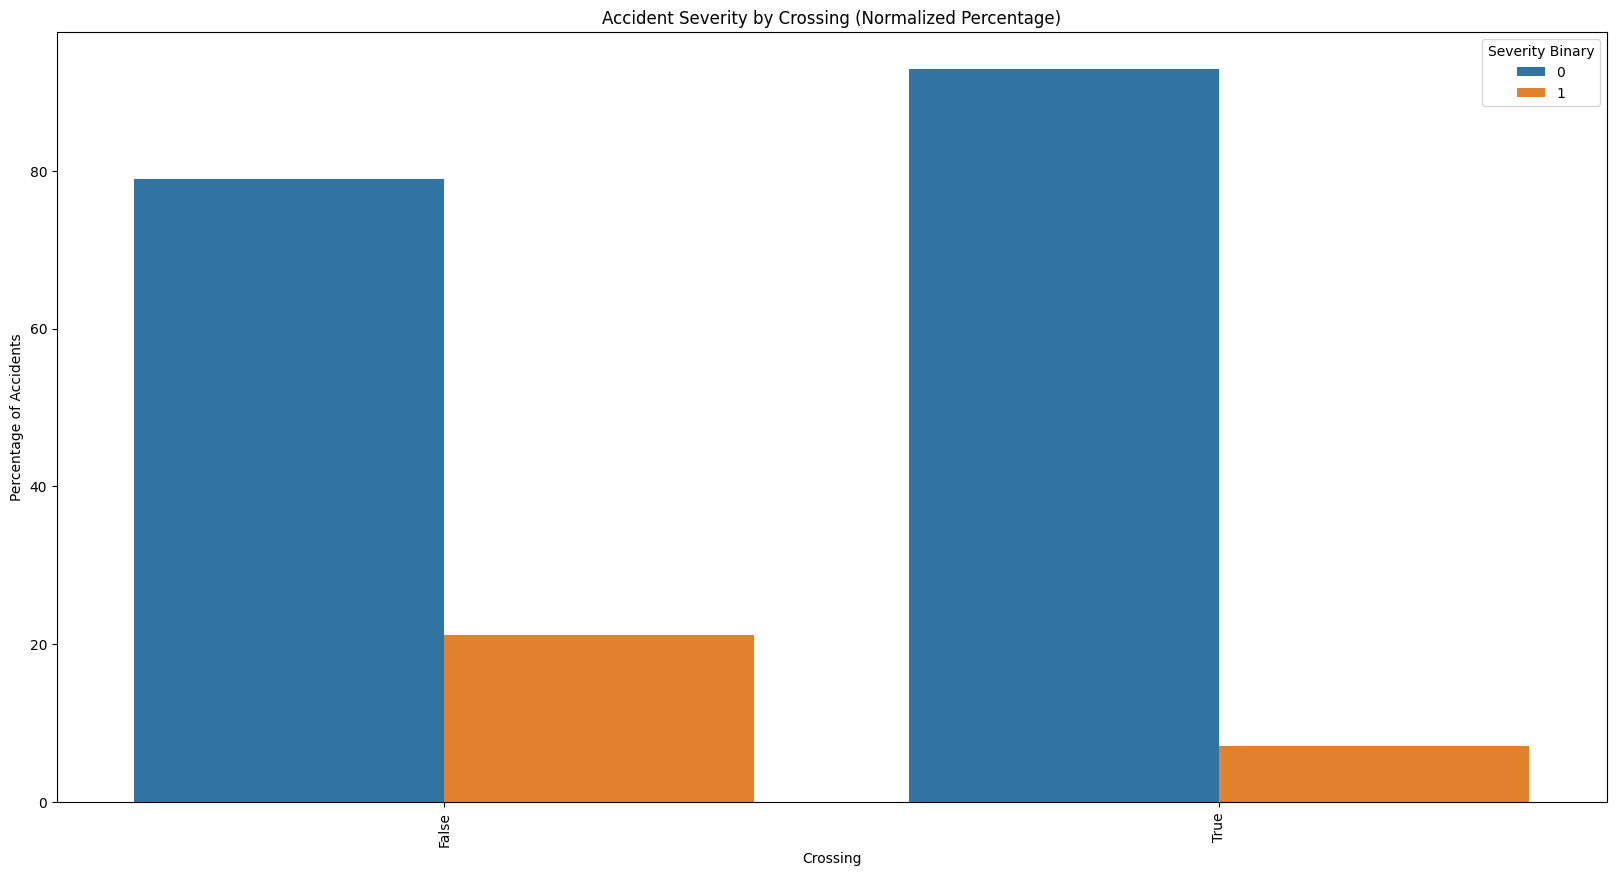

In [42]:
# Calculate the normalized percentages within each Severity_Binary category for each Crossing value
percentage_data = data.groupby(['Crossing', 'Severity_Binary']).size().reset_index(name='Count')
total_counts = percentage_data.groupby('Crossing')['Count'].transform('sum')
percentage_data['Percentage'] = percentage_data['Count'] / total_counts * 100

# Print out the percentage numbers
print(percentage_data)

# Plot the normalized percentages
plt.figure(figsize=(20, 10))
sns.barplot(data=percentage_data, x='Crossing', y='Percentage', hue='Severity_Binary')
plt.title('Accident Severity by Crossing (Normalized Percentage)')
plt.xlabel('Crossing')
plt.ylabel('Percentage of Accidents')
plt.legend(title='Severity Binary')
plt.xticks(rotation=90)
plt.show()

* Stop percentage plot showed that there were more severe accidents when a stop sign wasn't present

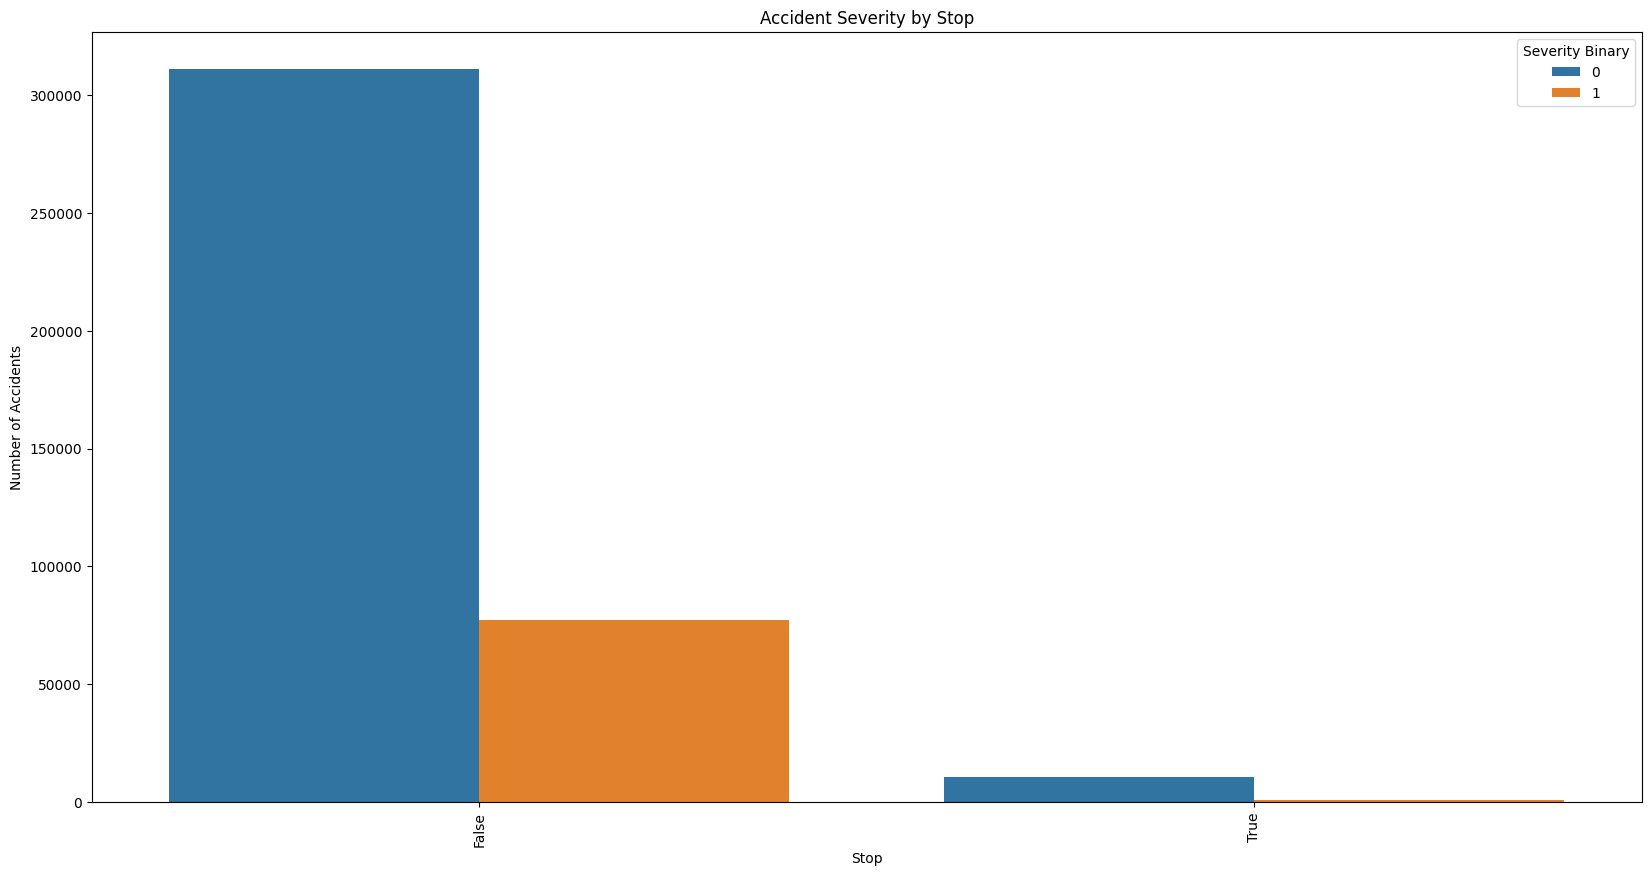

In [43]:
# Examine stop with severity
plt.figure(figsize=(20, 10))
sns.countplot(data=data, x='Stop', hue='Severity_Binary')
plt.title('Accident Severity by Stop')
plt.xlabel('Stop')
plt.ylabel('Number of Accidents')
plt.legend(title='Severity Binary')
plt.xticks(rotation=90)
plt.show()

    Stop  Severity_Binary   Count  Percentage
0  False                0  311320   80.092616
1  False                1   77380   19.907384
2   True                0   10613   93.920354
3   True                1     687    6.079646


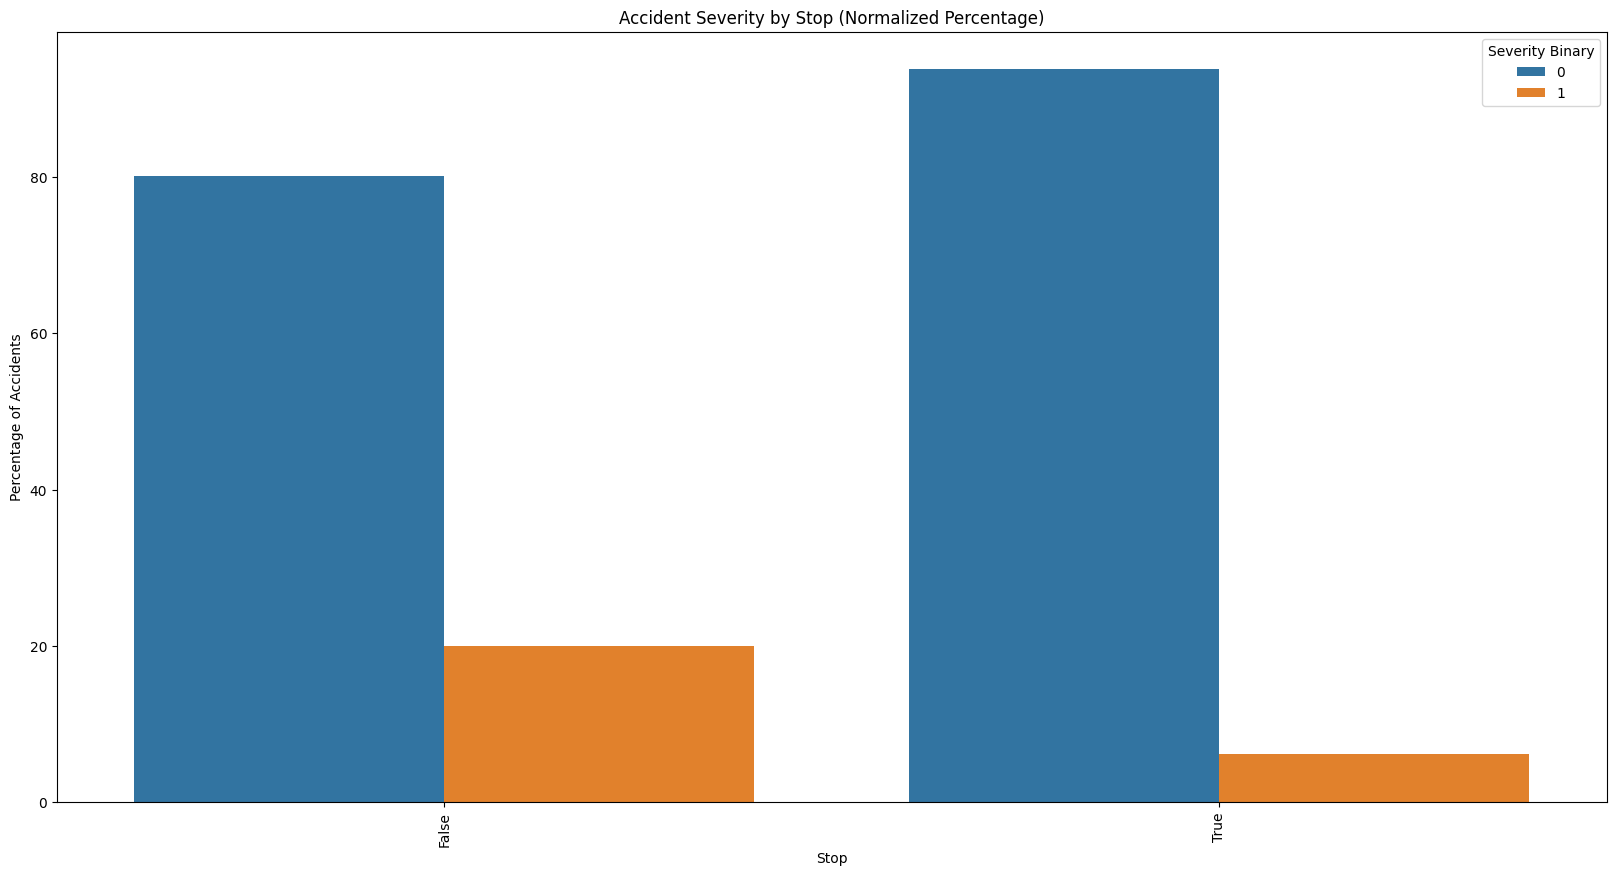

In [44]:
# Calculate the normalized percentages within each Severity_Binary category for each Stop value
percentage_data = data.groupby(['Stop', 'Severity_Binary']).size().reset_index(name='Count')
total_counts = percentage_data.groupby('Stop')['Count'].transform('sum')
percentage_data['Percentage'] = percentage_data['Count'] / total_counts * 100

# Print out the percentage numbers
print(percentage_data)

# Plot the normalized percentages
plt.figure(figsize=(20, 10))
sns.barplot(data=percentage_data, x='Stop', y='Percentage', hue='Severity_Binary')
plt.title('Accident Severity by Stop (Normalized Percentage)')
plt.xlabel('Stop')
plt.ylabel('Percentage of Accidents')
plt.legend(title='Severity Binary')
plt.xticks(rotation=90)
plt.show()

- Weak correlations observed between these features and our target label, `Severity_Binary`

- Some moderate negative correlations between Temp. and Start/End Latitude (-0.44, -0.47)

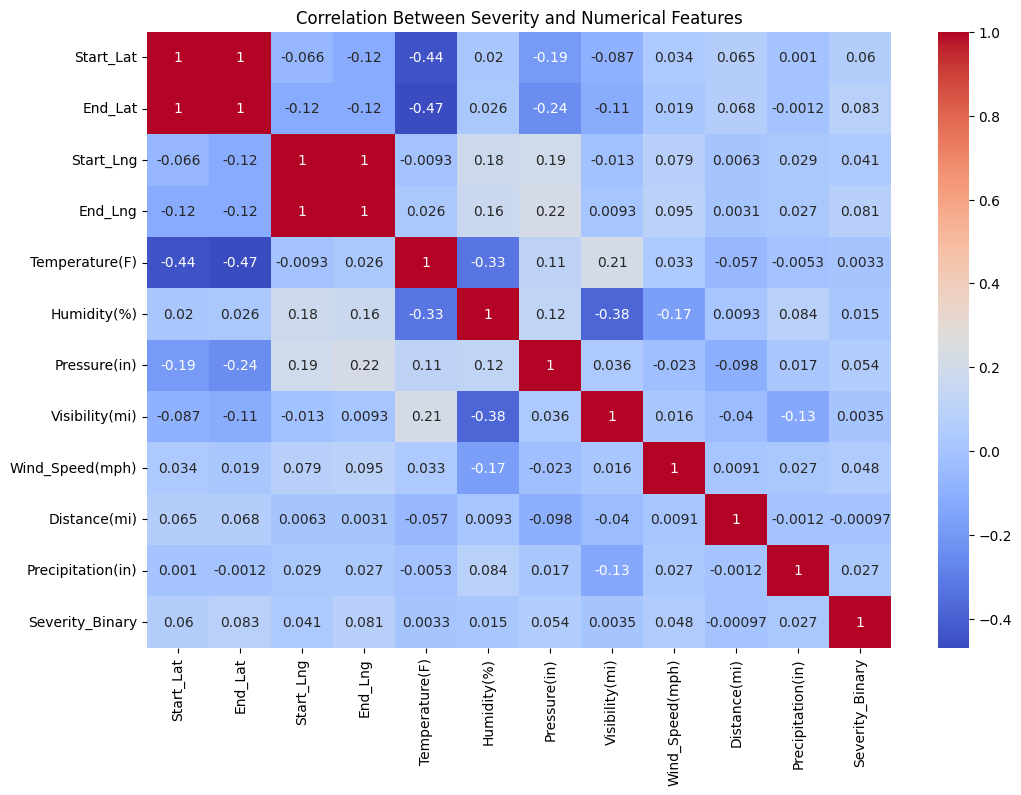

In [45]:
attrs = ["Start_Lat", "End_Lat", "Start_Lng", "End_Lng", "Temperature(F)", "Humidity(%)", "Pressure(in)", 
         "Visibility(mi)", "Wind_Speed(mph)", "Distance(mi)", "Precipitation(in)", "Severity_Binary"]
corr_matrix = data[attrs].corr()
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title("Correlation Between Severity and Numerical Features")
plt.show()

- Traffic control features were very weakly correlated with target label, except for `Crossing` and `Traffic_Signal` (-0.11)

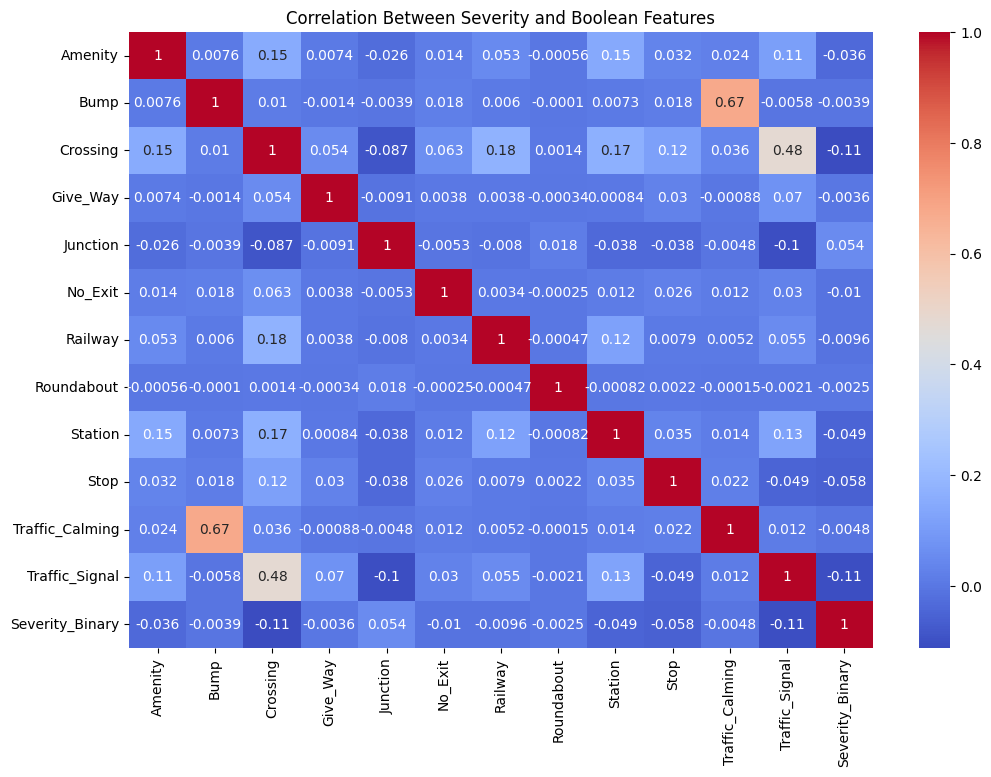

In [46]:
bool_attrs = ["Amenity", "Bump", "Crossing", "Give_Way", "Junction", "No_Exit",
          "Railway", "Roundabout", "Station", "Stop", "Traffic_Calming", "Traffic_Signal", "Severity_Binary"]

corr_matrix2 = data[bool_attrs].corr()
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix2, annot=True, cmap='coolwarm')
plt.title("Correlation Between Severity and Boolean Features")
plt.show()

- DBSCAN plot showed that many accidents occurred in more populated parts of the country
- Severe accidents seemed to in certain hotspots, seemingly following where major highways were located

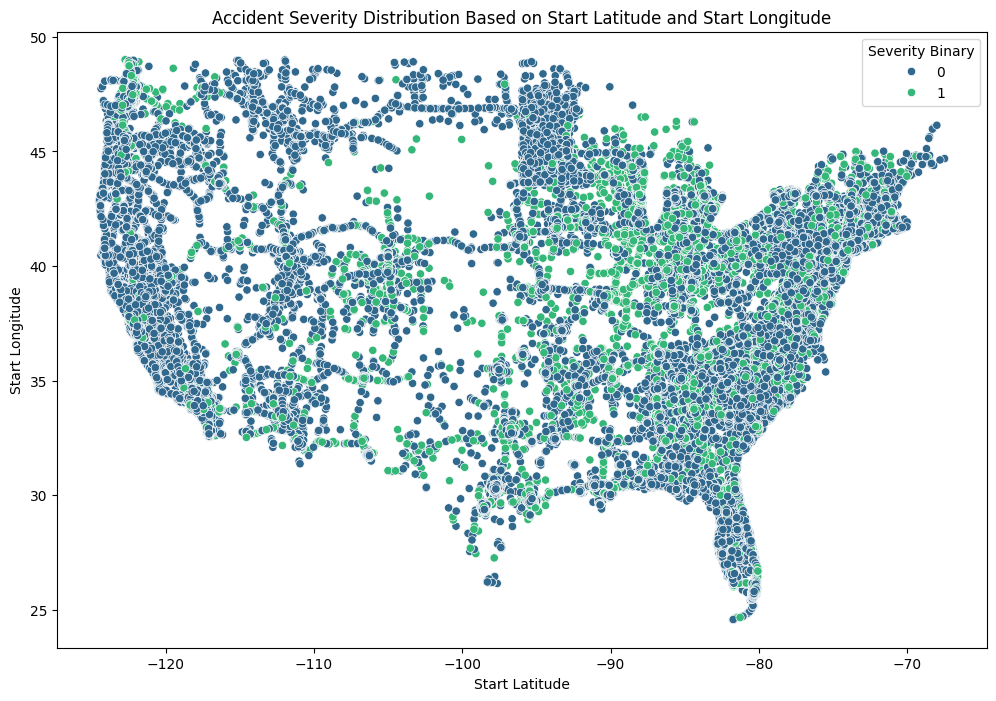

In [ ]:
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
import seaborn as sns

# Prepare the data
A = data[['Start_Lat', 'Start_Lng']]

# Apply DBSCAN
dbscan = DBSCAN(eps=0.01, min_samples=5)  
data['Cluster'] = dbscan.fit_predict(A)


# Visualize the severity within clusters
plt.figure(figsize=(12, 8))
sns.scatterplot(data=data, x='Start_Lng', y='Start_Lat', hue='Severity_Binary', palette='viridis', legend='full')
plt.title('Accident Severity Distribution Based on Start Latitude and Start Longitude')
plt.xlabel('Start Latitude')
plt.ylabel('Start Longitude')
plt.legend(title='Severity Binary')
plt.show()

- Hotspot feature was created but resulted in a weak negative correlation of -0.09

In [48]:
from sklearn.neighbors import NearestNeighbors

# Extract the coordinates of accidents with binary severity 1
accident_coords = data[data['Severity_Binary'] == 1][['Start_Lat', 'Start_Lng']].values

# Use DBSCAN to identify clusters of diseased squirrels
dbscan = DBSCAN(eps=0.0002, min_samples=2)
accident_clusters = dbscan.fit_predict(accident_coords)

# Get the coordinates of the cluster centers
cluster_centers = []
for cluster in set(accident_clusters):
    if cluster != -1:  # Ignore noise points
        cluster_points = accident_coords[accident_clusters == cluster]
        cluster_center = cluster_points.mean(axis=0)
        cluster_centers.append(cluster_center)

cluster_centers = np.array(cluster_centers)

# Calculate the distance from each accident to the nearest severe accident cluster
nbrs = NearestNeighbors(n_neighbors=1).fit(cluster_centers)
distances, _ = nbrs.kneighbors(data[['Start_Lat', 'Start_Lng']].values)

# Create the 'hotspots' feature based on the distances
data['hotspots'] = distances

<Axes: >

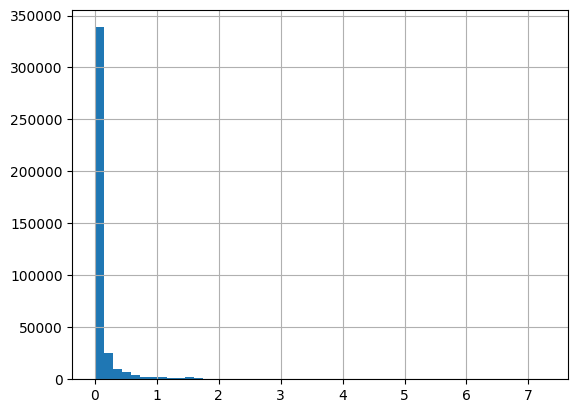

In [49]:
# small hotspot values indicate that the accident is close to a severe accident cluster
data['hotspots'].hist(bins=50)

In [50]:
corr_hotspots = data['hotspots'].corr(data['Severity_Binary'])
corr_hotspots

np.float64(-0.09074203748768916)

- DBScan for End Lat/Longitudes was also conducted, similar to Start ones but less points since they contained missing data

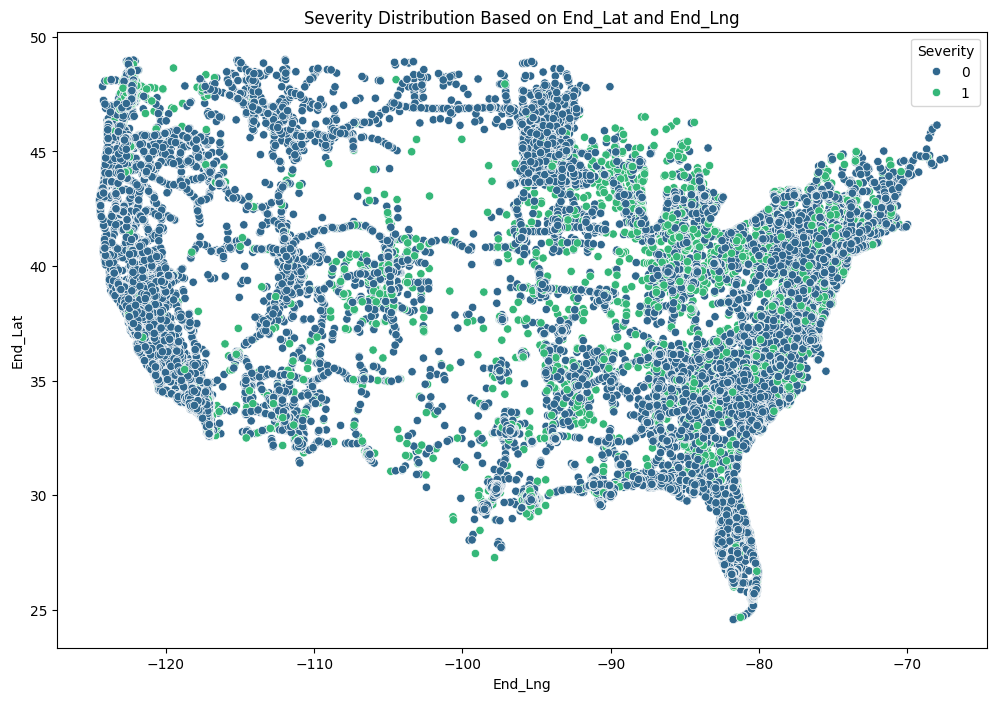

In [51]:
# Prepare the data
Z = data[['End_Lat', 'End_Lng']]

# Drop rows with NaN values in the relevant columns
Z_clean = Z.dropna()

# Apply DBSCAN
dbscan = DBSCAN(eps=0.01, min_samples=5)  
data_clean = data.loc[Z_clean.index]  
data_clean['Cluster'] = dbscan.fit_predict(Z_clean)


# Visualize the severity within clusters
plt.figure(figsize=(12, 8))
sns.scatterplot(data=data, x='End_Lng', y='End_Lat', hue='Severity_Binary', palette='viridis', legend='full')
plt.title('Severity Distribution Based on End_Lat and End_Lng')
plt.xlabel('End_Lng')
plt.ylabel('End_Lat')
plt.legend(title='Severity')
plt.show()

- Extracting Start Time Features
    - Moderately weak negative correlation (-0.26) between target label and `Start_Year`

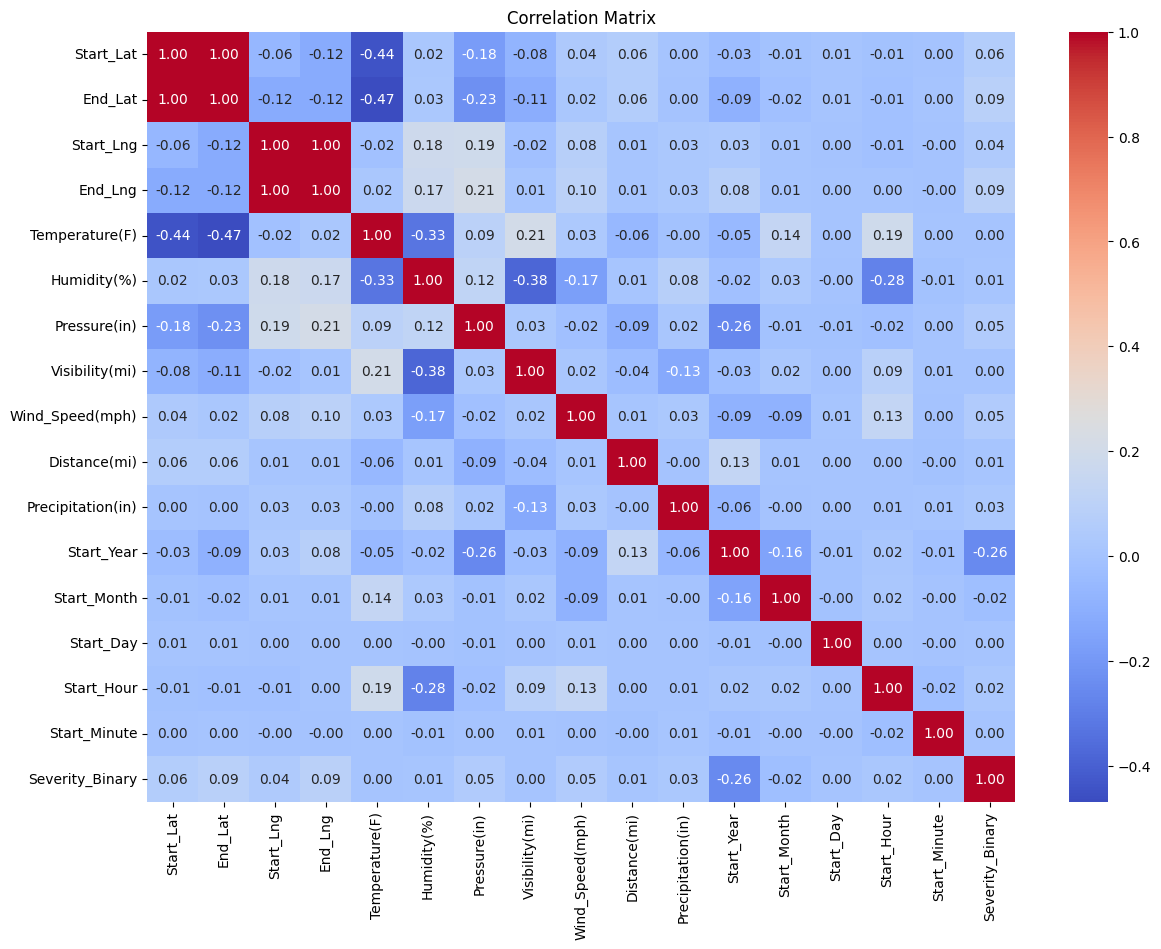

In [52]:
# Convert 'Start_Time' to datetime if it's not already
data['Start_Time'] = pd.to_datetime(data['Start_Time'], errors='coerce')

# Drop rows with NaT values in 'Start_Time' after conversion
data = data.dropna(subset=['Start_Time'])

# Extract numerical features from the datetime column
data['Start_Year'] = data['Start_Time'].dt.year
data['Start_Month'] = data['Start_Time'].dt.month
data['Start_Day'] = data['Start_Time'].dt.day
data['Start_Hour'] = data['Start_Time'].dt.hour
data['Start_Minute'] = data['Start_Time'].dt.minute

# Select the features for the correlation matrix
time_attrs = ["Start_Lat", "End_Lat", "Start_Lng", "End_Lng", "Temperature(F)", "Humidity(%)", "Pressure(in)", 
         "Visibility(mi)", "Wind_Speed(mph)", "Distance(mi)", "Precipitation(in)", "Start_Year", "Start_Month", "Start_Day", 
         "Start_Hour", "Start_Minute", "Severity_Binary"]

# Create the correlation matrix
corr_time = data[time_attrs].corr()

# Plot the heatmap
plt.figure(figsize=(14, 10))
sns.heatmap(corr_time, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

- Extracted End Time Features
    - Moderately weak negative correlation (-0.26) between target label and `End_Year`

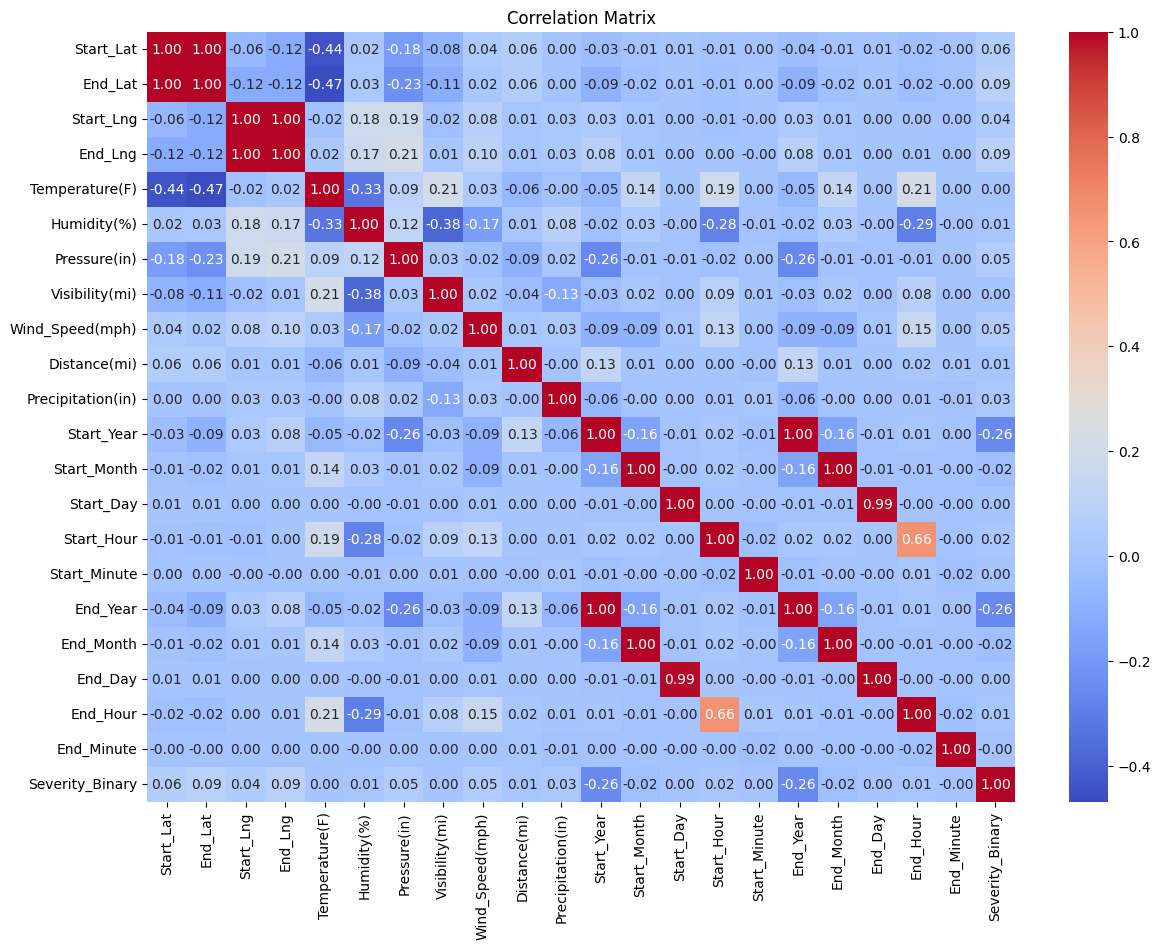

In [53]:
# Convert 'End_Time' to datetime if it's not already
data['End_Time'] = pd.to_datetime(data['End_Time'], errors='coerce')

# Drop rows with NaT values in 'Start_Time' after conversion
data = data.dropna(subset=['End_Time'])

# Extract numerical features from the datetime column
data['End_Year'] = data['End_Time'].dt.year
data['End_Month'] = data['End_Time'].dt.month
data['End_Day'] = data['End_Time'].dt.day
data['End_Hour'] = data['End_Time'].dt.hour
data['End_Minute'] = data['End_Time'].dt.minute

# Select the features for the correlation matrix
SE_attrs = ["Start_Lat", "End_Lat", "Start_Lng", "End_Lng", "Temperature(F)", "Humidity(%)", "Pressure(in)", 
         "Visibility(mi)", "Wind_Speed(mph)", "Distance(mi)", "Precipitation(in)", "Start_Year", "Start_Month", "Start_Day", 
         "Start_Hour", "Start_Minute", "End_Year", "End_Month", "End_Day", "End_Hour", "End_Minute","Severity_Binary"]

# Create the correlation matrix
corr_SE = data[SE_attrs].corr()

# Plot the heatmap
plt.figure(figsize=(14, 10))
sns.heatmap(corr_SE, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

- Creating duration feature from start time and end time

In [54]:
# create accident duration by simply subtracting the start time from the end time
data['duration'] = data['End_Time'] - data['Start_Time']

In [55]:
data["duration"].describe()

count                       361589
mean     0 days 06:31:50.102254216
std      8 days 15:56:30.901387359
min                0 days 00:02:30
25%                0 days 00:30:00
50%                0 days 01:02:36
75%                0 days 02:02:41
max             1553 days 00:10:38
Name: duration, dtype: object

In [56]:
data["duration"].value_counts()

duration
0 days 06:00:00    19140
0 days 00:30:00     5900
0 days 00:45:00     3593
0 days 01:00:00     3010
0 days 04:00:00     2941
                   ...  
0 days 05:01:33        1
0 days 09:13:51        1
0 days 04:48:32        1
0 days 04:05:55        1
0 days 02:57:41        1
Name: count, Length: 24161, dtype: int64

- Converting duration feature into a useable format by getting the total seconds

In [57]:
# Convert the duration to a numerical value (e.g., total seconds)
data['duration_seconds'] = data['duration'].dt.total_seconds()

In [58]:
data["duration_seconds"].describe()

count    3.615890e+05
mean     2.351010e+04
std      7.485909e+05
min      1.500000e+02
25%      1.800000e+03
50%      3.756000e+03
75%      7.361000e+03
max      1.341798e+08
Name: duration_seconds, dtype: float64

In [59]:
data["duration_seconds"].value_counts()

duration_seconds
21600.0    19140
1800.0      5900
2700.0      3593
3600.0      3010
14400.0     2941
           ...  
18093.0        1
33231.0        1
17312.0        1
14755.0        1
10661.0        1
Name: count, Length: 24161, dtype: int64

Text(0, 0.5, 'Count')

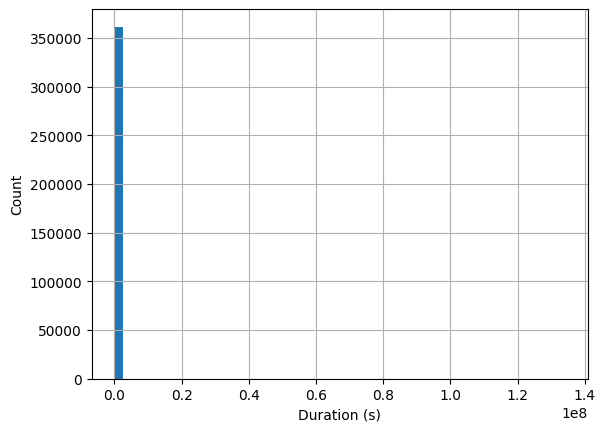

In [60]:
data["duration_seconds"].hist(bins=50)
plt.xlabel("Duration (s)")
plt.ylabel("Count")

- Observing removal of outliers for the duration (in seconds)

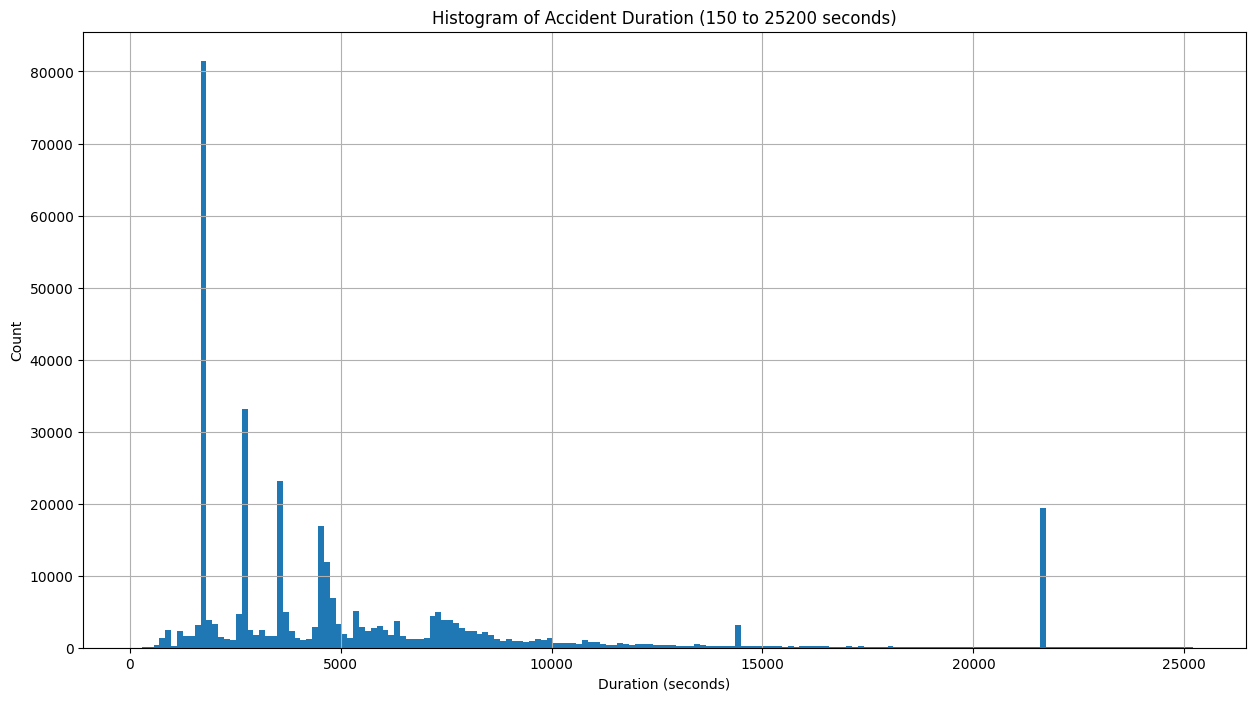

Percentage of durations between 150 and 25200 seconds: 97.56%


In [61]:
duration_seconds = data["duration_seconds"]

# Filter duration between 150 seconds and 25200 (7 hours) and plot the histogram
duration_seconds[(duration_seconds >= 150) & (duration_seconds <= 25200)].hist(bins=180, figsize=(15, 8))
plt.xlabel("Duration (seconds)")
plt.ylabel("Count")
plt.title("Histogram of Accident Duration (150 to 25200 seconds)")
plt.show()

# Calculate and print the percentages
percentage_within_range = ((duration_seconds > 150) & (duration_seconds < 25200)).sum() / len(data) * 100

print(f"Percentage of durations between 150 and 25200 seconds: {percentage_within_range:.2f}%")

- Distribution improves with log of the removed outliers data

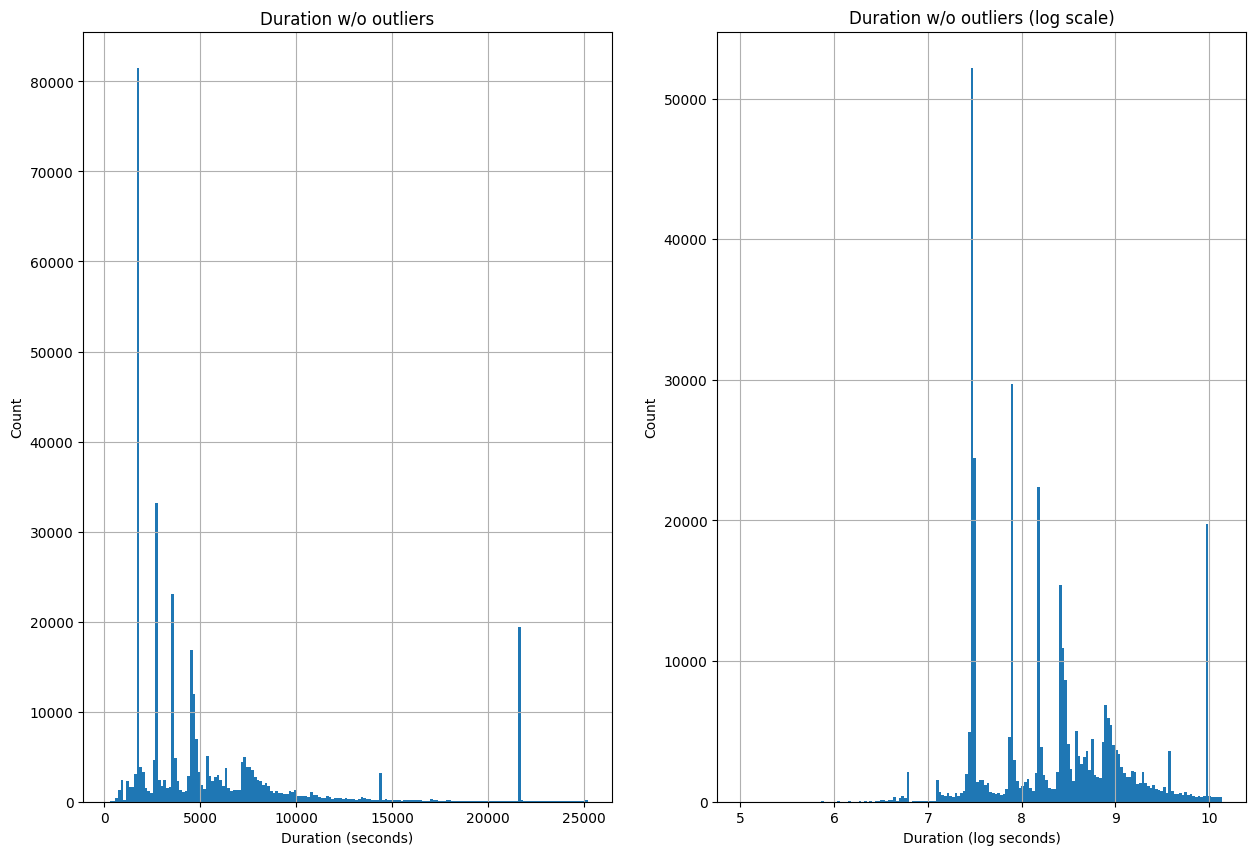

In [62]:
# Filter the data to remove outliers
filtered_duration = duration_seconds[(duration_seconds >= 150) & (duration_seconds <= 25200)]

plt.figure(figsize=(15, 10))

# Plot the original duration histogram without outliers
plt.subplot(1, 2, 1)
filtered_duration.hist(bins=180)
plt.title("Duration w/o outliers")
plt.xlabel("Duration (seconds)")
plt.ylabel("Count")

# Plot the log-transformed duration histogram without outliers
plt.subplot(1, 2, 2)
np.log(filtered_duration).hist(bins=180)
plt.title("Duration w/o outliers (log scale)")
plt.xlabel("Duration (log seconds)")
plt.ylabel("Count")

plt.show()

## Exploring Log of Distance

- Log and double log of distance did not seem to improve the distribution of distance feature
- Maintaining the outliers for this feature as they could be signficant (distance equates to the length of the road affected by the accident = length of traffic jam)

<Axes: >

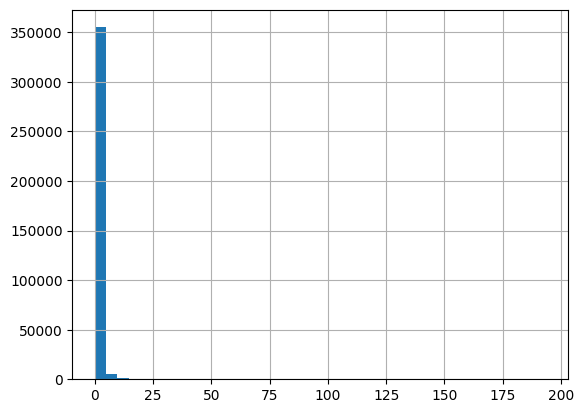

In [63]:
data["Distance(mi)"].hist(bins=40)

In [64]:
data["Distance(mi)"].describe()

count    361589.000000
mean          0.517657
std           1.744854
min           0.000000
25%           0.000000
50%           0.010000
75%           0.388000
max         193.479996
Name: Distance(mi), dtype: float64

In [65]:
data["log_distance"] = np.log1p(data["Distance(mi)"])

<Axes: >

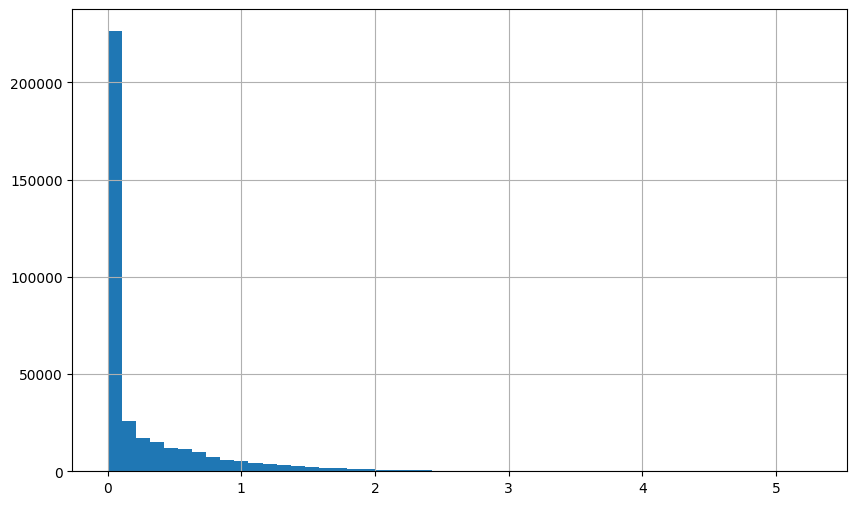

In [66]:
data["log_distance"].hist(bins=50, figsize=(10, 6))

<Axes: >

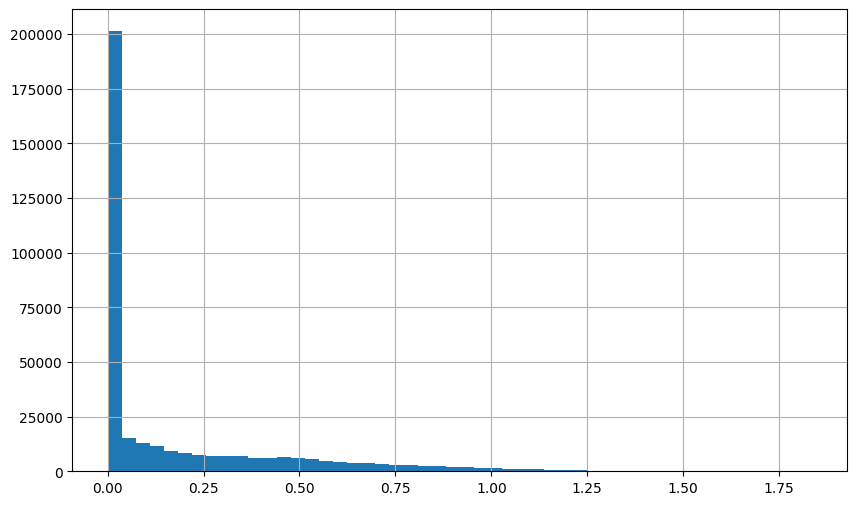

In [67]:
data["log_log_distance"] = np.log1p(data["log_distance"])
data["log_log_distance"].hist(bins=50, figsize=(10, 6))

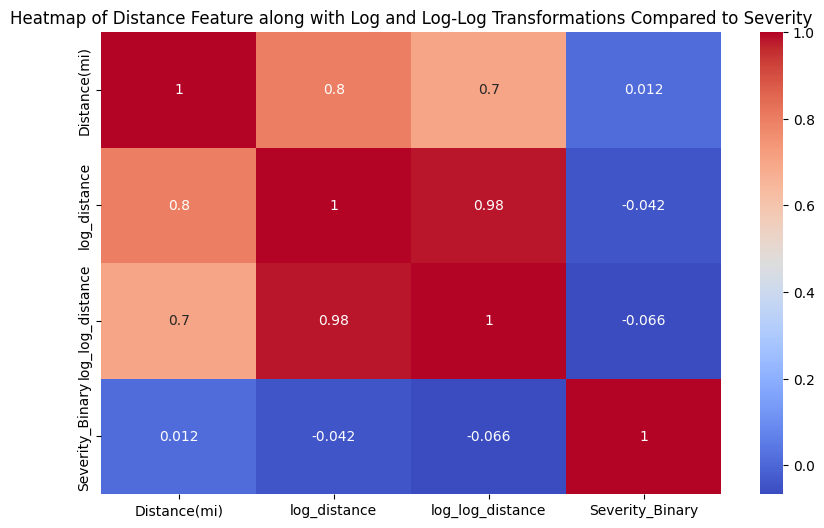

In [68]:
log_corr = data[["Distance(mi)", "log_distance", "log_log_distance", "Severity_Binary"]].corr()

# plot the heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(log_corr, annot=True, cmap='coolwarm')
plt.title("Heatmap of Distance Feature along with Log and Log-Log Transformations Compared to Severity")
plt.show()

## Exploring log of Humidity

- `Humidity` seems to have capping occur at ~100
- Log and double log of humidity did not help the capping issue

<Axes: >

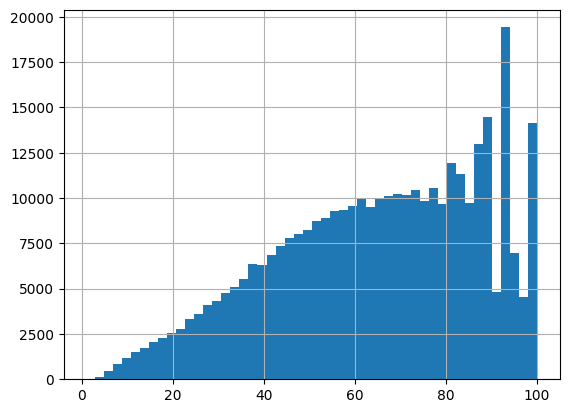

In [69]:
data["Humidity(%)"].hist(bins=50)

<Axes: >

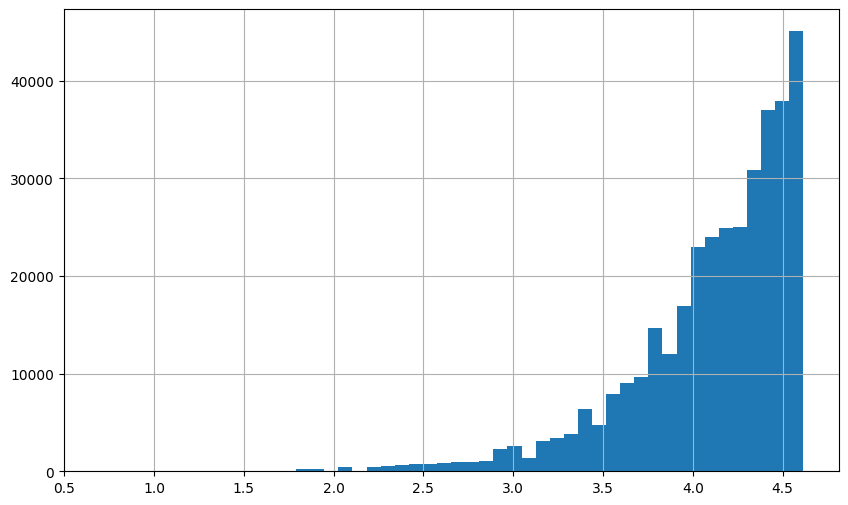

In [70]:
data["log_humidity"] = np.log1p(data["Humidity(%)"])
data["log_humidity"].hist(bins=50, figsize=(10, 6))

<Axes: >

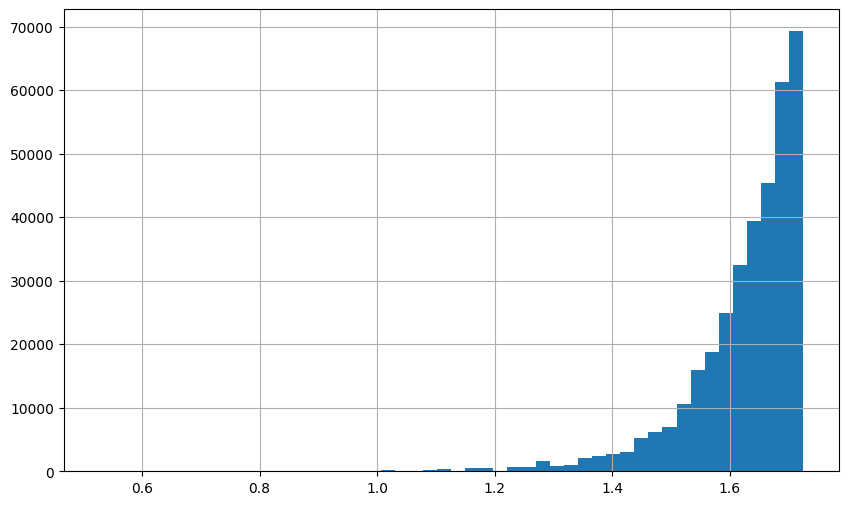

In [71]:
data["log_log_humidity"] = np.log1p(data["log_humidity"])
data["log_log_humidity"].hist(bins=50, figsize=(10, 6))

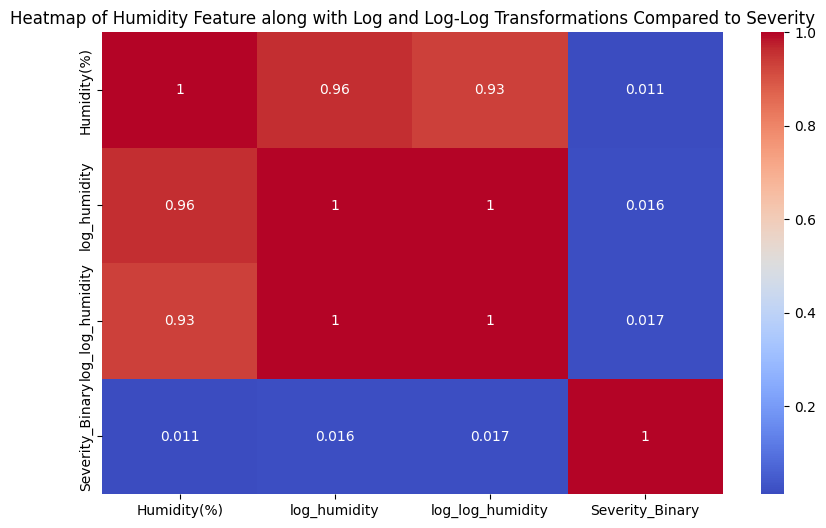

In [72]:
log_corrH = data[["Humidity(%)", "log_humidity", "log_log_humidity", "Severity_Binary"]].corr()

# plot the heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(log_corrH, annot=True, cmap='coolwarm')
plt.title("Heatmap of Humidity Feature along with Log and Log-Log Transformations Compared to Severity")
plt.show()

## Exploring outliers and log of Pressure(in)

- Minimum value of `Pressure` is 0.12, yet the mean is ~29.55
- Filtered outliers so that pressure values range from 28 to 31.12 (max), removing 6.47% of data
- Outlier removal seems to improve the distribution slightly

<Axes: >

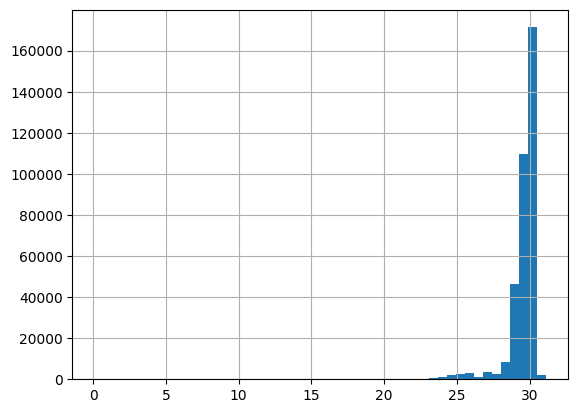

In [73]:
data["Pressure(in)"].hist(bins=50)

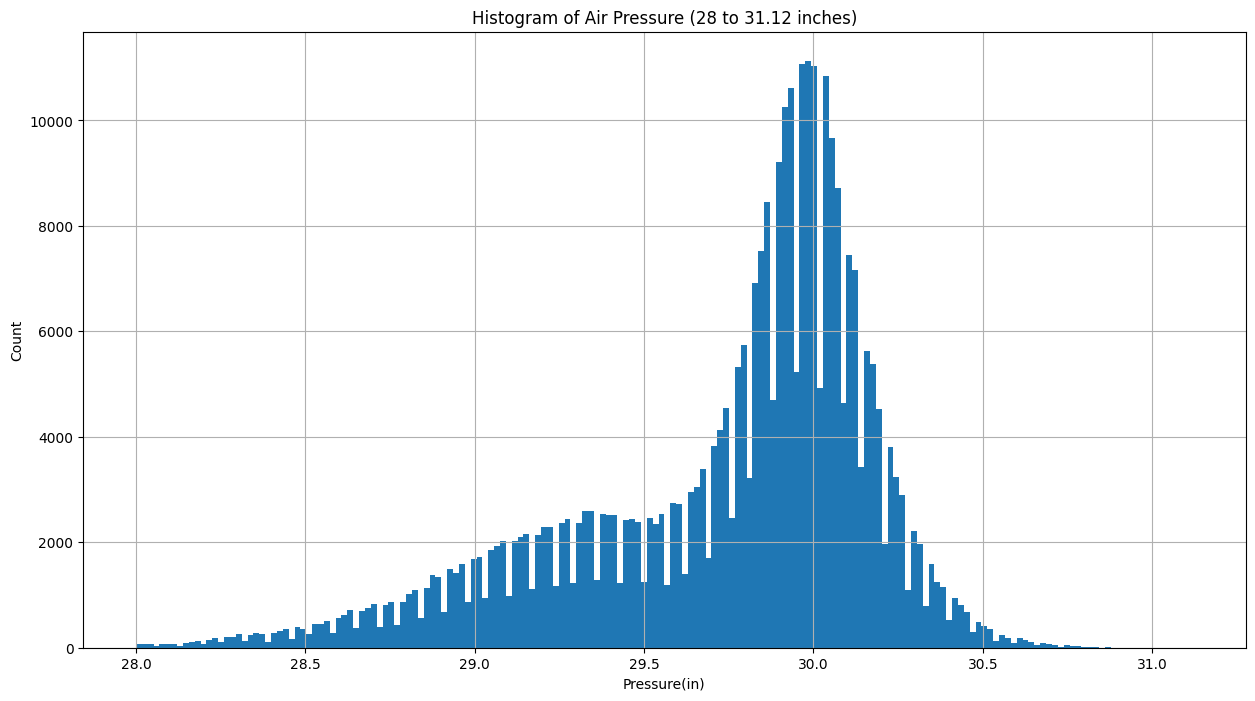

Percentage of durations between 28 and 31.12 inches: 93.53%


In [74]:
pressure = data["Pressure(in)"]

# Filter and plot the histogram
pressure[(pressure >= 28) & (pressure <= 31.12)].hist(bins=180, figsize=(15, 8))
plt.xlabel("Pressure(in)")
plt.ylabel("Count")
plt.title("Histogram of Air Pressure (28 to 31.12 inches)")
plt.show()

# Calculate and print the percentages
percentage_within_range = ((pressure >= 28) & (pressure <= 31.12)).sum() / len(data) * 100

print(f"Percentage of durations between 28 and 31.12 inches: {percentage_within_range:.2f}%")

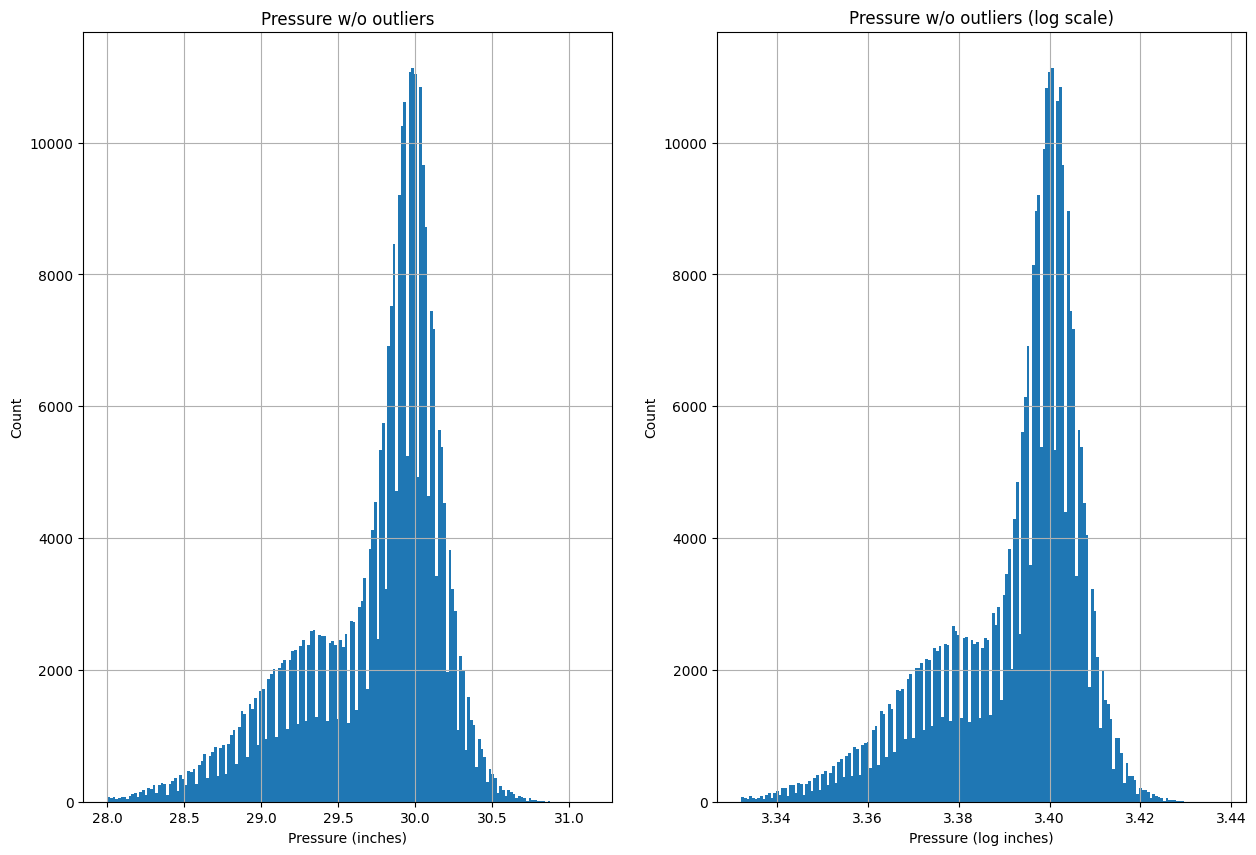

In [75]:
# Filter the data to remove outliers
filtered_pressure = pressure[(pressure >= 28) & (pressure <= 31.12)]

plt.figure(figsize=(15, 10))

# Plot the original duration histogram without outliers
plt.subplot(1, 2, 1)
filtered_pressure.hist(bins=180)
plt.title("Pressure w/o outliers")
plt.xlabel("Pressure (inches)")
plt.ylabel("Count")

# Plot the log-transformed duration histogram without outliers
plt.subplot(1, 2, 2)
np.log(filtered_pressure).hist(bins=180)
plt.title("Pressure w/o outliers (log scale)")
plt.xlabel("Pressure (log inches)")
plt.ylabel("Count")

plt.show()

## Exploring Wind Speed

- Max value of wind speed (822.8) is unrealistic
- Data was filtered to view wind speeds ranging from minimum value to 30 mph (contained ~92% of data)
- Log did not improve distribution of filtered data 

<Axes: >

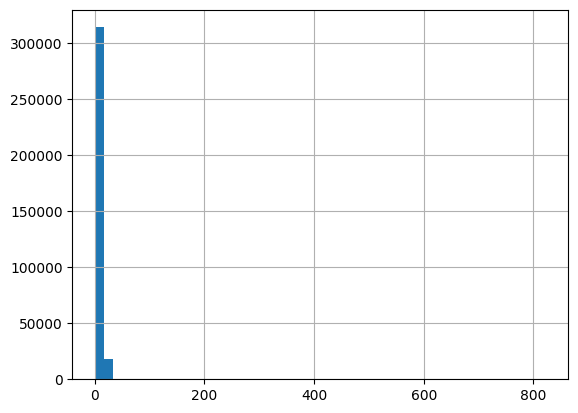

In [76]:
data["Wind_Speed(mph)"].hist(bins=50)

In [77]:
data["Wind_Speed(mph)"].describe()

count    332990.000000
mean          7.694008
std           5.453236
min           0.000000
25%           4.600000
50%           7.000000
75%          10.400000
max         822.800000
Name: Wind_Speed(mph), dtype: float64

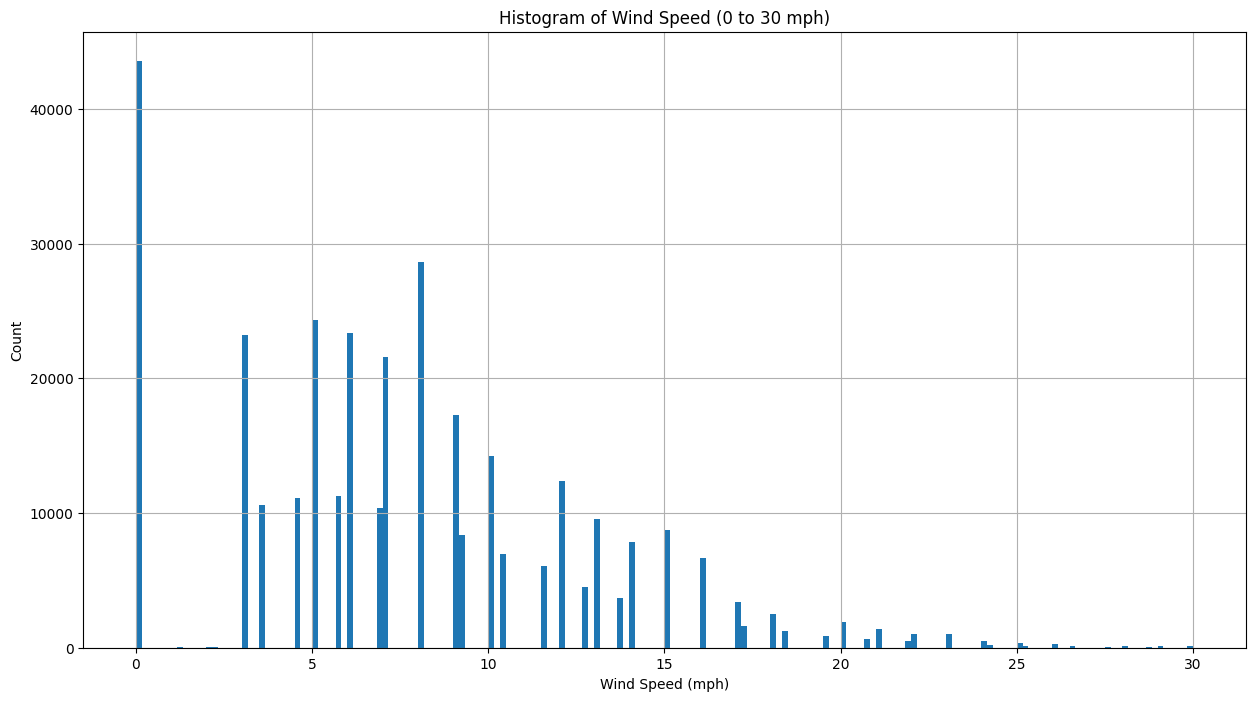

Percentage of wind speeds between 0 and 30 mph: 91.98%


In [78]:
wind_speed = data["Wind_Speed(mph)"]

# Filter and plot the histogram
wind_speed[(wind_speed >= 0) & (wind_speed <= 30)].hist(bins=180, figsize=(15, 8))
plt.xlabel("Wind Speed (mph)")
plt.ylabel("Count")
plt.title("Histogram of Wind Speed (0 to 30 mph)")
plt.show()

# Calculate and print the percentages
percentage_within_range = ((wind_speed >= 0) & (wind_speed <= 30)).sum() / len(data) * 100

print(f"Percentage of wind speeds between 0 and 30 mph: {percentage_within_range:.2f}%")

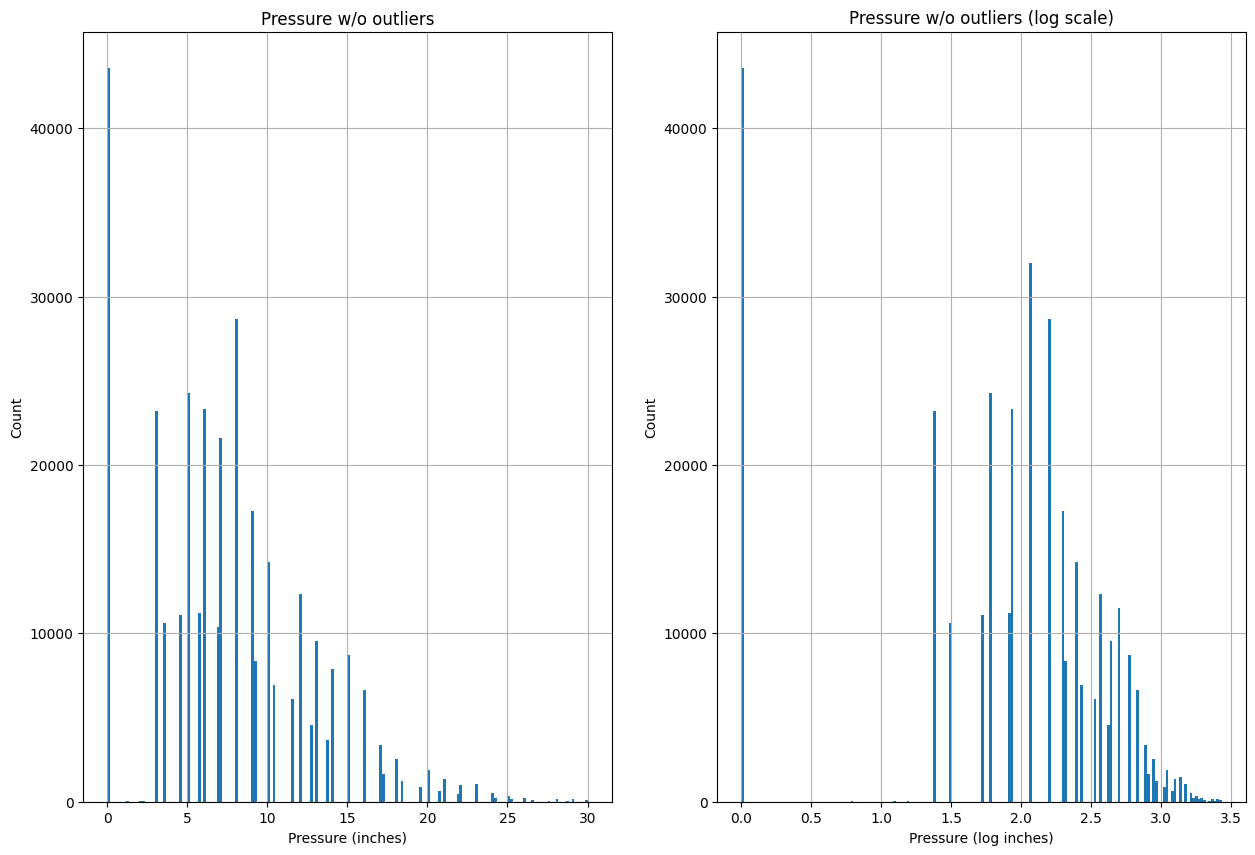

In [79]:
# Filter the data to remove outliers
filtered_wind_speed = wind_speed[(wind_speed >= 0) & (wind_speed <= 30)]

plt.figure(figsize=(15, 10))

# Plot the original duration histogram without outliers
plt.subplot(1, 2, 1)
filtered_wind_speed.hist(bins=180)
plt.title("Pressure w/o outliers")
plt.xlabel("Pressure (inches)")
plt.ylabel("Count")

# Plot the log-transformed duration histogram without outliers
plt.subplot(1, 2, 2)
np.log1p(filtered_wind_speed).hist(bins=180)
plt.title("Pressure w/o outliers (log scale)")
plt.xlabel("Pressure (log inches)")
plt.ylabel("Count")

plt.show()

## Exploring Precipitation

- Reasonable range for precipitation (0-10 inches), won't filter outliers
- Log did not seem to improve distribution much

<Axes: >

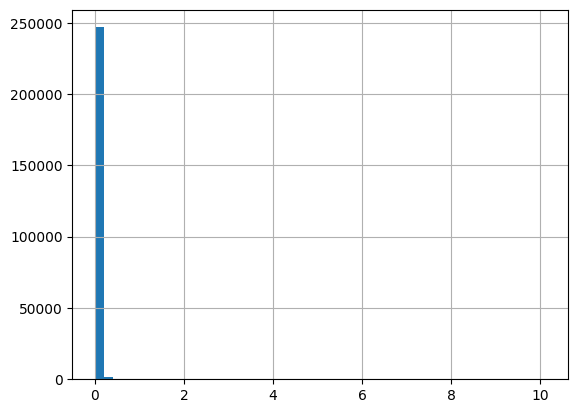

In [80]:
data["Precipitation(in)"].hist(bins=50)

In [81]:
data["Precipitation(in)"].describe()

count    248939.000000
mean          0.008620
std           0.107256
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max          10.130000
Name: Precipitation(in), dtype: float64

<Axes: >

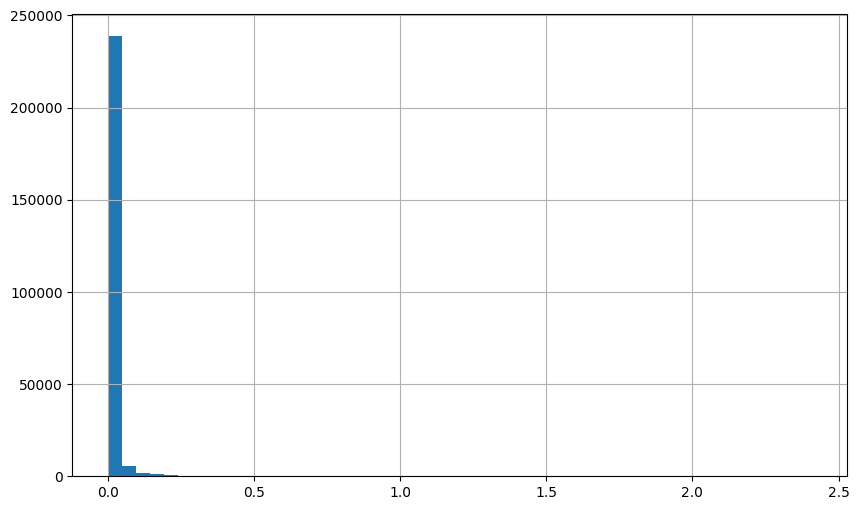

In [82]:
data["log_precipitation"] = np.log1p(data["Precipitation(in)"])
data["log_precipitation"].hist(bins=50, figsize=(10, 6))

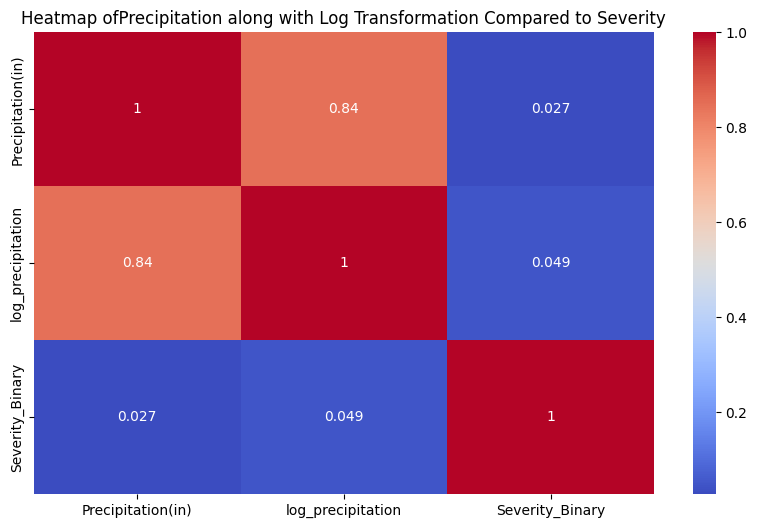

In [83]:
log_corrPrecip = data[["Precipitation(in)", "log_precipitation", "Severity_Binary"]].corr()

# plot the heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(log_corrPrecip, annot=True, cmap='coolwarm')
plt.title("Heatmap ofPrecipitation along with Log Transformation Compared to Severity")
plt.show()

## Outlier Analysis

- Outlier removal results in 7.03% of the data being removed

In [84]:
dat_explore = data.copy()

In [85]:
# give count of missing values in dat explore
missing = dat_explore.isnull().sum().sum()
print(f"Missing values: {missing}")

# give percentage of missing values in dat explore
percentage_missing = missing / (dat_explore.shape[0] * dat_explore.shape[1]) * 100
print(f"Percentage of missing values: {percentage_missing:.2f}%")

Missing values: 781516
Percentage of missing values: 3.33%


In [86]:
dat_explore.shape

(361589, 65)

In [87]:
# As bad samples are found, we remove them and adjust the analysis to make everything cleaner
dat_explore.drop(index=dat_explore[(dat_explore["duration_seconds"] < 150) | (dat_explore["duration_seconds"] > 25200)].index, inplace=True)  
dat_explore.drop(index=dat_explore[(dat_explore["Pressure(in)"] < 28) | (dat_explore["Pressure(in)"] > 31.12)].index, inplace=True)  
dat_explore.drop(index=dat_explore[(dat_explore["Wind_Speed(mph)"] < 0) | (dat_explore["Wind_Speed(mph)"] > 30)].index, inplace=True) 

In [88]:
f"Overall, removed {1 - len(dat_explore) / len(data):.2%} of the data"

'Overall, removed 7.03% of the data'

In [89]:
dat_explore.shape

(336173, 65)

## Exploration Summary

Target Attribute
    - `Severity_Binary` as we're trying to predict whether an accident will be severe or not, and whether the traffic flow will be heavily impacted


Most Important Features:
    - `Street` was deemed the most important by feature importance
    - `Start_Year` and `End_Year` had moderately weak negative correlations (-0.26)
    - `Crossing` and `Traffic_Signal` had weak negative correlations (-0.11)


Important Transformations:
    - Extract `Year`, `Month`, `Day`, `Hour`, and `Minute` from `Start_Time` and `End_Time`
    - Extract `Duration(s)` from `Start_Time` and `End_Time`
    - Label encode categorical features
    - Log of `Duration(s)`


Outliers: Filter features to get rid of unreasonable/extreme values
    - `duration_seconds` between 150 and 25200 (150 seconds to 7 hours)
    - `Pressure(in)` between 28 and 31.12 in
    - `Wind_Speed(mph)` between 0 and 30 mph
        

Features to remove:
    - `ID`, `Source`, `Description`, `Wind_Direction`, `Weather_Condition`, `End_Lat`, `End_Lng`, `Weather_Timestamp`, `Civil_Twilight`, `Astronomical_Twilight`, `Nautical_Twilight`, `Start_Time`, `End_Time`, `Station`, `Amenity`, `Give_Way`, `Railway`, `No_Exit`, `Traffic_Calming`, `Bump`, `Roundabout`, `Country`, `Turning_Loop`


Manual Solution:
    - I would analyze the top predictors to evaluate what contributed to severe accidents and traffic jams (Severity). Street, Start/End_Year, Crossing, and Traffic_Signal could all be used in a manual solution.


Additional data:
    - More samples would be nice to include, along with data that contains less missing values
    - Data that is more comprehensive (over a longer time span)
    - Combining other datasets (population data, different accident datasets)
    - Accident data from the missing 50th state
    - More detailed weather data
    - Event data (holiday, festivals, etc.)

# Prepare the Data

Note: the word *optional* simply means not all datasets will require it, it does not mean you can just choose not to do it if it is needed for a particular dataset.

1. Data cleaning: Fix/remove outliers (optional); Fill in missing values (with 0, mean, median…) or drop rows/columns
2. Feature selection (optional): Drop attributes that provide no useful information for the task
3. Feature engineering, where appropriate: Discretize continuous features; Decompose features (categorical, date/time, …), Add promising transformations of features ($\log(x)$, $\sqrt{x}$, $x^2$, …); Aggregate features into promising new features
4. Feature scaling: standardize or normalize features

In [21]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer, StandardScaler, MinMaxScaler
from sklearn import set_config
set_config(transform_output = "pandas")

In [22]:
# target feature has already been split from X_train
# This cell produces the variables `X` (data) and `y` (labels)

# data 
X = X_train.copy()

# labels
y = y_train.copy()

In [23]:
numeric_attrs = ['Start_Lat',
 'Start_Lng',
 'Distance(mi)',
 'Temperature(F)',
 'Wind_Chill(F)',
 'Humidity(%)',
 'Pressure(in)',
 'Visibility(mi)',
 'Wind_Speed(mph)',
 'Precipitation(in)']

categorical_attrs = ['Street',
 'City',
 'County',
 'State',
 'Zipcode',
 'Timezone',
 'Airport_Code',
 'Sunrise_Sunset']

log_attrs = ['Duration(s)']


def clean_data(X):
    '''
    Extracts features from Start_Time and End_Time and drops unnecessary features
    '''
    print("Columns before cleaning:", X.columns.tolist())

    # extract features from Start_Time and End_Time
    X["Start_Time"] = pd.to_datetime(X["Start_Time"], format='mixed', errors='coerce')
    X["End_Time"] = pd.to_datetime(X["End_Time"], format='mixed', errors='coerce')
    X["Duration(s)"] = (X["End_Time"] - X["Start_Time"]).dt.total_seconds() / 60
    X["Year"] = X["Start_Time"].dt.year
    X["Month"] = X["Start_Time"].dt.month
    X["Day"] = X["Start_Time"].dt.day
    X["Hour"] = X["Start_Time"].dt.hour
    X["Minute"] = X["Start_Time"].dt.minute
    
    #filtering duration and pressure and wind_speed
    # As bad samples are found, we remove them and adjust the analysis to make everything cleaner
    # Identify the indices to drop
    duration_indices = X[(X["Duration(s)"] < 150) | (X["Duration(s)"] > 25200)].index
    pressure_indices = X[(X["Pressure(in)"] < 28) | (X["Pressure(in)"] > 31.12)].index
    wind_speed_indices = X[(X["Wind_Speed(mph)"] < 0) | (X["Wind_Speed(mph)"] > 30)].index

    # Combine all indices to drop
    indices_to_drop = duration_indices.union(pressure_indices).union(wind_speed_indices)

    # Drop the rows from X and y_train
    X.drop(index=indices_to_drop, inplace=True)
    y_train.drop(index=indices_to_drop, inplace=True)

    # id description source wind_direction weather_condition 
    # List of columns to drop
    # includes features with a lower features importance of 0.002
    columns_to_drop = ["ID", "Source", "Description", "Wind_Direction", "Weather_Condition", "End_Lat", "End_Lng", "Weather_Timestamp", "Civil_Twilight", "Astronomical_Twilight", "Nautical_Twilight", "Start_Time", "End_Time", "Station", "Amenity", "Give_Way", "Railway", "No_Exit", "Traffic_Calming", "Bump", "Roundabout", "Country", "Turning_Loop"]
    
    # Drop columns if they exist in the DataFrame
    columns_to_drop = [col for col in columns_to_drop if col in X.columns]
    X = X.drop(columns=columns_to_drop)
    
    print("Columns after cleaning:", X.columns.tolist())

    return X

def label_encoder(X):
    '''
    Encodes categorical features using LabelEncoder
    '''

    # Encode categorical features using LabelEncoder
    for column in categorical_attrs:
        le = LabelEncoder()
        X[column] = le.fit_transform(X[column])

    return X

# humidity and distance won't be logged
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# labelencoder and feature extraction
categorical_transformer = Pipeline(steps=[
    ('label_encoder', FunctionTransformer(label_encoder, validate=False))
])

In [24]:
preprocessor = Pipeline(steps=[
    ('clean', FunctionTransformer(clean_data)),
    ('transform', ColumnTransformer(transformers=[
        ('numerical', numerical_transformer, numeric_attrs),
        ('categorical', categorical_transformer, categorical_attrs),
        ('log', FunctionTransformer(np.log1p), log_attrs)
    ], verbose_feature_names_out=False, remainder='passthrough'))
])

preprocessor

Pipeline(steps=[('clean',
                 FunctionTransformer(func=<function clean_data at 0x000002809EA94220>)),
                ('transform',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('numerical',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Start_Lat', 'Start_Lng',
                                                   'Distance(mi)',
                                                   'Temperature(F)',
                                                   'Wind_Chill(F)',
                                                   'Humidity(%...
                                                   'Wind_Speed(mph)',
                                                   'Precipitation(in)']),
                                                 ('categorical',
                                                  Pipeline(steps=[('label_encoder',
                                                                   FunctionTransformer(func=<function label_encoder at 0x000002809EA951C0>))]),
                                                  ['Street', 'City', 'County',
                                                   'State', 'Zipcode',
                                                   'Timezone', 'Airport_Code',
                                                   'Sunrise_Sunset']),
                                                 ('log',
                                                  FunctionTransformer(func=<ufunc 'log1p'>),
                                                  ['Duration(s)'])],
                                   verbose_feature_names_out=False))])

In [25]:
transformed_data = preprocessor.fit_transform(X)
transformed_data 

Columns before cleaning: ['ID', 'Source', 'Start_Time', 'End_Time', 'Start_Lat', 'Start_Lng', 'End_Lat', 'End_Lng', 'Distance(mi)', 'Description', 'Street', 'City', 'County', 'State', 'Zipcode', 'Country', 'Timezone', 'Airport_Code', 'Weather_Timestamp', 'Temperature(F)', 'Wind_Chill(F)', 'Humidity(%)', 'Pressure(in)', 'Visibility(mi)', 'Wind_Direction', 'Wind_Speed(mph)', 'Precipitation(in)', 'Weather_Condition', 'Amenity', 'Bump', 'Crossing', 'Give_Way', 'Junction', 'No_Exit', 'Railway', 'Roundabout', 'Station', 'Stop', 'Traffic_Calming', 'Traffic_Signal', 'Turning_Loop', 'Sunrise_Sunset', 'Civil_Twilight', 'Nautical_Twilight', 'Astronomical_Twilight']
Columns after cleaning: ['Start_Lat', 'Start_Lng', 'Distance(mi)', 'Street', 'City', 'County', 'State', 'Zipcode', 'Timezone', 'Airport_Code', 'Temperature(F)', 'Wind_Chill(F)', 'Humidity(%)', 'Pressure(in)', 'Visibility(mi)', 'Wind_Speed(mph)', 'Precipitation(in)', 'Crossing', 'Junction', 'Stop', 'Traffic_Signal', 'Sunrise_Sunset', 'D

Start_Lat  Start_Lng  Distance(mi)  Temperature(F)  Wind_Chill(F)  \
391011   0.809244   1.184599      0.411361       -0.356825      -0.195504   
103890   1.580087   0.130488     -0.137623        0.565984       0.722246   
329025  -0.399819  -1.277207      0.589479        0.565984       0.722246   
340656   0.313704   0.607463     -0.493000        1.108813       1.262099   
350201   0.767989  -1.507147     -0.446964        0.131721       0.128408   
...           ...        ...           ...             ...            ...   
395767   0.804882   1.188214     -0.145797        0.620267       0.776231   
208661   0.844719   1.190127     -0.407812       -0.736806       0.128408   
205737   0.857979   0.986671      0.742644       -0.519674      -0.357460   
420036  -0.452641  -1.228982     -0.322195        1.982768       0.128408   
476005   0.402541  -1.471283     -0.493000        1.054530       1.208114   

        Humidity(%)  Pressure(in)  Visibility(mi)  Wind_Speed(mph)  \
391011    -0.987574      0.929361        0.316469        -0.911635   
103890    -0.538929     -1.384033        0.316469         1.070881   
329025     0.044310     -0.068574       -0.427235         0.277875   
340656    -1.256762     -1.678877        0.316469        -0.515132   
350201     0.089175      0.316992        0.316469        -0.118628   
...             ...           ...             ...              ...   
395767     0.044310      0.226271       -0.427235         0.079623   
208661    -1.256762      0.112869        0.316469         1.229483   
205737     0.492956     -2.381967        0.316469        -1.506390   
420036    -2.647563      0.543795        0.316469        -0.594432   
476005    -1.929730     -0.023213        0.316469        -0.118628   

        Precipitation(in)  ...  Duration(s)  Crossing  Junction   Stop  \
391011          -0.049948  ...     6.736512     False     False  False   
103890          -0.049948  ...     5.329978     False     False  False   
329025          -0.049948  ...     5.645506     False      True  False   
340656          -0.049948  ...     5.059954      True     False  False   
350201          -0.049948  ...     5.103518     False     False  False   
...                   ...  ...          ...       ...       ...    ...   
395767          -0.049948  ...     5.764616     False     False  False   
208661          -0.049948  ...     5.888878      True     False  False   
205737          -0.049948  ...     5.628460     False     False  False   
420036          -0.049948  ...     5.888878     False     False  False   
476005          -0.049948  ...     5.681366     False     False  False   

        Traffic_Signal  Year  Month  Day  Hour  Minute  
391011           False  2021      5   13     5      19  
103890           False  2021      6   12     1      32  
329025           False  2021      6   18    12      11  
340656            True  2019     10   10    16      49  
350201           False  2022      7   21    20      29  
...                ...   ...    ...  ...   ...     ...  
395767           False  2022      5   15    12      45  
208661           False  2018      3   22    18       9  
205737           False  2021      3   24     5      17  
420036           False  2017     10   16    13       2  
476005           False  2020      5   23    18       3  

[65408 rows x 28 columns]

In [26]:
# Save the fit preprocessor to the file named preprocessor.pkl (see the book)
import pickle

with open("preprocessor.pkl", "wb") as file:
    pickle.dump(preprocessor, file, 
                protocol=pickle.HIGHEST_PROTOCOL)

In [27]:
transformed_data.shape

(65408, 28)

In [28]:
X_train.shape

(400000, 45)

In [29]:
X.shape

(65408, 51)

In [30]:
y_train.shape

(65408,)

Short List Promising Models
============================

- Models were selected based on our use of label encoding for categorical features
    - Label encoding may make certain algorithms think that our categorical data is ordinal when it's not and handle it in an unintended way
    - Models were selected based on their robustness to label encoded categorical features

In [63]:
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier, VotingClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier, RadiusNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import recall_score, f1_score, auc

In [32]:
# LinearSVC
# DecisionTreeClassifier
# RandomForestClassifier 
# ExtraTreesClassifier
# GradientBoostingClassifier
# KNeighborsClassifier
# XGboost

F1 Score: 0.00
Recall: 0.00
Precision: 0.00


c:\Users\insan\Documents\College\Machine Learning\MLFinalProject\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


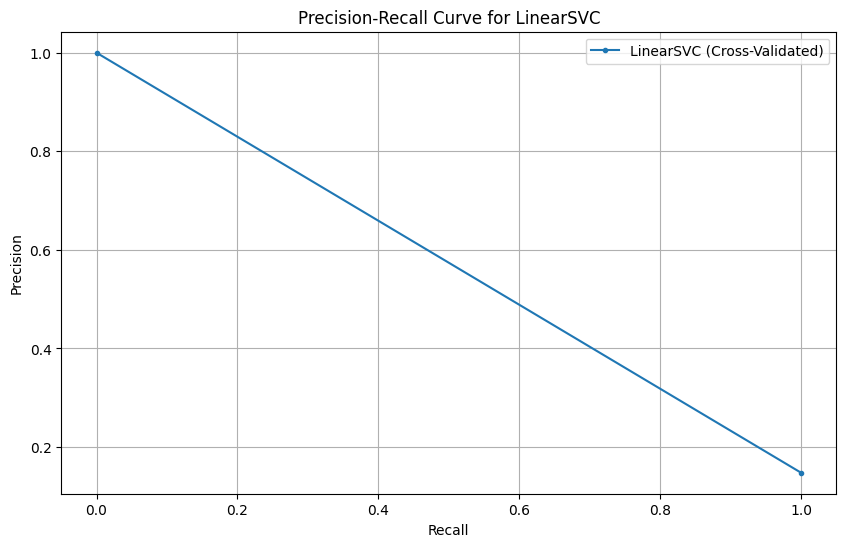

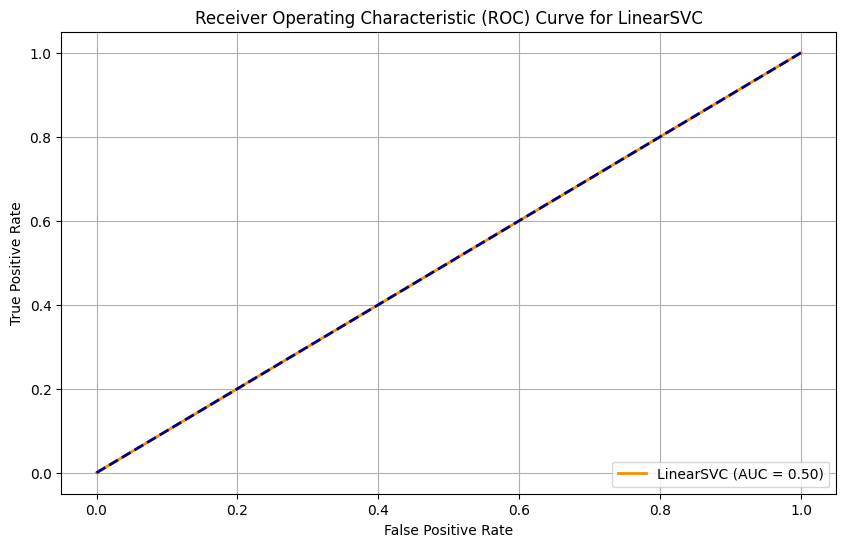

In [33]:
svc = LinearSVC(random_state=42)
y_train_pred = cross_val_predict(svc, transformed_data, y_train, cv=3)

# Calculate basic metrics
f1 = f1_score(y_train, y_train_pred)
recall = recall_score(y_train, y_train_pred)
precision = precision_score(y_train, y_train_pred)

# Calculate precision and recall values
precision_svc, recall_svc, thresholds_svc = precision_recall_curve(y_train, y_train_pred)

print(f"F1 Score: {f1:.2f}")
print(f"Recall: {recall:.2f}")
print(f"Precision: {precision:.2f}")

# Plot the Precision-Recall curve
plt.figure(figsize=(10, 6))
plt.plot(recall_svc, precision_svc, marker='.', label='LinearSVC (Cross-Validated)')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for LinearSVC')
plt.legend()
plt.grid(True)
plt.show()

# Calculate the ROC curve
fpr_svc, tpr_svc, _ = roc_curve(y_train, y_train_pred)
roc_auc_svc = auc(fpr_svc, tpr_svc)

# Plot the ROC curve
plt.figure(figsize=(10, 6))
plt.plot(fpr_svc, tpr_svc, color='darkorange', lw=2, label=f'LinearSVC (AUC = {roc_auc_svc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for LinearSVC')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

F1 Score: 0.45
Recall: 0.47
Precision: 0.44


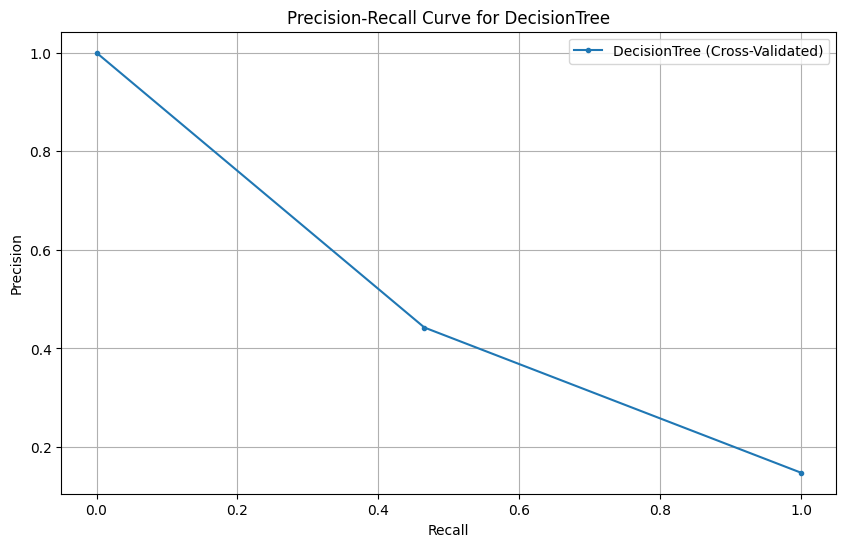

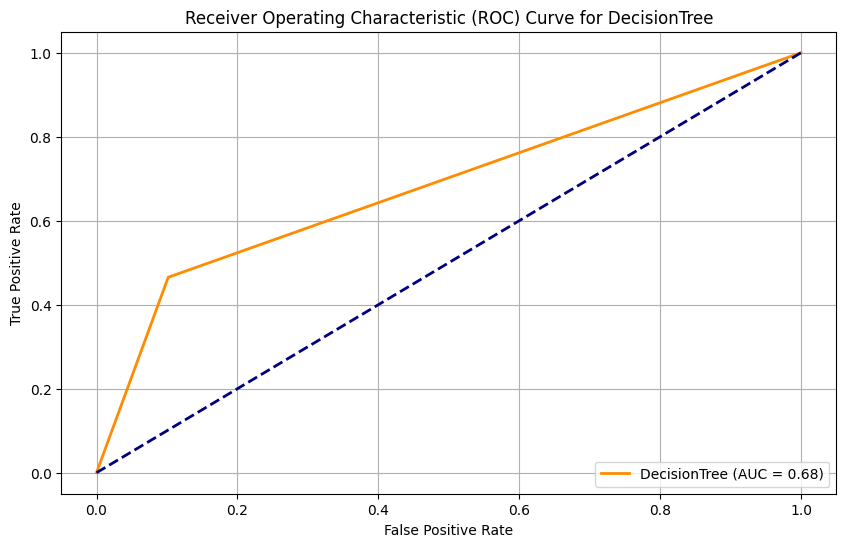

In [34]:
dtc = DecisionTreeClassifier(random_state=42)
y_train_pred = cross_val_predict(dtc, transformed_data, y_train, cv=3)

# Calculate basic metrics
f1 = f1_score(y_train, y_train_pred)
recall = recall_score(y_train, y_train_pred) 
precision = precision_score(y_train, y_train_pred)


# Calculate precision and recall values
precision_dtc, recall_dtc, thresholds_dtc = precision_recall_curve(y_train, y_train_pred)

print(f"F1 Score: {f1:.2f}")
print(f"Recall: {recall:.2f}")
print(f"Precision: {precision:.2f}")

# Plot the Precision-Recall curve
plt.figure(figsize=(10, 6))
plt.plot(recall_dtc, precision_dtc, marker='.', label='DecisionTree (Cross-Validated)')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for DecisionTree')
plt.legend()
plt.grid(True)
plt.show()

# Calculate the ROC curve
fpr_dtc, tpr_dtc, _ = roc_curve(y_train, y_train_pred)
roc_auc_dtc = auc(fpr_dtc, tpr_dtc)

# Plot the ROC curve
plt.figure(figsize=(10, 6))
plt.plot(fpr_dtc, tpr_dtc, color='darkorange', lw=2, label=f'DecisionTree (AUC = {roc_auc_dtc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for DecisionTree')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

F1 Score: 0.49
Recall: 0.37
Precision: 0.72


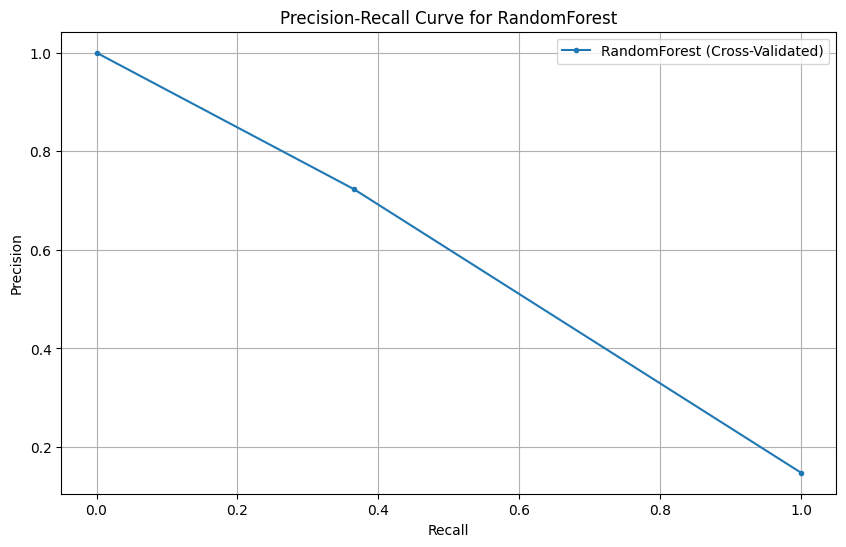

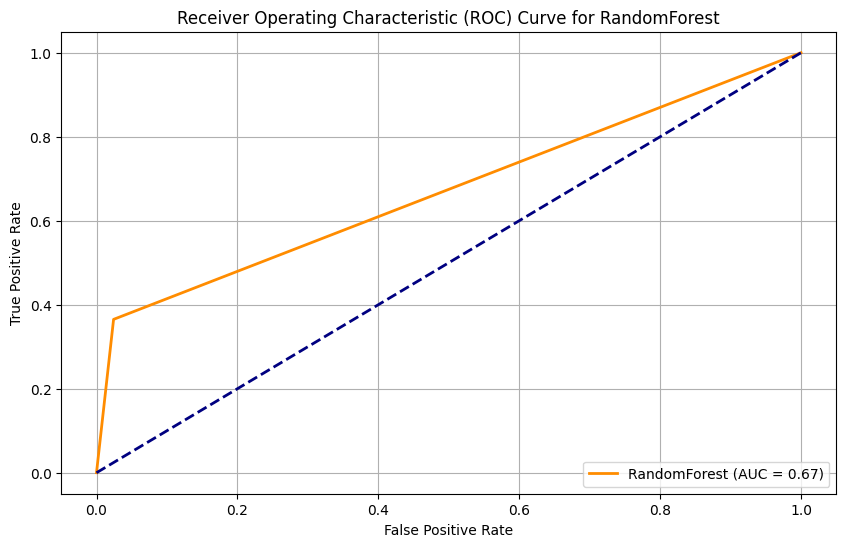

In [35]:
rfc = RandomForestClassifier(random_state=42)
y_train_pred = cross_val_predict(rfc, transformed_data, y_train, cv=3)

# Calculate basic metrics
f1 = f1_score(y_train, y_train_pred)
recall = recall_score(y_train, y_train_pred)
precision = precision_score(y_train, y_train_pred)

# Calculate precision and recall values
precision_rfc, recall_rfc, thresholds_rfc = precision_recall_curve(y_train, y_train_pred)

print(f"F1 Score: {f1:.2f}")
print(f"Recall: {recall:.2f}")
print(f"Precision: {precision:.2f}")

# Plot the Precision-Recall curve
plt.figure(figsize=(10, 6))
plt.plot(recall_rfc, precision_rfc, marker='.', label='RandomForest (Cross-Validated)')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for RandomForest')
plt.legend()
plt.grid(True)
plt.show()

# Calculate the ROC curve
fpr_rfc, tpr_rfc, _ = roc_curve(y_train, y_train_pred)
roc_auc_rfc = auc(fpr_rfc, tpr_rfc)

# Plot the ROC curve
plt.figure(figsize=(10, 6))
plt.plot(fpr_rfc, tpr_rfc, color='darkorange', lw=2, label=f'RandomForest (AUC = {roc_auc_rfc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for RandomForest')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

F1 Score: 0.40
Recall: 0.28
Precision: 0.70


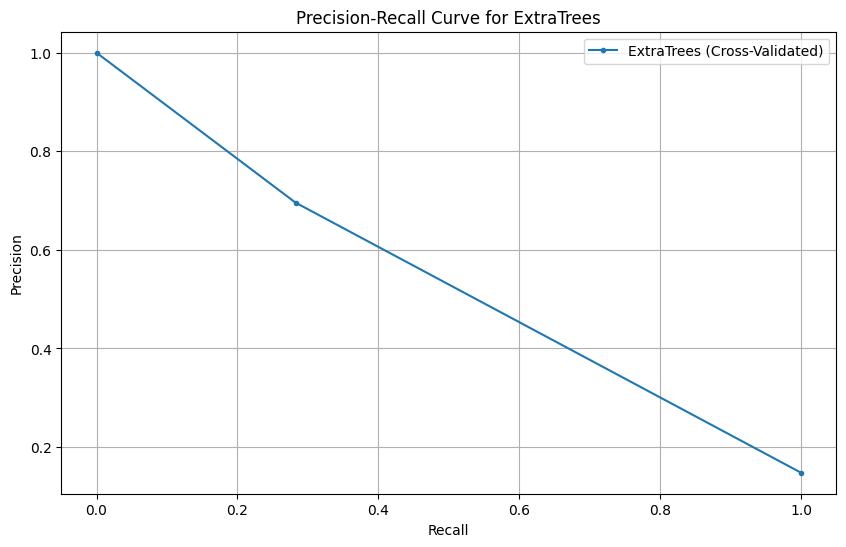

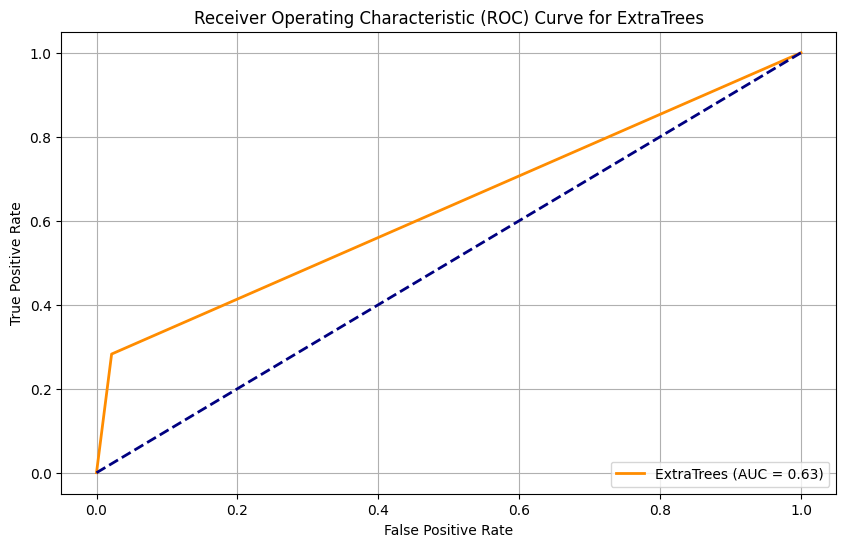

In [36]:
etc = ExtraTreesClassifier(random_state=42)
y_train_pred = cross_val_predict(etc, transformed_data, y_train, cv=3)

# Calculate basic metrics
f1 = f1_score(y_train, y_train_pred)
recall = recall_score(y_train, y_train_pred)
precision = precision_score(y_train, y_train_pred)

# Calculate precision and recall values
precision_etc, recall_etc, thresholds_etc = precision_recall_curve(y_train, y_train_pred)

print(f"F1 Score: {f1:.2f}")
print(f"Recall: {recall:.2f}")
print(f"Precision: {precision:.2f}")

# Plot the Precision-Recall curve
plt.figure(figsize=(10, 6))
plt.plot(recall_etc, precision_etc, marker='.', label='ExtraTrees (Cross-Validated)')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for ExtraTrees')
plt.legend()
plt.grid(True)
plt.show()

# Calculate the ROC curve
fpr_etc, tpr_etc, _ = roc_curve(y_train, y_train_pred)
roc_auc_etc = auc(fpr_etc, tpr_etc)

# Plot the ROC curve
plt.figure(figsize=(10, 6))
plt.plot(fpr_etc, tpr_etc, color='darkorange', lw=2, label=f'ExtraTrees (AUC = {roc_auc_etc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for ExtraTrees')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

F1 Score: 0.38
Recall: 0.26
Precision: 0.71


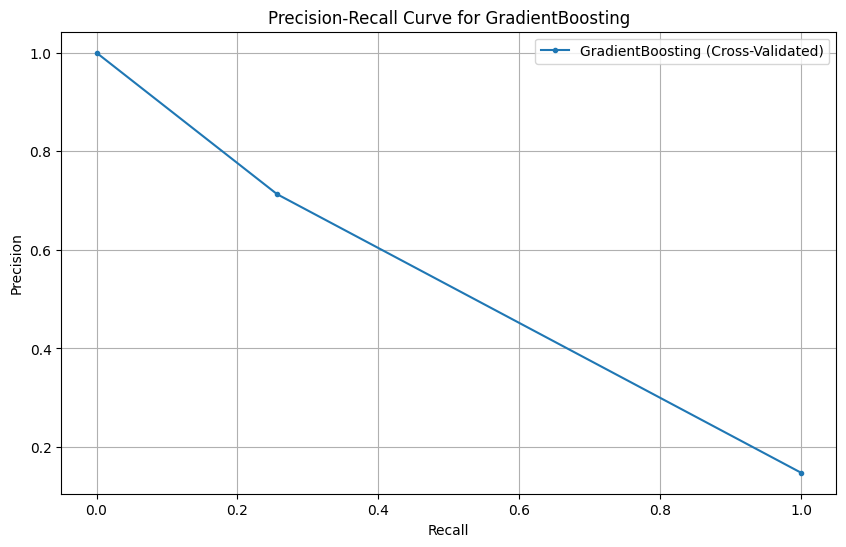

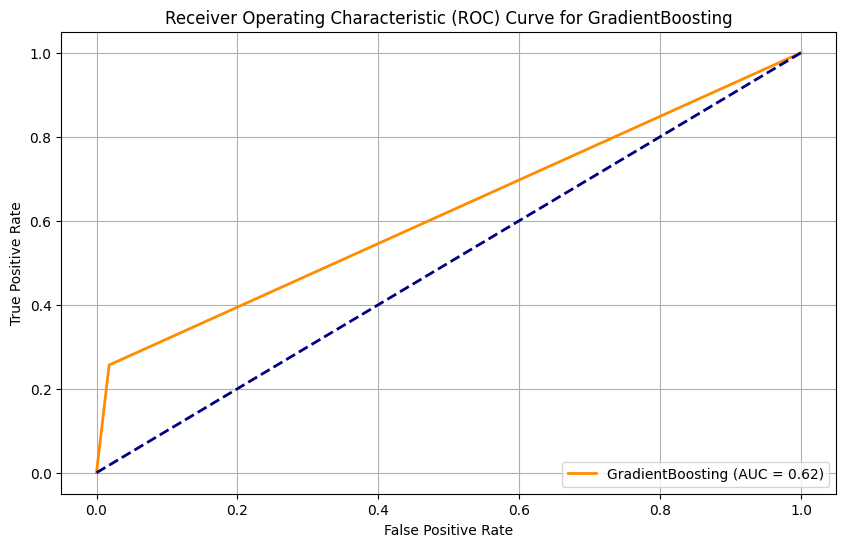

In [37]:
gbc = GradientBoostingClassifier(random_state=42)
y_train_pred = cross_val_predict(gbc, transformed_data, y_train, cv=3)

# Calculate basic metrics
f1 = f1_score(y_train, y_train_pred)
recall = recall_score(y_train, y_train_pred)
precision = precision_score(y_train, y_train_pred)

# Calculate precision and recall values
precision_gbc, recall_gbc, thresholds_gbc = precision_recall_curve(y_train, y_train_pred)

print(f"F1 Score: {f1:.2f}")
print(f"Recall: {recall:.2f}")
print(f"Precision: {precision:.2f}")

# Plot the Precision-Recall curve
plt.figure(figsize=(10, 6))
plt.plot(recall_gbc, precision_gbc, marker='.', label='GradientBoosting (Cross-Validated)')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for GradientBoosting')
plt.legend()
plt.grid(True)
plt.show()

# Calculate the ROC curve
fpr_gbc, tpr_gbc, _ = roc_curve(y_train, y_train_pred)
roc_auc_gbc = auc(fpr_gbc, tpr_gbc)

# Plot the ROC curve
plt.figure(figsize=(10, 6))
plt.plot(fpr_gbc, tpr_gbc, color='darkorange', lw=2, label=f'GradientBoosting (AUC = {roc_auc_gbc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for GradientBoosting')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

c:\Users\insan\Documents\College\Machine Learning\MLFinalProject\.venv\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\insan\Documents\College\Machine Learning\MLFinalProject\.venv\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.12_3.12.2032.0_x64__qbz5n2kfra8p0\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.12_3.12.2032.0_x64__qbz5n2kf

F1 Score: 0.22
Recall: 0.15
Precision: 0.37


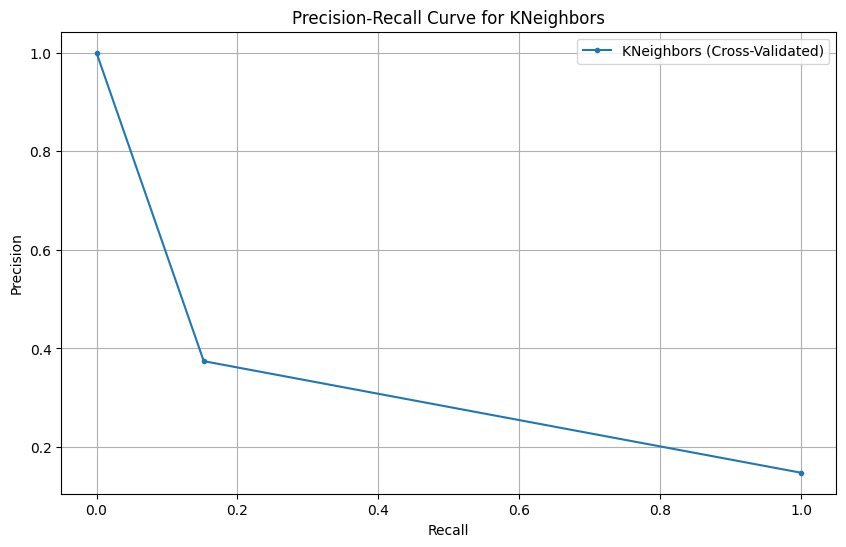

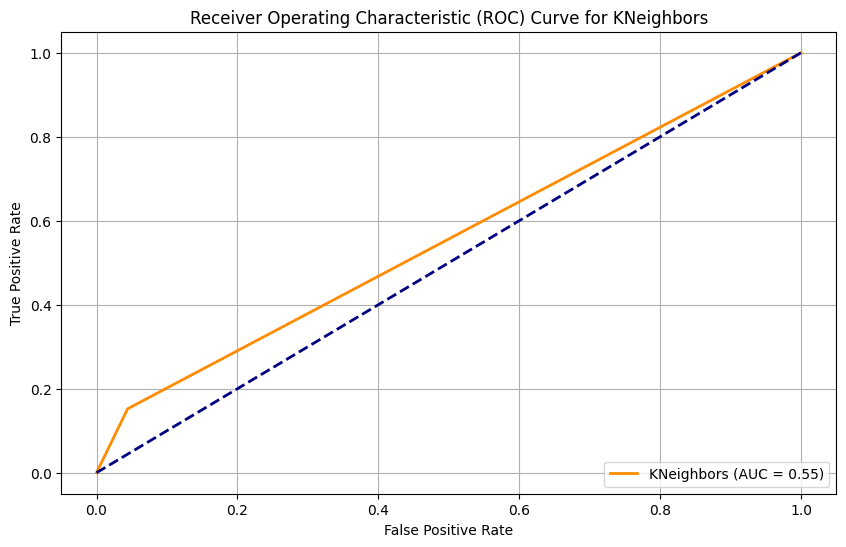

In [38]:
knn = KNeighborsClassifier()
y_train_pred = cross_val_predict(knn, transformed_data, y_train, cv=3)

# Calculate basic metrics
f1 = f1_score(y_train, y_train_pred)
recall = recall_score(y_train, y_train_pred)
precision = precision_score(y_train, y_train_pred)

# Calculate precision and recall values
precision_knn, recall_knn, thresholds_knn = precision_recall_curve(y_train, y_train_pred)

print(f"F1 Score: {f1:.2f}")
print(f"Recall: {recall:.2f}")
print(f"Precision: {precision:.2f}")

# Plot the Precision-Recall curve
plt.figure(figsize=(10, 6))
plt.plot(recall_knn, precision_knn, marker='.', label='KNeighbors (Cross-Validated)')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for KNeighbors')
plt.legend()
plt.grid(True)
plt.show()

# Calculate the ROC curve
fpr_knn, tpr_knn, _ = roc_curve(y_train, y_train_pred)
roc_auc_knn = auc(fpr_knn, tpr_knn)

# Plot the ROC curve
plt.figure(figsize=(10, 6))
plt.plot(fpr_knn, tpr_knn, color='darkorange', lw=2, label=f'KNeighbors (AUC = {roc_auc_knn:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for KNeighbors')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

F1 Score: 0.52
Recall: 0.42
Precision: 0.68


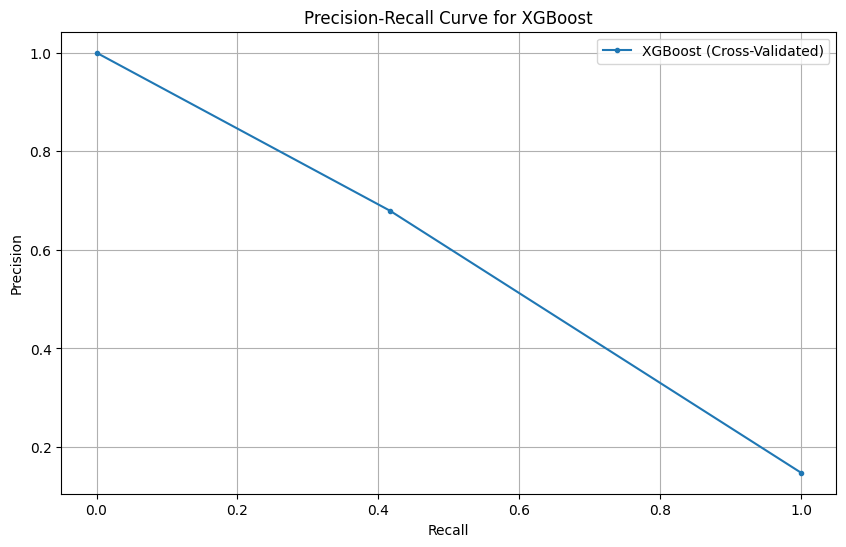

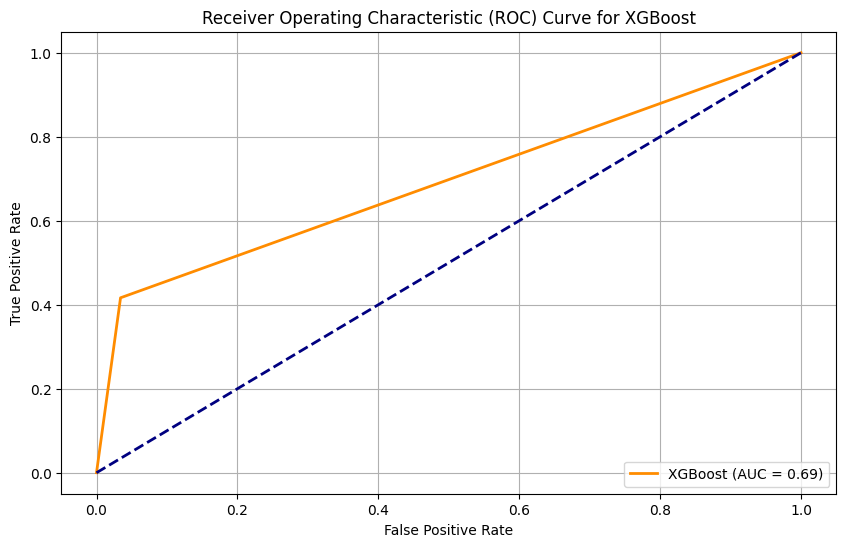

In [39]:
# Initialize and train the XGBoost model
xgb = XGBClassifier(random_state=42)
y_train_pred = cross_val_predict(xgb, transformed_data, y_train, cv=3)

# Calculate basic metrics
f1 = f1_score(y_train, y_train_pred)
recall = recall_score(y_train, y_train_pred)
precision = precision_score(y_train, y_train_pred)

# Calculate precision and recall values
precision_xgb, recall_xgb, thresholds_xgb = precision_recall_curve(y_train, y_train_pred)

print(f"F1 Score: {f1:.2f}")
print(f"Recall: {recall:.2f}")
print(f"Precision: {precision:.2f}")

# Plot the Precision-Recall curve
plt.figure(figsize=(10, 6))
plt.plot(recall_xgb, precision_xgb, marker='.', label='XGBoost (Cross-Validated)')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for XGBoost')
plt.legend()
plt.grid(True)
plt.show()

# Calculate the ROC curve
fpr_xgb, tpr_xgb, _ = roc_curve(y_train, y_train_pred)
roc_auc_xgb = auc(fpr_xgb, tpr_xgb)

# Plot the ROC curve
plt.figure(figsize=(10, 6))
plt.plot(fpr_xgb, tpr_xgb, color='darkorange', lw=2, label=f'XGBoost (AUC = {roc_auc_xgb:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for XGBoost')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

Fine Tune the Model
===================

In [40]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import f1_score, precision_recall_curve, auc, roc_curve
from scipy.stats import uniform

In [41]:
# best models:
# DecisionTreeClassifier
# XGBClassifier

In [48]:
# RandomizedSearchCV for DesicionTreeClassifier
param_distributions = {
    'criterion': ['gini', 'entropy'],
    'splitter': ['best', 'random'],
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': [None, 'sqrt', 'log2']
}

dtc = DecisionTreeClassifier(random_state=42)

random_search_dtc = RandomizedSearchCV(dtc, param_distributions, n_iter=100, scoring='f1', cv=3, random_state=42, n_jobs=-1)
random_search_dtc.fit(transformed_data, y_train)

# Get the best parameters
best_params_dtc = random_search_dtc.best_params_
best_score_dtc = random_search_dtc.best_score_

print(f"Best parameters: {best_params_dtc}")
print(f"Best score: {best_score_dtc:.2f}")

Best parameters: {'splitter': 'best', 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': None, 'max_depth': 10, 'criterion': 'gini'}
Best score: 0.47


In [49]:
# GridSearchCV for DecisionTreeClassifier
param_grid = {
    'criterion': ['gini', 'entropy'],
    'splitter': ['best', 'random'],
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': [None, 'sqrt', 'log2']
}

dtc = DecisionTreeClassifier(random_state=42)

grid_search_dtc = GridSearchCV(dtc, param_grid, scoring='f1', cv=3, n_jobs=-1)
grid_search_dtc.fit(transformed_data, y_train)

# Get the best parameters
best_params_dtc = grid_search_dtc.best_params_
best_score_dtc = grid_search_dtc.best_score_

print(f"Best parameters: {best_params_dtc}")
print(f"Best score: {best_score_dtc:.2f}")

c:\Users\insan\Documents\College\Machine Learning\MLFinalProject\.venv\Lib\site-packages\numpy\ma\core.py:2881: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Best parameters: {'criterion': 'entropy', 'max_depth': 10, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'splitter': 'best'}
Best score: 0.47


In [55]:
# RandomizedSearchCV for XGBClassifier
param_distributions = {
    'n_estimators': [100, 500, 1000],
    'max_depth': [5, 10, 20],
    'learning_rate': [0.1, 0.2, 0.3],  # Typical learning rates
}


xgb = XGBClassifier(enable_categorical=True, random_state=42)

random_search = RandomizedSearchCV(xgb, param_distributions, n_iter=100, scoring='f1', cv=3, random_state=42, n_jobs=-1)
random_search.fit(transformed_data, y_train)

# Get the best parameters
best_params_xgb = random_search.best_params_
best_score_xgb = random_search.best_score_

print(f"Best parameters: {best_params_xgb}")
print(f"Best score: {best_score_xgb:.2f}")

c:\Users\insan\Documents\College\Machine Learning\MLFinalProject\.venv\Lib\site-packages\sklearn\model_selection\_search.py:320: UserWarning: The total space of parameters 27 is smaller than n_iter=100. Running 27 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Best parameters: {'n_estimators': 1000, 'max_depth': 10, 'learning_rate': 0.2}
Best score: 0.53


In [56]:
# GridSearchCV for XGBClassifier
param_grid = {
    'n_estimators': [500, 1000],
    'max_depth': [40, 50],
    'learning_rate': [0.01, 0.1],
}

xgb = XGBClassifier(enable_categorical=True, random_state=42)

grid_search = GridSearchCV(xgb, param_grid, scoring='f1', cv=3, n_jobs=-1)
grid_search.fit(transformed_data, y_train)

# Get the best parameters
best_params_xgb = grid_search.best_params_
best_score_xgb = grid_search.best_score_

print(f"Best parameters: {best_params_xgb}")
print(f"Best score: {best_score_xgb:.2f}")

Best parameters: {'learning_rate': 0.1, 'max_depth': 50, 'n_estimators': 1000}
Best score: 0.53


In [57]:
best_xgb_model = grid_search.best_estimator_
best_dtc_model = grid_search_dtc.best_estimator_

In [58]:
# Save the fit preprocessor of our final model to the file named grid_search.pkl
import pickle

with open("grid_search.pkl", "wb") as file:
    pickle.dump(xgb, file, 
                protocol=pickle.HIGHEST_PROTOCOL)

### Final Model

- XGBoost was selected as its score of 0.53 was greater than Decision Tree Classifier (0.47). 

# Ensemble

- The ensemble's score (0.52) was 0.01 lower than the best model's score (0.53)

In [65]:
# Voting Classifier - Include the model and final metrics

# Define the voting classifier
voting_clf = VotingClassifier(
    estimators=[
        ('xgb', best_xgb_model),
        ('dtc', best_dtc_model)
    ],
    voting='soft'
)

cvp = cross_val_predict(voting_clf, transformed_data, y_train, cv=3)

# Calculate basic metrics
f1 = f1_score(y_train, cvp)
recall = recall_score(y_train, cvp)
precision = precision_score(y_train, cvp)

print(f"F1 Score: {f1:.2f}")
print(f"Recall: {recall:.2f}")
print(f"Precision: {precision:.2f}")

F1 Score: 0.52
Recall: 0.42
Precision: 0.67


## Analysis Summary

- We did not obtain the scores we'd hoped in this particular analysis, and we have taken into consideration future goals in order to improve our score and meet the 0.7 F1 threshold
    - More in-depth data exploration
    - Different handling of encoding categorical features
    - Including more data from the larger, un-sampled dataset